<div align="center">

<p align="center"> 
    <img
        src="./Assets/Turkaracter Logo.png"
        raw=true
        alt="turkaracter_Logo"
        style="width: 128px; height: 128px" />
</p>

# TurKaracter: Entwicklung eines Erkennungssystems von türkischen Handschriften unter Verwendung von künstlichen neuronalen Netzwerken
### Bachelor Abschlussarbeit von Abdurrahman ODABAŞI
### Betreuer: Dr. Ahmet YILDIZ (Türkisch-Deutsche Universität)
### Industriepartner: BIS Çözüm Bilgisayar ve Entegrasyon Hiz. ve Tic. A.Ş.
#### Bearbeitungszeitraum 04.11.2021 - 20.06.2022

</div>

## 0. Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import time
import statistics
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle


# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 0.1. Helper Functions

#### 0.1.1. Save the Figures

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### 0.1.2. Label to Actual Value (Decoding)

In [3]:
def decodeLabel(value):
    if value <= 9:
        return(chr(value+48))
    elif value > 9 and value < 36:
        return(chr(value+55))
    elif value > 35 and value < 62:
        return(chr(value+61))
    elif value > 61 and value < 72:
        turkishDecoder = {
            62:286 , #Ğ
            63:304 , #İ
            64:214 , #Ö
            65:220 , #Ü
            66:231 , #ç
            67:287 , #ğ
            68:305 , #ı
            69:246 , #ö
            70:351 , #ş
            71:252  #ü
        }
        return (chr(turkishDecoder.get(value)))
    # elif value > 71:
    #     # Labels for punctuation marks
    #     return 0

#### 0.1.3. Display the Image in the notebook instead of independent window (With the help of Matplotlib)

In [4]:
def displayImage(image): #Gray_Image with one Channel
    dpi = 80
    height, width = image.shape
    # What Size does the figure need to be in inches to fit the image
    figSize = width/float(dpi), height/float(dpi)

    fig = plt.figure(figsize=figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')

    ax.imshow(image, cmap="gray")
    plt.show()

def displayColouredImage(image):
    dpi = 80
    rgb_image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    height, width, depth = rgb_image.shape
    # What Size does the figure need to be in inches to fit the image
    figSize = width/float(dpi), height/float(dpi)

    fig = plt.figure(figsize=figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')

    ax.imshow(rgb_image, cmap="gray")
    plt.show()

# Models

## 0. Baseline Model

In [6]:
baseline_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

## 1. Picking the dataset with the best performance on the baseline Model

### 1.1. Model for Combination of (Original NIST19 + Original T-H-E)

In [7]:
X_train = np.load("./SplittedDatasets/1/X_train_1.npy")
y_train = np.load("./SplittedDatasets/1/y_train_1.npy")
# X_test = np.load("./SplittedDatasets/1/X_test_1.npy")
# y_test = np.load("./SplittedDatasets/1/y_test_1.npy")

In [8]:
baseline_model_1_1 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [9]:
baseline_model_1_1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [10]:
baseline_model_1_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)      

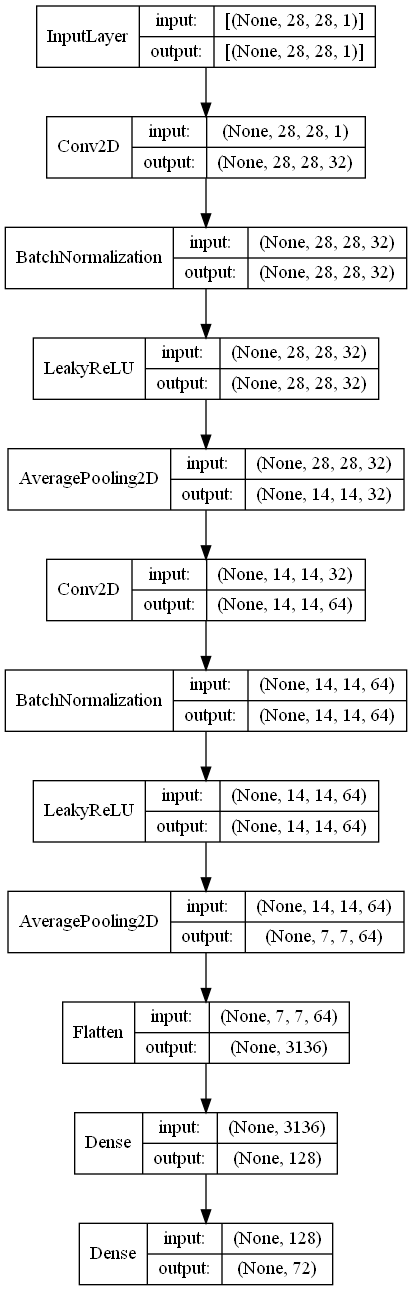

In [11]:
keras.utils.plot_model(baseline_model_1_1, to_file='./images/baseline_model_plot.png', show_shapes=True, show_layer_names=False)

In [12]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_1.h5", save_best_only=True)

In [13]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_1"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [14]:
model_1_1_t0 = time.time()
history_1_1 = baseline_model_1_1.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_1_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 373s 22ms/step - loss: 0.5582 - sparse_categorical_accuracy: 0.8204 - sparse_top_k_categorical_accuracy: 0.9622 - val_loss: 0.4564 - val_sparse_categorical_accuracy: 0.8470 - val_sparse_top_k_categorical_accuracy: 0.9782
Epoch 2/100
16688/16688 [==============================] - 375s 22ms/step - loss: 0.4247 - sparse_categorical_accuracy: 0.8558 - sparse_top_k_categorical_accuracy: 0.9820 - val_loss: 0.4289 - val_sparse_categorical_accuracy: 0.8555 - val_sparse_top_k_categorical_accuracy: 0.9820
Epoch 3/100
16688/16688 [==============================] - 378s 23ms/step - loss: 0.3947 - sparse_categorical_accuracy: 0.8642 - sparse_top_k_categorical_accuracy: 0.9848 - val_loss: 0.4086 - val_sparse_categorical_accuracy: 0.8604 - val_sparse_top_k_categorical_accuracy: 0.9830
Epoch 4/100
16688/16688 [==============================] - 371s 22ms/step - loss: 0.3765 - sparse_categorical_accuracy: 0.8694 - sparse_top_k_categorical_accura

In [15]:
print("Training took {:.2f}s for all Epochs".format(model_1_1_t1 - model_1_1_t0))

Training took 9023.54s for all Epochs


In [16]:
history_1_1.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [17]:
print("Best Training Accuracy: ", round(history_1_1.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_1.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_1.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_1.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_1.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_1.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.88304
Best Training Loss:  0.32851
Best Training Top k Accuracy:  0.99053
Best Validation Accuracy:  0.86753
Best Validation Loss:  0.39551
Best Validation Top k Accuracy:  0.98527


In [39]:
baseline_model_1_1.save("./Model_Checkpoints/baseline_model_1_1")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('model',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('model',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do

In [19]:
np.save('./Histories/history_1_1.npy', history_1_1.history)

Saving figure model_1_1_learning_curves_plot_loss


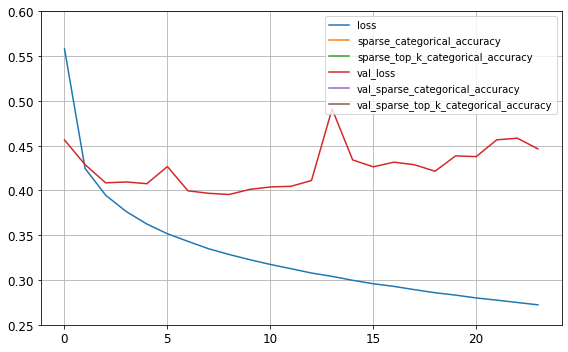

Saving figure model_1_1_learning_curves_plot_accuracy


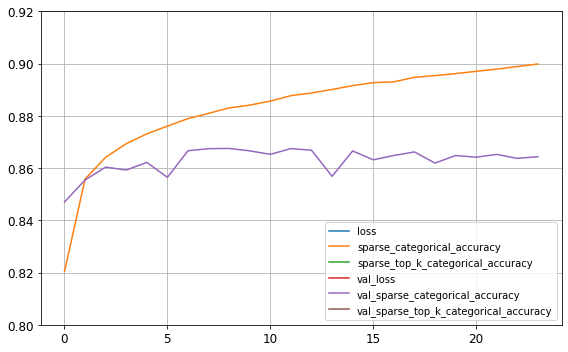

In [378]:
pd.DataFrame(history_1_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.25, 0.6)
save_fig("model_1_1_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 0.92)
save_fig("model_1_1_learning_curves_plot_accuracy")
plt.show()

### 1.2. Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E)

In [42]:
X_train = np.load("./SplittedDatasets/2/X_train_2.npy")
y_train = np.load("./SplittedDatasets/2/y_train_2.npy")

In [22]:
baseline_model_1_2 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [23]:
baseline_model_1_2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [24]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_2.h5", save_best_only=True)

In [25]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_2"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [26]:
model_1_2_t0 = time.time()
history_1_2 = baseline_model_1_2.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_2_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 382s 23ms/step - loss: 0.3160 - sparse_categorical_accuracy: 0.8951 - sparse_top_k_categorical_accuracy: 0.9766 - val_loss: 0.2420 - val_sparse_categorical_accuracy: 0.9153 - val_sparse_top_k_categorical_accuracy: 0.9845
Epoch 2/100
16688/16688 [==============================] - 382s 23ms/step - loss: 0.2193 - sparse_categorical_accuracy: 0.9218 - sparse_top_k_categorical_accuracy: 0.9858 - val_loss: 0.2138 - val_sparse_categorical_accuracy: 0.9241 - val_sparse_top_k_categorical_accuracy: 0.9860
Epoch 3/100
16688/16688 [==============================] - 387s 23ms/step - loss: 0.1934 - sparse_categorical_accuracy: 0.9293 - sparse_top_k_categorical_accuracy: 0.9903 - val_loss: 0.2146 - val_sparse_categorical_accuracy: 0.9241 - val_sparse_top_k_categorical_accuracy: 0.9908
Epoch 4/100
16688/16688 [==============================] - 372s 22ms/step - loss: 0.1739 - sparse_categorical_accuracy: 0.9359 - sparse_top_k_categorical_accura

In [27]:
print("Training took {:.2f}s for all Epochs".format(model_1_2_t1 - model_1_2_t0))

Training took 7695.22s for all Epochs


In [28]:
history_1_2.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [29]:
print("Best Training Accuracy: ", round(history_1_2.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_2.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_2.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_2.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_2.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_2.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.94084
Best Training Loss:  0.15808
Best Training Top k Accuracy:  0.99618
Best Validation Accuracy:  0.93556
Best Validation Loss:  0.18002
Best Validation Top k Accuracy:  0.99469


In [30]:
baseline_model_1_2.save("./Model_Checkpoints/baseline_model_1_2")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('model',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('model',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do

In [31]:
np.save('./Histories/history_1_2.npy', history_1_2.history)

Saving figure model_1_2_learning_curves_plot_loss


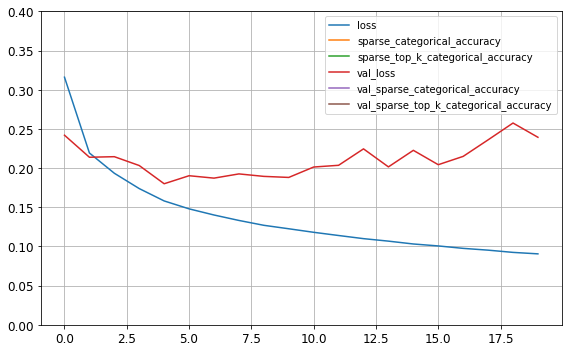

Saving figure model_1_2_learning_curves_plot_accuracy


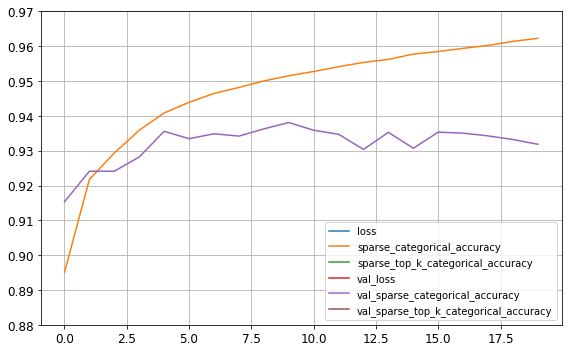

In [380]:
pd.DataFrame(history_1_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.0, 0.4)
save_fig("model_1_2_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.88, 0.97)
save_fig("model_1_2_learning_curves_plot_accuracy")
plt.show()

### 1.3. Model for Combination of (Zoomed NIST19 (Keras) + Original T-H-E)

In [7]:
X_train = np.load("./SplittedDatasets/3/X_train_3.npy")
y_train = np.load("./SplittedDatasets/3/y_train_3.npy")

In [8]:
baseline_model_1_3 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [9]:
baseline_model_1_3.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [10]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_3.h5", save_best_only=True)

In [11]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_3"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [12]:
model_1_3_t0 = time.time()
history_1_3 = baseline_model_1_3.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_3_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 377s 23ms/step - loss: 1.0332 - sparse_categorical_accuracy: 0.6181 - sparse_top_k_categorical_accuracy: 0.9068 - val_loss: 0.8943 - val_sparse_categorical_accuracy: 0.6469 - val_sparse_top_k_categorical_accuracy: 0.9337
Epoch 2/100
16688/16688 [==============================] - 384s 23ms/step - loss: 0.8542 - sparse_categorical_accuracy: 0.6613 - sparse_top_k_categorical_accuracy: 0.9392 - val_loss: 0.8469 - val_sparse_categorical_accuracy: 0.6668 - val_sparse_top_k_categorical_accuracy: 0.9413
Epoch 3/100
16688/16688 [==============================] - 375s 22ms/step - loss: 0.8140 - sparse_categorical_accuracy: 0.6738 - sparse_top_k_categorical_accuracy: 0.9449 - val_loss: 0.8322 - val_sparse_categorical_accuracy: 0.6689 - val_sparse_top_k_categorical_accuracy: 0.9425
Epoch 4/100
16688/16688 [==============================] - 381s 23ms/step - loss: 0.7891 - sparse_categorical_accuracy: 0.6801 - sparse_top_k_categorical_accura

In [13]:
print("Training took {:.2f}s for all Epochs".format(model_1_3_t1 - model_1_3_t0))

Training took 9954.59s for all Epochs


In [14]:
history_1_3.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [15]:
print("Best Training Accuracy: ", round(history_1_3.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_3.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_3.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_3.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_3.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_3.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.70597
Best Training Loss:  0.71042
Best Training Top k Accuracy:  0.9576
Best Validation Accuracy:  0.6868
Best Validation Loss:  0.77822
Best Validation Top k Accuracy:  0.95003


In [16]:
baseline_model_1_3.save("./Model_Checkpoints/baseline_model_1_3")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_3\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_3\assets


In [17]:
np.save('./Histories/history_1_3.npy', history_1_3.history)

Saving figure model_1_3_learning_curves_plot


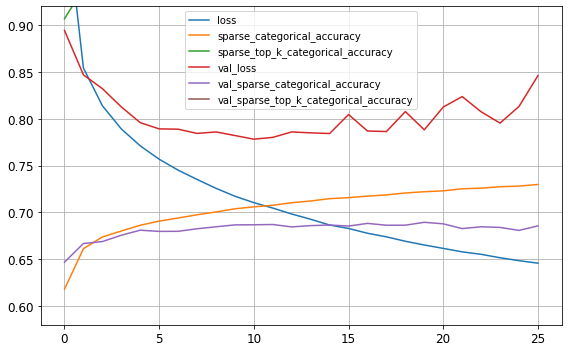

In [296]:
pd.DataFrame(history_1_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.58, 0.92)
save_fig("model_1_3_learning_curves_plot")
plt.show()

### 1.4. Model for Combination of (Original NIST19 + Padded T-H-E)

In [19]:
X_train = np.load("./SplittedDatasets/4/X_train_4.npy")
y_train = np.load("./SplittedDatasets/4/y_train_4.npy")

In [20]:
baseline_model_1_4 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [21]:
baseline_model_1_4.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [22]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_4.h5", save_best_only=True)

In [23]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_4"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [24]:
model_1_4_t0 = time.time()
history_1_4 = baseline_model_1_4.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_4_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 358s 21ms/step - loss: 0.5415 - sparse_categorical_accuracy: 0.8270 - sparse_top_k_categorical_accuracy: 0.9667 - val_loss: 0.4558 - val_sparse_categorical_accuracy: 0.8474 - val_sparse_top_k_categorical_accuracy: 0.9787
Epoch 2/100
16688/16688 [==============================] - 354s 21ms/step - loss: 0.4185 - sparse_categorical_accuracy: 0.8580 - sparse_top_k_categorical_accuracy: 0.9824 - val_loss: 0.4206 - val_sparse_categorical_accuracy: 0.8592 - val_sparse_top_k_categorical_accuracy: 0.9822
Epoch 3/100
16688/16688 [==============================] - 353s 21ms/step - loss: 0.3901 - sparse_categorical_accuracy: 0.8655 - sparse_top_k_categorical_accuracy: 0.9850 - val_loss: 0.4030 - val_sparse_categorical_accuracy: 0.8616 - val_sparse_top_k_categorical_accuracy: 0.9837
Epoch 4/100
16688/16688 [==============================] - 353s 21ms/step - loss: 0.3717 - sparse_categorical_accuracy: 0.8709 - sparse_top_k_categorical_accura

In [25]:
print("Training took {:.2f}s for all Epochs".format(model_1_4_t1 - model_1_4_t0))

Training took 7990.05s for all Epochs


In [26]:
history_1_4.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [27]:
print("Best Training Accuracy: ", round(history_1_4.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_4.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_4.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_4.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_4.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_4.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.87741
Best Training Loss:  0.34742
Best Training Top k Accuracy:  0.9889
Best Validation Accuracy:  0.8657
Best Validation Loss:  0.39343
Best Validation Top k Accuracy:  0.98511


In [28]:
baseline_model_1_4.save("./Model_Checkpoints/baseline_model_1_4")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_4\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_4\assets


In [29]:
np.save('./Histories/history_1_4.npy', history_1_4.history)

Saving figure model_1_4_learning_curves_plot_loss


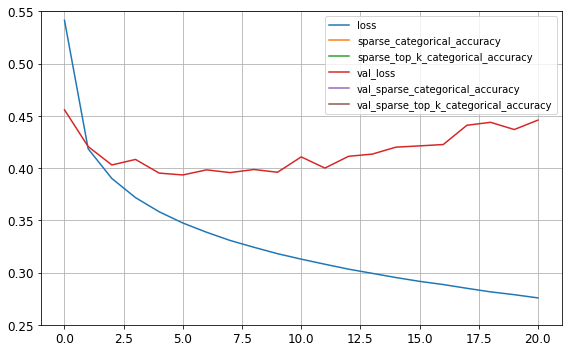

Saving figure model_1_4_learning_curves_plot_accuracy


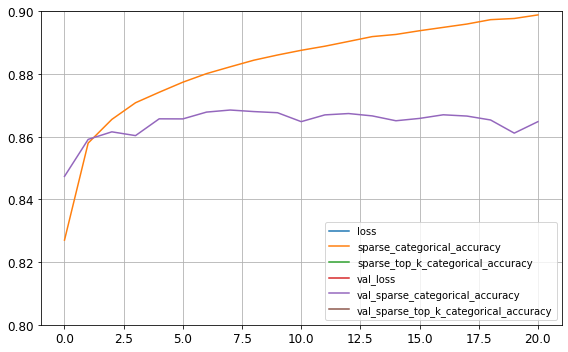

In [298]:
pd.DataFrame(history_1_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.25, 0.55)
save_fig("model_1_4_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 0.90)
save_fig("model_1_4_learning_curves_plot_accuracy")
plt.show()

### 1.5. Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Padded T-H-E)

In [31]:
X_train = np.load("./SplittedDatasets/5/X_train_5.npy")
y_train = np.load("./SplittedDatasets/5/y_train_5.npy")

In [32]:
baseline_model_1_5 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [33]:
baseline_model_1_5.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [34]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_5.h5", save_best_only=True)

In [35]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_5"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [36]:
model_1_5_t0 = time.time()
history_1_5 = baseline_model_1_5.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_5_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 380s 23ms/step - loss: 0.2923 - sparse_categorical_accuracy: 0.9040 - sparse_top_k_categorical_accuracy: 0.9853 - val_loss: 0.2255 - val_sparse_categorical_accuracy: 0.9226 - val_sparse_top_k_categorical_accuracy: 0.9920
Epoch 2/100
16688/16688 [==============================] - 379s 23ms/step - loss: 0.1924 - sparse_categorical_accuracy: 0.9318 - sparse_top_k_categorical_accuracy: 0.9947 - val_loss: 0.1897 - val_sparse_categorical_accuracy: 0.9320 - val_sparse_top_k_categorical_accuracy: 0.9945
Epoch 3/100
16688/16688 [==============================] - 353s 21ms/step - loss: 0.1701 - sparse_categorical_accuracy: 0.9379 - sparse_top_k_categorical_accuracy: 0.9961 - val_loss: 0.1885 - val_sparse_categorical_accuracy: 0.9335 - val_sparse_top_k_categorical_accuracy: 0.9952
Epoch 4/100
16688/16688 [==============================] - 352s 21ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.9421 - sparse_top_k_categorical_accura

In [37]:
print("Training took {:.2f}s for all Epochs".format(model_1_5_t1 - model_1_5_t0))

Training took 7839.08s for all Epochs


In [38]:
history_1_5.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [39]:
print("Best Training Accuracy: ", round(history_1_5.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_5.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_5.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_5.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_5.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_5.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.94947
Best Training Loss:  0.13089
Best Training Top k Accuracy:  0.99828
Best Validation Accuracy:  0.93993
Best Validation Loss:  0.17075
Best Validation Top k Accuracy:  0.99607


In [40]:
baseline_model_1_5.save("./Model_Checkpoints/baseline_model_1_5")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_5\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_5\assets


In [41]:
np.save('./Histories/history_1_5.npy', history_1_5.history)

Saving figure model_1_5_learning_curves_plot_loss


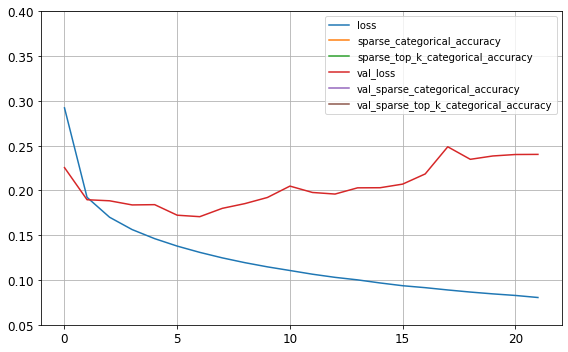

Saving figure model_1_5_learning_curves_plot_accuracy


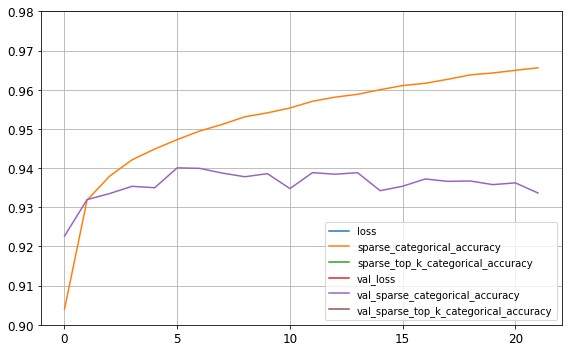

In [299]:
pd.DataFrame(history_1_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.05, 0.4)
save_fig("model_1_5_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.9, 0.98)
save_fig("model_1_5_learning_curves_plot_accuracy")
plt.show()

### 1.6. Model for Combination of (Zoomed NIST19 (Keras) + Padded T-H-E)

In [43]:
X_train = np.load("./SplittedDatasets/6/X_train_6.npy")
y_train = np.load("./SplittedDatasets/6/y_train_6.npy")

In [44]:
baseline_model_1_6 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [45]:
baseline_model_1_6.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [46]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_6.h5", save_best_only=True)

In [47]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_6"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [48]:
model_1_6_t0 = time.time()
history_1_6 = baseline_model_1_6.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_6_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 374s 22ms/step - loss: 1.0119 - sparse_categorical_accuracy: 0.6248 - sparse_top_k_categorical_accuracy: 0.9131 - val_loss: 0.8932 - val_sparse_categorical_accuracy: 0.6468 - val_sparse_top_k_categorical_accuracy: 0.9324
Epoch 2/100
16688/16688 [==============================] - 380s 23ms/step - loss: 0.8429 - sparse_categorical_accuracy: 0.6653 - sparse_top_k_categorical_accuracy: 0.9408 - val_loss: 0.8336 - val_sparse_categorical_accuracy: 0.6711 - val_sparse_top_k_categorical_accuracy: 0.9420
Epoch 3/100
16688/16688 [==============================] - 383s 23ms/step - loss: 0.8038 - sparse_categorical_accuracy: 0.6767 - sparse_top_k_categorical_accuracy: 0.9458 - val_loss: 0.8068 - val_sparse_categorical_accuracy: 0.6769 - val_sparse_top_k_categorical_accuracy: 0.9453
Epoch 4/100
16688/16688 [==============================] - 383s 23ms/step - loss: 0.7792 - sparse_categorical_accuracy: 0.6841 - sparse_top_k_categorical_accura

In [49]:
print("Training took {:.2f}s for all Epochs".format(model_1_6_t1 - model_1_6_t0))

Training took 9208.21s for all Epochs


In [50]:
history_1_6.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [51]:
print("Best Training Accuracy: ", round(history_1_6.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_6.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_6.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_6.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_6.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_6.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.70386
Best Training Loss:  0.7153
Best Training Top k Accuracy:  0.95689
Best Validation Accuracy:  0.68761
Best Validation Loss:  0.77287
Best Validation Top k Accuracy:  0.95009


In [52]:
baseline_model_1_6.save("./Model_Checkpoints/baseline_model_1_6")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_6\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_6\assets


In [53]:
np.save('./Histories/history_1_6.npy', history_1_6.history)

Saving figure model_1_6_learning_curves_plot


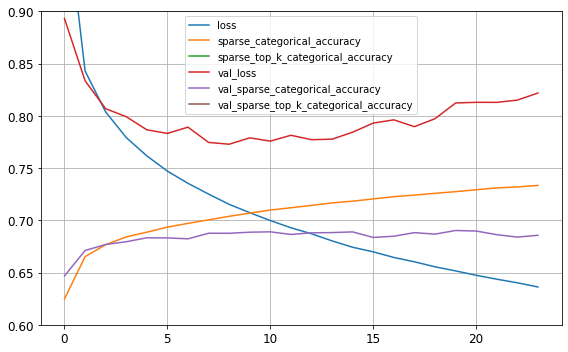

In [303]:
pd.DataFrame(history_1_6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.6, 0.90)
save_fig("model_1_6_learning_curves_plot")
plt.show()

### 1.7. Model for Combination of (Original NIST19 + Original T-H-E + Padded T-H-E)

In [55]:
X_train = np.load("./SplittedDatasets/7/X_train_7.npy")
y_train = np.load("./SplittedDatasets/7/y_train_7.npy")

In [56]:
baseline_model_1_7 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [57]:
baseline_model_1_7.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [58]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_7.h5", save_best_only=True)

In [59]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_7"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [60]:
model_1_7_t0 = time.time()
history_1_7 = baseline_model_1_7.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_7_t1 = time.time()

Epoch 1/100
16913/16913 [==============================] - 385s 23ms/step - loss: 0.5643 - sparse_categorical_accuracy: 0.8175 - sparse_top_k_categorical_accuracy: 0.9616 - val_loss: 0.4718 - val_sparse_categorical_accuracy: 0.8401 - val_sparse_top_k_categorical_accuracy: 0.9790
Epoch 2/100
16913/16913 [==============================] - 388s 23ms/step - loss: 0.4275 - sparse_categorical_accuracy: 0.8547 - sparse_top_k_categorical_accuracy: 0.9816 - val_loss: 0.4284 - val_sparse_categorical_accuracy: 0.8554 - val_sparse_top_k_categorical_accuracy: 0.9818
Epoch 3/100
16913/16913 [==============================] - 388s 23ms/step - loss: 0.3964 - sparse_categorical_accuracy: 0.8632 - sparse_top_k_categorical_accuracy: 0.9849 - val_loss: 0.4119 - val_sparse_categorical_accuracy: 0.8600 - val_sparse_top_k_categorical_accuracy: 0.9833
Epoch 4/100
16913/16913 [==============================] - 388s 23ms/step - loss: 0.3772 - sparse_categorical_accuracy: 0.8686 - sparse_top_k_categorical_accura

In [61]:
print("Training took {:.2f}s for all Epochs".format(model_1_7_t1 - model_1_7_t0))

Training took 8896.49s for all Epochs


In [62]:
history_1_7.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [63]:
print("Best Training Accuracy: ", round(history_1_7.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_7.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_7.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_7.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_7.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_7.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.8795
Best Training Loss:  0.33647
Best Training Top k Accuracy:  0.98987
Best Validation Accuracy:  0.86743
Best Validation Loss:  0.38911
Best Validation Top k Accuracy:  0.9856


In [64]:
baseline_model_1_7.save("./Model_Checkpoints/baseline_model_1_7")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_7\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_7\assets


In [65]:
np.save('./Histories/history_1_7.npy', history_1_7.history)

Saving figure model_1_7_learning_curves_plot_loss


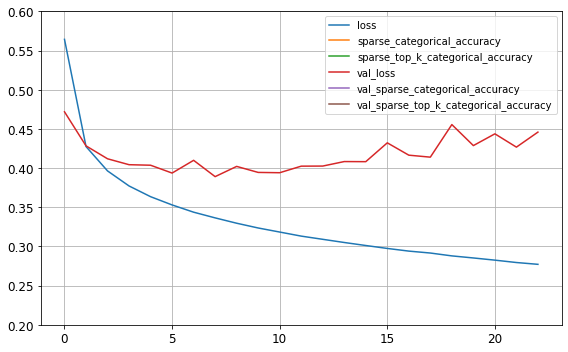

Saving figure model_1_7_learning_curves_plot_accuracy


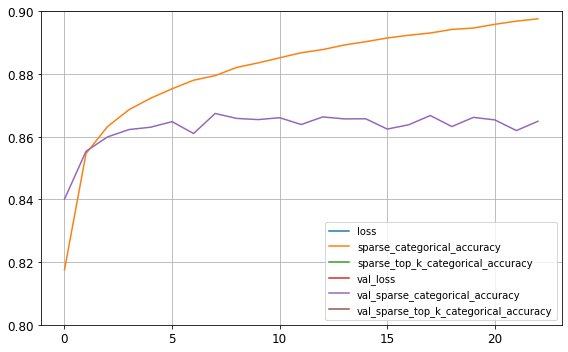

In [381]:
pd.DataFrame(history_1_7.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.2, 0.6)
save_fig("model_1_7_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_7.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 0.9)
save_fig("model_1_7_learning_curves_plot_accuracy")
plt.show()

### 1.8. Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E)

In [67]:
X_train = np.load("./SplittedDatasets/8/X_train_8.npy")
y_train = np.load("./SplittedDatasets/8/y_train_8.npy")

In [68]:
baseline_model_1_8 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [69]:
baseline_model_1_8.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [70]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_8.h5", save_best_only=True)

In [71]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_8"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [72]:
model_1_8_t0 = time.time()
history_1_8 = baseline_model_1_8.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_8_t1 = time.time()

Epoch 1/100
16913/16913 [==============================] - 393s 23ms/step - loss: 0.3211 - sparse_categorical_accuracy: 0.8928 - sparse_top_k_categorical_accuracy: 0.9766 - val_loss: 0.2519 - val_sparse_categorical_accuracy: 0.9128 - val_sparse_top_k_categorical_accuracy: 0.9833
Epoch 2/100
16913/16913 [==============================] - 408s 24ms/step - loss: 0.2223 - sparse_categorical_accuracy: 0.9205 - sparse_top_k_categorical_accuracy: 0.9873 - val_loss: 0.2074 - val_sparse_categorical_accuracy: 0.9243 - val_sparse_top_k_categorical_accuracy: 0.9900
Epoch 3/100
16913/16913 [==============================] - 410s 24ms/step - loss: 0.1939 - sparse_categorical_accuracy: 0.9291 - sparse_top_k_categorical_accuracy: 0.9927 - val_loss: 0.2032 - val_sparse_categorical_accuracy: 0.9263 - val_sparse_top_k_categorical_accuracy: 0.9940
Epoch 4/100
16913/16913 [==============================] - 410s 24ms/step - loss: 0.1752 - sparse_categorical_accuracy: 0.9350 - sparse_top_k_categorical_accura

In [73]:
print("Training took {:.2f}s for all Epochs".format(model_1_8_t1 - model_1_8_t0))

Training took 9403.93s for all Epochs


In [74]:
history_1_8.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [75]:
print("Best Training Accuracy: ", round(history_1_8.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_8.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_8.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_8.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_8.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_8.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.94659
Best Training Loss:  0.13781
Best Training Top k Accuracy:  0.99785
Best Validation Accuracy:  0.93613
Best Validation Loss:  0.17958
Best Validation Top k Accuracy:  0.99531


In [76]:
baseline_model_1_8.save("./Model_Checkpoints/baseline_model_1_8")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_8\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_8\assets


In [77]:
np.save('./Histories/history_1_8.npy', history_1_8.history)

Saving figure model_1_8_learning_curves_plot_loss


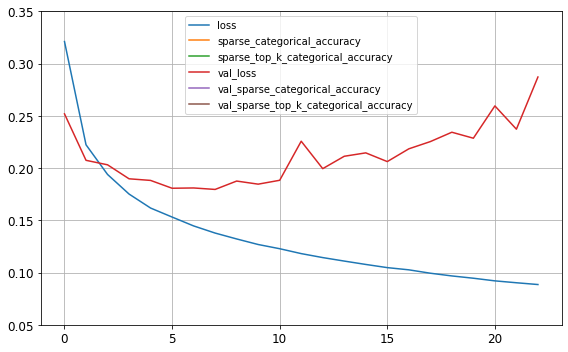

Saving figure model_1_8_learning_curves_plot_accuracy


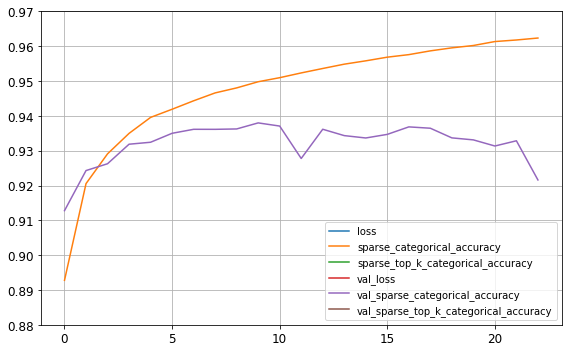

In [307]:
pd.DataFrame(history_1_8.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.05, 0.35)
save_fig("model_1_8_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_8.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.88, 0.97)
save_fig("model_1_8_learning_curves_plot_accuracy")
plt.show()

### 1.9. Model for Combination of (Zoomed NIST19 (Keras) + Original T-H-E + Padded T-H-E)

In [79]:
X_train = np.load("./SplittedDatasets/9/X_train_9.npy")
y_train = np.load("./SplittedDatasets/9/y_train_9.npy")

In [80]:
baseline_model_1_9 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [81]:
baseline_model_1_9.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [82]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_9.h5", save_best_only=True)

In [83]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_9"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [84]:
model_1_9_t0 = time.time()
history_1_9 = baseline_model_1_9.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_9_t1 = time.time()

Epoch 1/100
16913/16913 [==============================] - 425s 25ms/step - loss: 1.0311 - sparse_categorical_accuracy: 0.6191 - sparse_top_k_categorical_accuracy: 0.9067 - val_loss: 0.8883 - val_sparse_categorical_accuracy: 0.6532 - val_sparse_top_k_categorical_accuracy: 0.9331
Epoch 2/100
16913/16913 [==============================] - 424s 25ms/step - loss: 0.8485 - sparse_categorical_accuracy: 0.6645 - sparse_top_k_categorical_accuracy: 0.9402 - val_loss: 0.8501 - val_sparse_categorical_accuracy: 0.6607 - val_sparse_top_k_categorical_accuracy: 0.9418
Epoch 3/100
16913/16913 [==============================] - 424s 25ms/step - loss: 0.8060 - sparse_categorical_accuracy: 0.6762 - sparse_top_k_categorical_accuracy: 0.9459 - val_loss: 0.8278 - val_sparse_categorical_accuracy: 0.6644 - val_sparse_top_k_categorical_accuracy: 0.9418
Epoch 4/100
16913/16913 [==============================] - 423s 25ms/step - loss: 0.7811 - sparse_categorical_accuracy: 0.6837 - sparse_top_k_categorical_accura

In [85]:
print("Training took {:.2f}s for all Epochs".format(model_1_9_t1 - model_1_9_t0))

Training took 10615.29s for all Epochs


In [86]:
history_1_9.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [87]:
print("Best Training Accuracy: ", round(history_1_9.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_9.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_9.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_9.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_9.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_9.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.70548
Best Training Loss:  0.70987
Best Training Top k Accuracy:  0.95762
Best Validation Accuracy:  0.68848
Best Validation Loss:  0.78345
Best Validation Top k Accuracy:  0.95028


In [88]:
baseline_model_1_9.save("./Model_Checkpoints/baseline_model_1_9")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_9\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_9\assets


In [89]:
np.save('./Histories/history_1_9.npy', history_1_9.history)

Saving figure model_1_9_learning_curves_plot


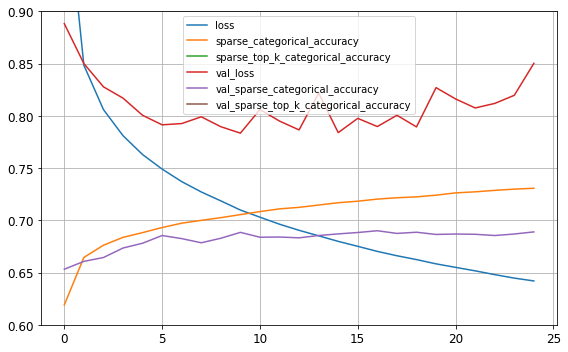

In [309]:
pd.DataFrame(history_1_9.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.6, 0.90)
save_fig("model_1_9_learning_curves_plot")
plt.show()

### 1.10. Comparison between Combinations

In [350]:
x = np.load('./Histories/history_1_1.npy',allow_pickle='TRUE').item()
y = np.load('./Histories/history_1_2.npy',allow_pickle='TRUE').item()

C = type('C', (object,), {})
history_1_1 = C()
history_1_1.history = x

D = type('C', (object,), {})
history_1_2 = D()
history_1_2.history = y

In [351]:
combinations = [
    "Original NIST19 + Original T-H-E",
    "Cropped & Resized NIST19 (OpenCV) + Original T-H-E",
    "Zoomed NIST19 (Keras) + Original T-H-E",
    "Original NIST19 + Padded T-H-E",
    "Cropped & Resized NIST19 (OpenCV) + Padded T-H-E",
    "Zoomed NIST19 (Keras) + Padded T-H-E",
    "Original NIST19 + Original T-H-E + Padded T-H-E",
    "Cropped & Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E",
    "Zoomed NIST19 (Keras) + Original T-H-E + Padded T-H-E"
]

In [352]:
val_losses = [
    history_1_1.history['val_loss'][-16],
    history_1_2.history['val_loss'][-16],
    history_1_3.history['val_loss'][-16],
    history_1_4.history['val_loss'][-16],
    history_1_5.history['val_loss'][-16],
    history_1_6.history['val_loss'][-16],
    history_1_7.history['val_loss'][-16],
    history_1_8.history['val_loss'][-16],
    history_1_9.history['val_loss'][-16]
]

val_loss_data = {
    'Combinations': combinations,
    'Validation Losses (Lower is better)': val_losses
}
val_loss_df = pd.DataFrame(val_loss_data)

Saving figure Validation Losses between Combinations


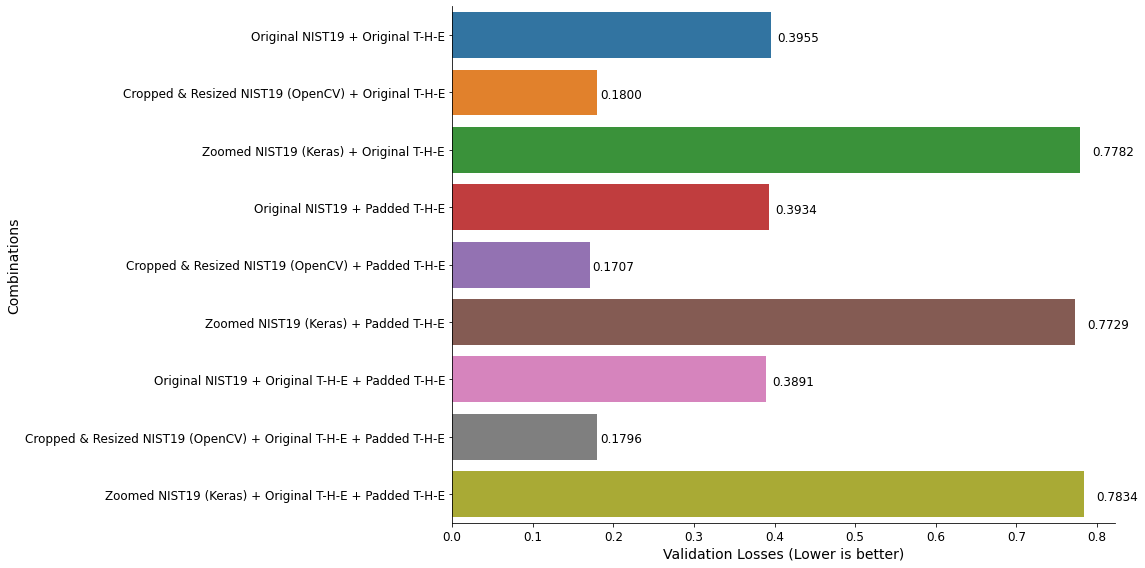

In [353]:
val_loss_catplot = sns.catplot(y="Combinations", x="Validation Losses (Lower is better)", kind="bar", height=8, aspect=2, orient='h',  data=val_loss_df)
val_loss_catplot.set_yticklabels(fontsize=12, rotation=0)
val_loss_catplot.set_xticklabels(fontsize=12, rotation=0)
ax5 = val_loss_catplot.facet_axis(0,0)
for p in ax5.patches:
    ax5.text( p.get_width() * 1.02,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validation Losses between Combinations', tight_layout=True)

In [354]:
val_accuracies = [
    history_1_1.history['val_sparse_categorical_accuracy'][-16],
    history_1_2.history['val_sparse_categorical_accuracy'][-16],
    history_1_3.history['val_sparse_categorical_accuracy'][-16],
    history_1_4.history['val_sparse_categorical_accuracy'][-16],
    history_1_5.history['val_sparse_categorical_accuracy'][-16],
    history_1_6.history['val_sparse_categorical_accuracy'][-16],
    history_1_7.history['val_sparse_categorical_accuracy'][-16],
    history_1_8.history['val_sparse_categorical_accuracy'][-16],
    history_1_9.history['val_sparse_categorical_accuracy'][-16]
]

val_accuracies_data = {
    'Combinations': combinations,
    'Validation Accuracy (Higher is better)': val_accuracies
}
val_accuracies_data_df = pd.DataFrame(val_accuracies_data)

Saving figure Validation Accuracy between Combinations


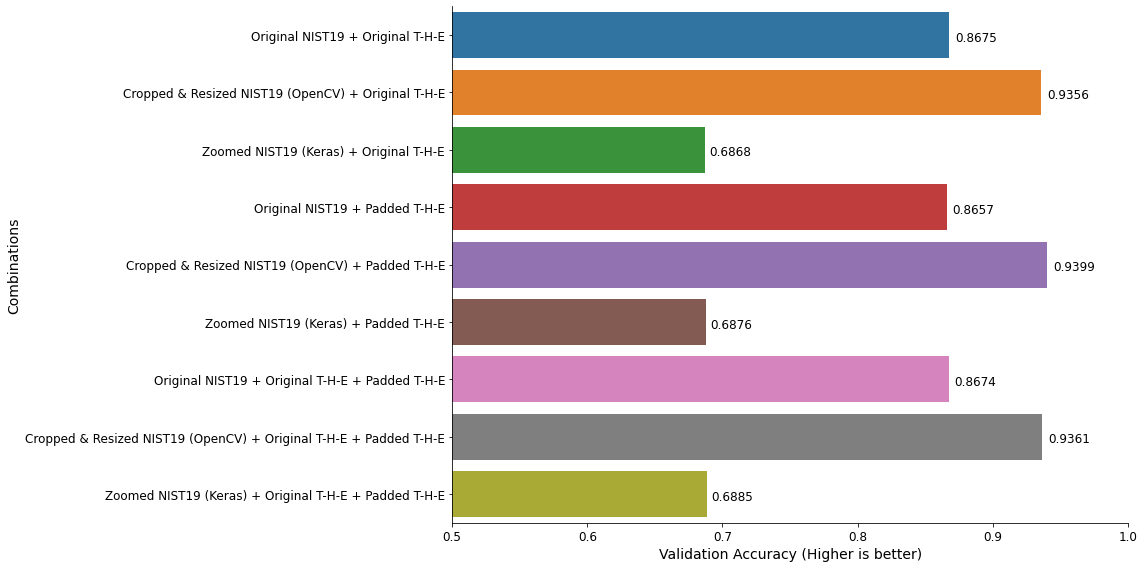

In [355]:
val_accuracies_catplot = sns.catplot(y="Combinations", x="Validation Accuracy (Higher is better)", kind="bar", height=8, aspect=2, orient='h',  data=val_accuracies_data_df)
val_accuracies_catplot.set_yticklabels(fontsize=12, rotation=0)
ax6 = val_accuracies_catplot.facet_axis(0,0)
val_accuracies_catplot.set(xlim=(0.5,1))
for p in ax6.patches:
    ax6.text( p.get_width() * 1.005,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validation Accuracy between Combinations', tight_layout=True)

In [359]:
epoch_train_time = [
    (model_1_1_t1 - model_1_1_t0) / len(history_1_1.history['val_loss']),
    (model_1_2_t1 - model_1_2_t0) / len(history_1_2.history['val_loss']),
    (model_1_3_t1 - model_1_3_t0) / len(history_1_3.history['val_loss']),
    (model_1_4_t1 - model_1_4_t0) / len(history_1_4.history['val_loss']),
    (model_1_5_t1 - model_1_5_t0) / len(history_1_5.history['val_loss']),
    (model_1_6_t1 - model_1_6_t0) / len(history_1_6.history['val_loss']),
    (model_1_7_t1 - model_1_7_t0) / len(history_1_7.history['val_loss']),
    (model_1_8_t1 - model_1_8_t0) / len(history_1_8.history['val_loss']),
    (model_1_9_t1 - model_1_9_t0) / len(history_1_9.history['val_loss'])
]

train_time_data = {
    'Combinations': combinations,
    'Training Time per Epoch (Lower is better)': epoch_train_time
}
train_time_data_df = pd.DataFrame(train_time_data)

Saving figure Training Time Per Epoch between Combinations


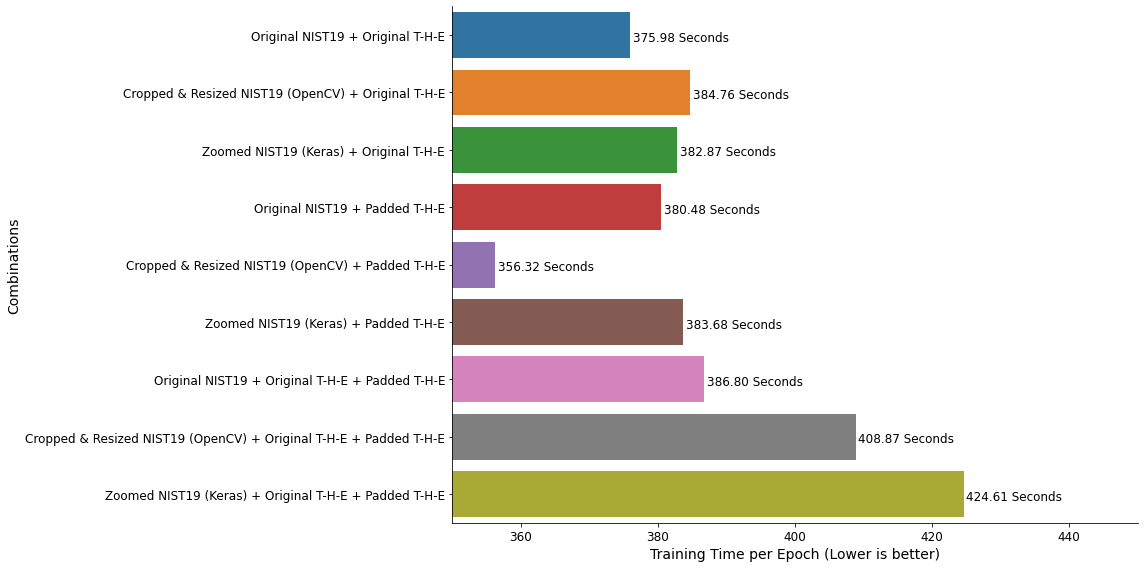

In [364]:
train_time_catplot = sns.catplot(y="Combinations", x="Training Time per Epoch (Lower is better)", kind="bar", height=8, aspect=2, orient='h',  data=train_time_data_df)
train_time_catplot.set_yticklabels(fontsize=12, rotation=0)
ax7 = train_time_catplot.facet_axis(0,0)
train_time_catplot.set(xlim=(350,450))
for p in ax7.patches:
    ax7.text( p.get_width() * 1.001,
            p.get_y() + 0.5,
            '{0:.2f} Seconds'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Training Time Per Epoch between Combinations', tight_layout=True)

In [365]:
combinations_de = [
    "Originaler NIST19 + Originaler T-H-E",
    "Zugeschnitten & reskalierter NIST19 (Mit OpenCV) + Originaler T-H-E",
    "Gezoomter NIST19 (Mit Keras) + Originaler T-H-E",
    "Originaler NIST19 + Wattiert T-H-E",
    "Zugeschnitten & reskalierter NIST19 (Mit OpenCV) + Wattiert T-H-E",
    "Gezoomter NIST19 (Mit Keras) + Wattiert T-H-E",
    "Originaler NIST19 + Originaler T-H-E + Wattiert T-H-E",
    "Zugeschnitten & reskalierter NIST19 (Mit OpenCV) + Originaler T-H-E + Wattiert T-H-E",
    "Gezoomter NIST19 (Mit Keras) + Originaler T-H-E + Wattiert T-H-E"
]

In [366]:
val_losses = [
    history_1_1.history['val_loss'][-16],
    history_1_2.history['val_loss'][-16],
    history_1_3.history['val_loss'][-16],
    history_1_4.history['val_loss'][-16],
    history_1_5.history['val_loss'][-16],
    history_1_6.history['val_loss'][-16],
    history_1_7.history['val_loss'][-16],
    history_1_8.history['val_loss'][-16],
    history_1_9.history['val_loss'][-16]
]

val_loss_data = {
    'Kombinationen': combinations_de,
    'Validierungsverlust (Niedriger ist besser)': val_losses
}
val_loss_df = pd.DataFrame(val_loss_data)

Saving figure Validierungsverluste zwischen Kombinationen


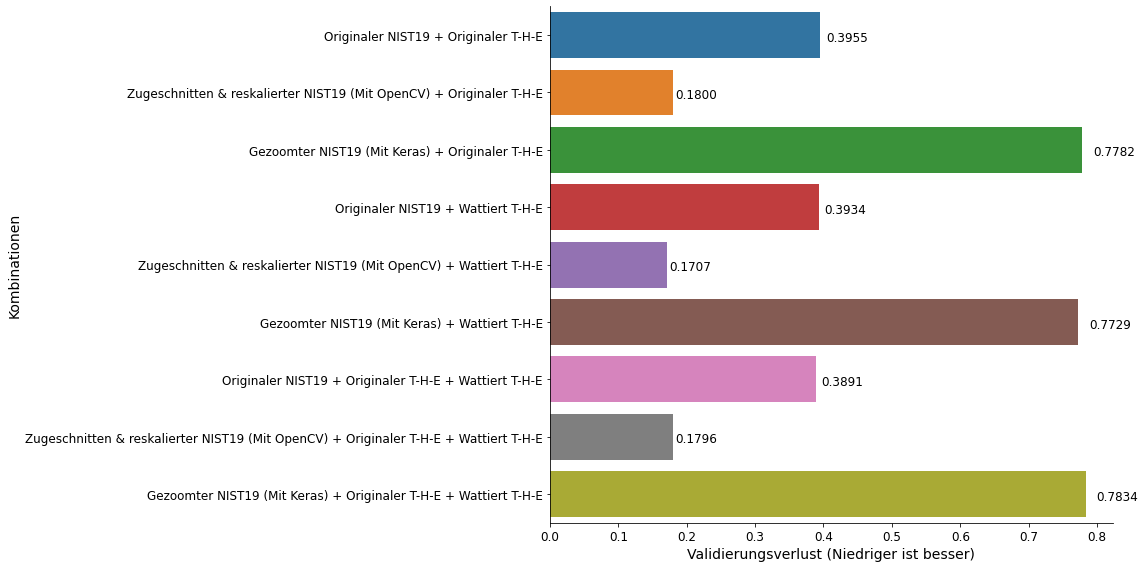

In [367]:
val_loss_catplot = sns.catplot(y="Kombinationen", x="Validierungsverlust (Niedriger ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=val_loss_df)
val_loss_catplot.set_yticklabels(fontsize=12, rotation=0)
val_loss_catplot.set_xticklabels(fontsize=12, rotation=0)
ax5 = val_loss_catplot.facet_axis(0,0)
for p in ax5.patches:
    ax5.text( p.get_width() * 1.02,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validierungsverluste zwischen Kombinationen', tight_layout=True)

In [368]:
val_accuracies = [
    history_1_1.history['val_sparse_categorical_accuracy'][-16],
    history_1_2.history['val_sparse_categorical_accuracy'][-16],
    history_1_3.history['val_sparse_categorical_accuracy'][-16],
    history_1_4.history['val_sparse_categorical_accuracy'][-16],
    history_1_5.history['val_sparse_categorical_accuracy'][-16],
    history_1_6.history['val_sparse_categorical_accuracy'][-16],
    history_1_7.history['val_sparse_categorical_accuracy'][-16],
    history_1_8.history['val_sparse_categorical_accuracy'][-16],
    history_1_9.history['val_sparse_categorical_accuracy'][-16]
]

val_accuracies_data = {
    'Kombinationen': combinations_de,
    'Validierungsgenauigkeit (Höher ist besser)': val_accuracies
}
val_accuracies_data_df = pd.DataFrame(val_accuracies_data)

Saving figure Validierungsgenauigkeit zwischen Kombinationen


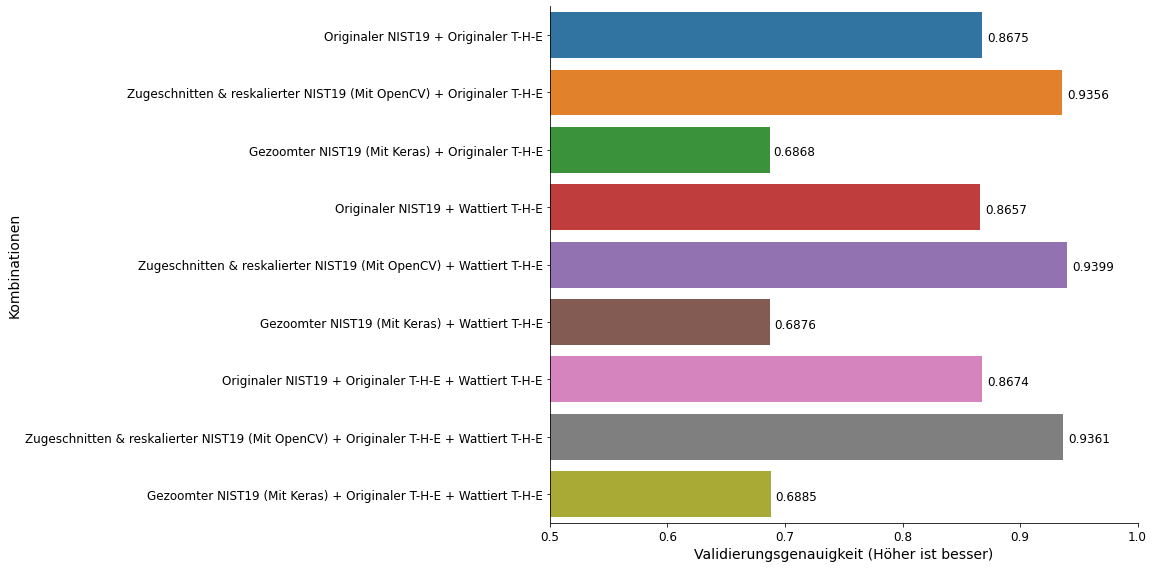

In [369]:
val_accuracies_catplot = sns.catplot(y="Kombinationen", x="Validierungsgenauigkeit (Höher ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=val_accuracies_data_df)
val_accuracies_catplot.set_yticklabels(fontsize=12, rotation=0)
ax6 = val_accuracies_catplot.facet_axis(0,0)
val_accuracies_catplot.set(xlim=(0.5,1))
for p in ax6.patches:
    ax6.text( p.get_width() * 1.005,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validierungsgenauigkeit zwischen Kombinationen', tight_layout=False)

In [370]:
epoch_train_time = [
    (model_1_1_t1 - model_1_1_t0) / len(history_1_1.history['val_loss']),
    (model_1_2_t1 - model_1_2_t0) / len(history_1_2.history['val_loss']),
    (model_1_3_t1 - model_1_3_t0) / len(history_1_3.history['val_loss']),
    (model_1_4_t1 - model_1_4_t0) / len(history_1_4.history['val_loss']),
    (model_1_5_t1 - model_1_5_t0) / len(history_1_5.history['val_loss']),
    (model_1_6_t1 - model_1_6_t0) / len(history_1_6.history['val_loss']),
    (model_1_7_t1 - model_1_7_t0) / len(history_1_7.history['val_loss']),
    (model_1_8_t1 - model_1_8_t0) / len(history_1_8.history['val_loss']),
    (model_1_9_t1 - model_1_9_t0) / len(history_1_9.history['val_loss'])
]

train_time_data = {
    'Kombinationen': combinations_de,
    'Trainingszeit pro Epoche (Niedriger ist besser)': epoch_train_time
}
train_time_data_df = pd.DataFrame(train_time_data)

Saving figure Trainingszeit pro Epoche zwischen Kombinationen


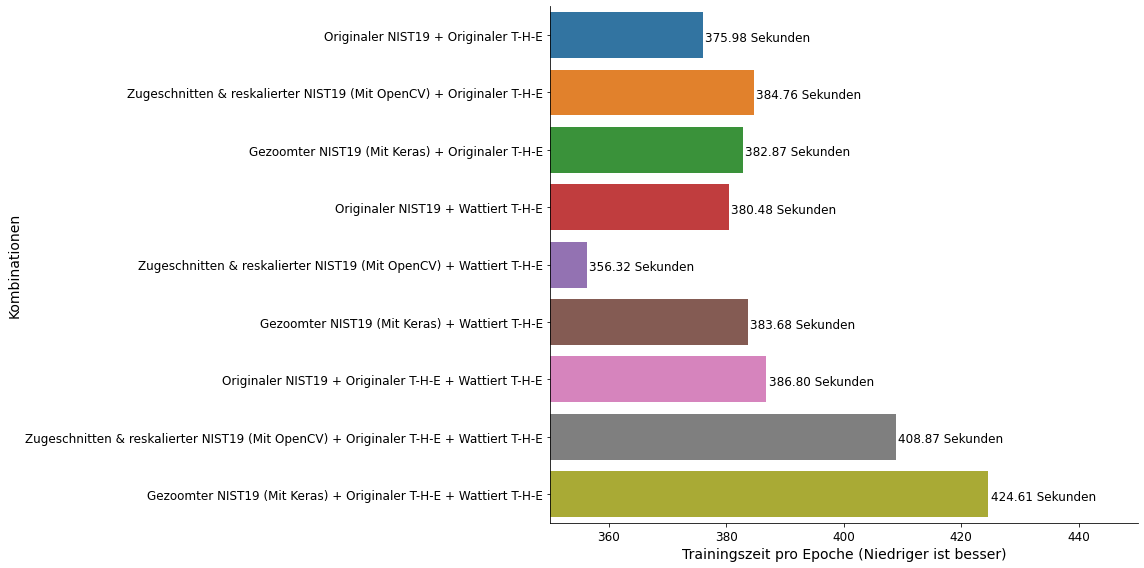

In [371]:
train_time_catplot = sns.catplot(y="Kombinationen", x="Trainingszeit pro Epoche (Niedriger ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=train_time_data_df)
train_time_catplot.set_yticklabels(fontsize=12, rotation=0)
ax7 = train_time_catplot.facet_axis(0,0)
train_time_catplot.set(xlim=(350,450))
for p in ax7.patches:
    ax7.text( p.get_width() * 1.001,
            p.get_y() + 0.5,
            '{0:.2f} Sekunden'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Trainingszeit pro Epoche zwischen Kombinationen', tight_layout=True)

So we can officially say that the combinations 2,5,8 are the best combinations of datasets

In [372]:
y_train = np.load("./SplittedDatasets/1/y_train_1.npy")
y_test = np.load("./SplittedDatasets/1/y_test_1.npy")

In [373]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

Saving figure Combination 1 Training Set Class Distributions


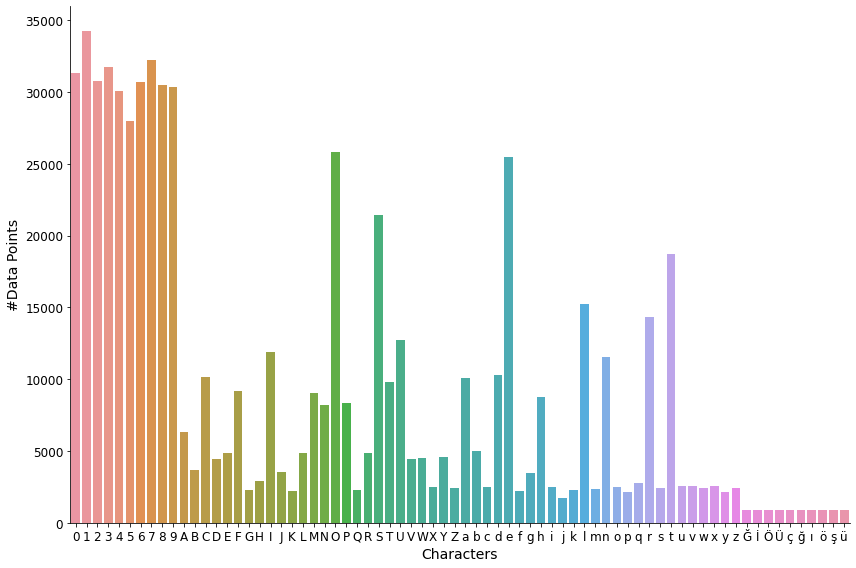

In [374]:
freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 1 Training Set Class Distributions', tight_layout=False)

But as we have seen, the number of digit datapoints is so higher than the number of any another character whether it is turkish or english.

So Let's train the best 3 models and telling them to "pay more attention" to samples from an under-represented classes. This will be done with the use of the `class_weight` argument of the fit function

### 1.11 Training the class_weighted Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E)

In [5]:
X_train = np.load("./SplittedDatasets/2/X_train_2.npy")
y_train = np.load("./SplittedDatasets/2/y_train_2.npy")

In [6]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [7]:
print(class_weights)

[ 0.29596862  0.27072261  0.30132695  0.2918595   0.30810678  0.33156742
  0.30226028  0.28776462  0.30399479  0.3054773   1.46989456  2.5185072
  0.91040214  2.08281847  1.90049713  1.00954209  3.99940682  3.14898947
  0.78160568  2.59972658  4.16657303  1.91304684  1.0273299   1.12589568
  0.3591595   1.11038747  4.01499567  1.89505826  0.43233806  0.94271151
  0.72819299  2.08048137  2.04966283  3.7716131   2.02459598  3.81821458
  0.92006997  1.85560949  3.68906685  0.9018995   0.36399643  4.13129456
  2.68324891  1.06046957  3.69494819  5.38363821  4.02021899  0.608189
  3.91000633  0.80126404  3.7306338   4.28996992  3.30621434  0.64644202
  3.81821458  0.49538447  3.63126714  3.60865123  3.81664265  3.65272853
  4.36675695  3.77930086 10.30069444 10.30069444 10.30069444 10.30069444
 10.30069444 10.30069444 10.30069444 10.30069444 10.30069444 10.30069444]


The problem is that the sklearn API returns a numpy array but the keras requires a dictionary as an input for class_weight

More Information on: https://stackoverflow.com/questions/61261907/on-colab-class-weight-is-causing-a-valueerror-the-truth-value-of-an-array-wit

In [8]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [9]:
print(class_weights)

{0: 0.29596861730996393, 1: 0.27072260834014716, 2: 0.3013269518299421, 3: 0.2918594950258154, 4: 0.3081067832098109, 5: 0.33156741773962806, 6: 0.30226027843891623, 7: 0.2877646200645642, 8: 0.303994786201469, 9: 0.3054772966917095, 10: 1.4698945615982242, 11: 2.518507199130671, 12: 0.9104021408229402, 13: 2.082818467760054, 14: 1.9004971299712996, 15: 1.009542088642056, 16: 3.9994068162208802, 17: 3.148989470108696, 18: 0.7816056824888289, 19: 2.5997265844083004, 20: 4.1665730337078655, 21: 1.913046842756913, 22: 1.0273298980496455, 23: 1.1258956764634442, 24: 0.3591594994576166, 25: 1.1103874715534794, 26: 4.0149956691208315, 27: 1.8950582583810303, 28: 0.43233805904024625, 29: 0.9427115110839943, 30: 0.7281929934804807, 31: 2.0804813734290843, 32: 2.0496628344019454, 33: 3.771613100081367, 34: 2.0245959816553833, 35: 3.818214579901153, 36: 0.9200699682413657, 37: 1.8556094875900722, 38: 3.689066852367688, 39: 0.9018995038427863, 40: 0.36399642702893714, 41: 4.131294563279857, 42: 2

In [10]:
baseline_model_11 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [11]:
baseline_model_11.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [12]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_11.h5", save_best_only=True)

In [13]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_11"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [14]:
model_1_11_t0 = time.time()
history_1_11 = baseline_model_11.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_11_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 381s 23ms/step - loss: 0.6885 - sparse_categorical_accuracy: 0.8587 - sparse_top_k_categorical_accuracy: 0.9683 - val_loss: 0.3079 - val_sparse_categorical_accuracy: 0.8921 - val_sparse_top_k_categorical_accuracy: 0.9799
Epoch 2/100
16688/16688 [==============================] - 382s 23ms/step - loss: 0.5438 - sparse_categorical_accuracy: 0.8983 - sparse_top_k_categorical_accuracy: 0.9825 - val_loss: 0.2863 - val_sparse_categorical_accuracy: 0.8953 - val_sparse_top_k_categorical_accuracy: 0.9827
Epoch 3/100
16688/16688 [==============================] - 385s 23ms/step - loss: 0.5114 - sparse_categorical_accuracy: 0.9067 - sparse_top_k_categorical_accuracy: 0.9846 - val_loss: 0.3186 - val_sparse_categorical_accuracy: 0.8878 - val_sparse_top_k_categorical_accuracy: 0.9804
Epoch 4/100
16688/16688 [==============================] - 387s 23ms/step - loss: 0.4926 - sparse_categorical_accuracy: 0.9119 - sparse_top_k_categorical_accura

In [15]:
print("Training took {:.2f}s for all Epochs".format(model_1_11_t1 - model_1_11_t0))

Training took 9342.98s for all Epochs


In [16]:
history_1_11.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [17]:
print("Best Training Accuracy: ", round(history_1_11.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_11.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_11.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_11.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_11.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_11.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.92419
Best Training Loss:  0.4453
Best Training Top k Accuracy:  0.98776
Best Validation Accuracy:  0.91905
Best Validation Loss:  0.23672
Best Validation Top k Accuracy:  0.98566


In [18]:
baseline_model_11.save("./Model_Checkpoints/baseline_model_1_11")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_11\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_11\assets


In [19]:
np.save('./Histories/history_1_11.npy', history_1_11.history)

Saving figure model_1_11_learning_curves_plot_loss


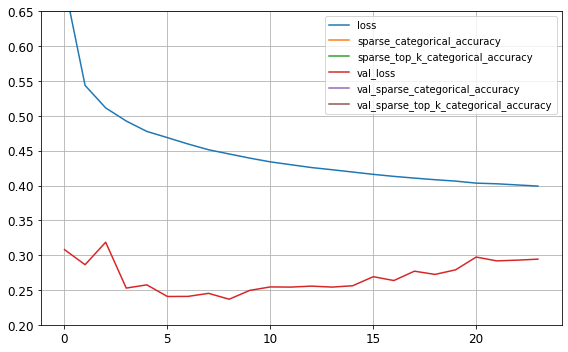

Saving figure model_1_11_learning_curves_plot_accuracy


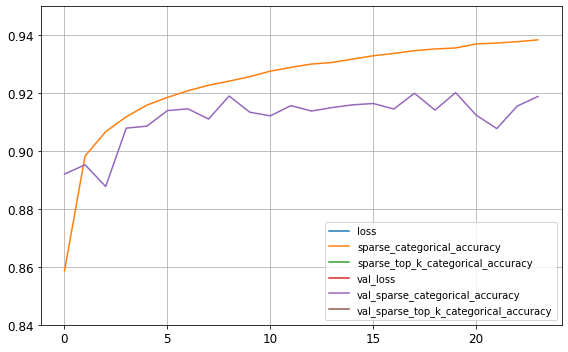

In [20]:
pd.DataFrame(history_1_11.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.2, 0.65)
save_fig("model_1_11_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_11.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.84, 0.95)
save_fig("model_1_11_learning_curves_plot_accuracy")
plt.show()

### 1.12 Training the class_weighted Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Padded T-H-E)

In [63]:
X_train = np.load("./SplittedDatasets/5/X_train_5.npy")
y_train = np.load("./SplittedDatasets/5/y_train_5.npy")

In [64]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [65]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [91]:
baseline_model_12 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [92]:
baseline_model_12.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [93]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_12.h5", save_best_only=True)

In [94]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_12"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [95]:
model_1_12_t0 = time.time()
history_1_12 = baseline_model_12.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_12_t1 = time.time()

Epoch 1/100
16688/16688 [==============================] - 417s 25ms/step - loss: 0.4638 - sparse_categorical_accuracy: 0.8601 - sparse_top_k_categorical_accuracy: 0.9742 - val_loss: 0.2791 - val_sparse_categorical_accuracy: 0.9015 - val_sparse_top_k_categorical_accuracy: 0.9893
Epoch 2/100
16688/16688 [==============================] - 415s 25ms/step - loss: 0.2796 - sparse_categorical_accuracy: 0.9043 - sparse_top_k_categorical_accuracy: 0.9909 - val_loss: 0.2698 - val_sparse_categorical_accuracy: 0.9022 - val_sparse_top_k_categorical_accuracy: 0.9910
Epoch 3/100
16688/16688 [==============================] - 416s 25ms/step - loss: 0.2411 - sparse_categorical_accuracy: 0.9131 - sparse_top_k_categorical_accuracy: 0.9930 - val_loss: 0.2603 - val_sparse_categorical_accuracy: 0.9102 - val_sparse_top_k_categorical_accuracy: 0.9913
Epoch 4/100
16688/16688 [==============================] - 414s 25ms/step - loss: 0.2187 - sparse_categorical_accuracy: 0.9186 - sparse_top_k_categorical_accura

In [96]:
print("Training took {:.2f}s for all Epochs".format(model_1_12_t1 - model_1_12_t0))

Training took 9560.89s for all Epochs


In [97]:
history_1_12.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [98]:
print("Best Training Accuracy: ", round(history_1_12.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_12.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_12.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_12.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_12.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_12.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.92927
Best Training Loss:  0.17168
Best Training Top k Accuracy:  0.99633
Best Validation Accuracy:  0.92416
Best Validation Loss:  0.21084
Best Validation Top k Accuracy:  0.99436


In [99]:
baseline_model_12.save("./Model_Checkpoints/baseline_model_1_12")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_12\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_12\assets


In [100]:
np.save('./Histories/history_1_12.npy', history_1_12.history)

Saving figure model_1_12_learning_curves_plot_loss


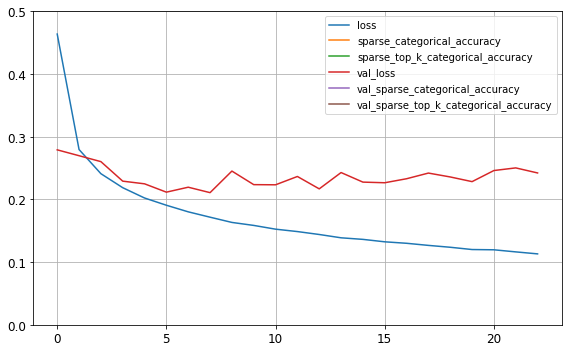

Saving figure model_1_12_learning_curves_plot_accuracy


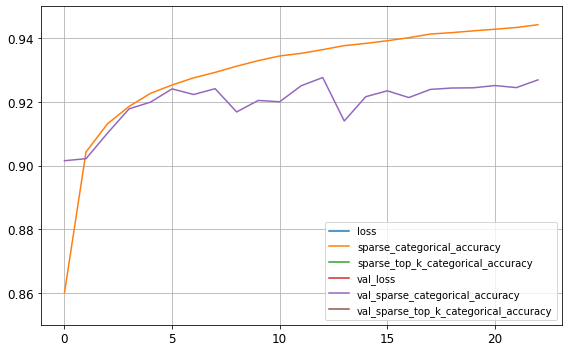

In [101]:
pd.DataFrame(history_1_12.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.0, 0.5)
save_fig("model_1_12_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_12.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.85, 0.95)
save_fig("model_1_12_learning_curves_plot_accuracy")
plt.show()

### 1.13 Training the class_weighted Model for Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E)

In [35]:
X_train = np.load("./SplittedDatasets/8/X_train_8.npy")
y_train = np.load("./SplittedDatasets/8/y_train_8.npy")

In [36]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [37]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [38]:
baseline_model_13 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [39]:
baseline_model_13.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [40]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_1_13.h5", save_best_only=True)

In [41]:
root_logdir = "./Tensorboard_Logs/baseline_model_1_13"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [42]:
model_1_13_t0 = time.time()
history_1_13 = baseline_model_13.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_split=0.2, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_1_13_t1 = time.time()

Epoch 1/100
16913/16913 [==============================] - 400s 24ms/step - loss: 0.5765 - sparse_categorical_accuracy: 0.8536 - sparse_top_k_categorical_accuracy: 0.9670 - val_loss: 0.3272 - val_sparse_categorical_accuracy: 0.8846 - val_sparse_top_k_categorical_accuracy: 0.9799
Epoch 2/100
16913/16913 [==============================] - 400s 24ms/step - loss: 0.3977 - sparse_categorical_accuracy: 0.8955 - sparse_top_k_categorical_accuracy: 0.9846 - val_loss: 0.2630 - val_sparse_categorical_accuracy: 0.9057 - val_sparse_top_k_categorical_accuracy: 0.9886
Epoch 3/100
16913/16913 [==============================] - 401s 24ms/step - loss: 0.3145 - sparse_categorical_accuracy: 0.9075 - sparse_top_k_categorical_accuracy: 0.9914 - val_loss: 0.2583 - val_sparse_categorical_accuracy: 0.9045 - val_sparse_top_k_categorical_accuracy: 0.9918
Epoch 4/100
16913/16913 [==============================] - 402s 24ms/step - loss: 0.2702 - sparse_categorical_accuracy: 0.9141 - sparse_top_k_categorical_accura

In [43]:
print("Training took {:.2f}s for all Epochs".format(model_1_13_t1 - model_1_13_t0 - 11646.0))

Training took -1787.63s for all Epochs


In [44]:
history_1_13.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [45]:
print("Best Training Accuracy: ", round(history_1_13.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_1_13.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_1_13.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_1_13.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_1_13.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_1_13.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.92855
Best Training Loss:  0.19633
Best Training Top k Accuracy:  0.99619
Best Validation Accuracy:  0.92738
Best Validation Loss:  0.20479
Best Validation Top k Accuracy:  0.99448


In [46]:
baseline_model_13.save("./Model_Checkpoints/baseline_model_1_13")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_13\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_1_13\assets


In [47]:
np.save('./Histories/history_1_13.npy', history_1_13.history)

Saving figure model_1_13_learning_curves_plot_loss


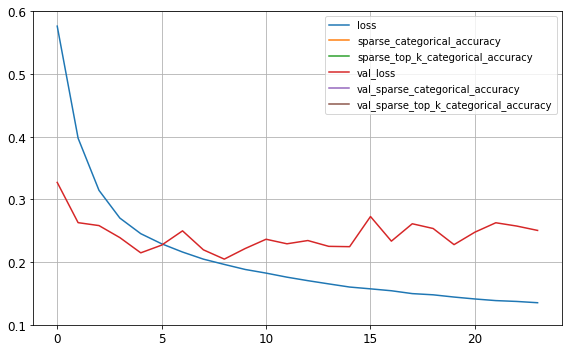

Saving figure model_1_13_learning_curves_plot_accuracy


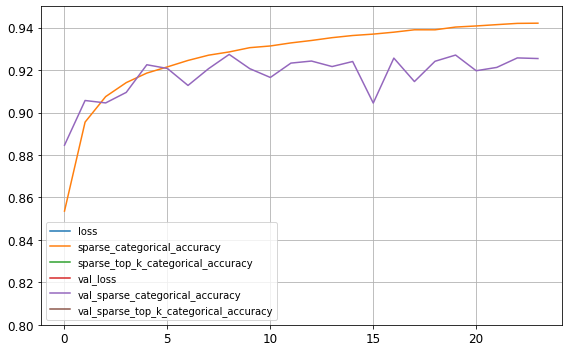

In [48]:
pd.DataFrame(history_1_13.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 0.6)
save_fig("model_1_13_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_1_13.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.80, 0.95)
save_fig("model_1_13_learning_curves_plot_accuracy")
plt.show()

### 1.14. Comparison between class-weighted Combinations

In [102]:
cw_combinations = [
    "Class-weigted Combination 2",
    "Class-weigted Combination 5",
    "Class-weigted Combination 8"
]

In [103]:
cw_val_losses = [
    history_1_11.history['val_loss'][-16],
    history_1_12.history['val_loss'][-16],
    history_1_13.history['val_loss'][-16]
]

cw_val_loss_data = {
    'Combinations': cw_combinations,
    'Validation Losses (Lower is better)': cw_val_losses
}
cw_val_loss_df = pd.DataFrame(cw_val_loss_data)

Saving figure Validation Losses between class-weighted Combinations


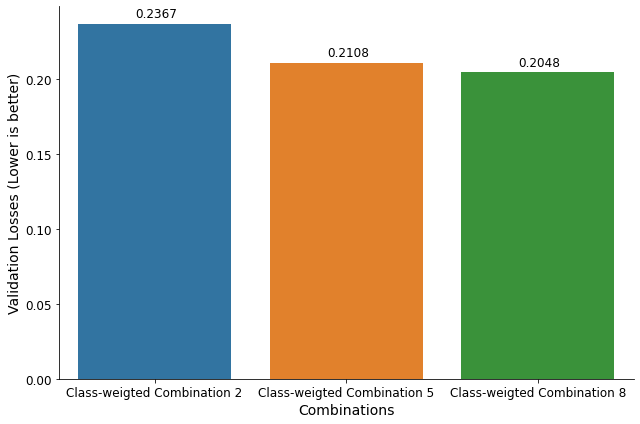

In [104]:
cw_val_loss_catplot = sns.catplot(x="Combinations", y="Validation Losses (Lower is better)", kind="bar", height=6, aspect=1.5, orient='v',  data=cw_val_loss_df)
cw_val_loss_catplot.set_yticklabels(fontsize=12, rotation=0)
cw_val_loss_catplot.set_xticklabels(fontsize=12, rotation=0)
ax5 = cw_val_loss_catplot.facet_axis(0,0)
for p in ax5.patches:
    ax5.text( p.get_x() + 0.3,
            p.get_height() * 1.02,
            '{0:.4f}'.format(p.get_height()),
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validation Losses between class-weighted Combinations', tight_layout=True)

In [105]:
cw_val_accuracies = [
    history_1_11.history['val_sparse_categorical_accuracy'][-16],
    history_1_12.history['val_sparse_categorical_accuracy'][-16],
    history_1_13.history['val_sparse_categorical_accuracy'][-16]
]

cw_val_accuracies_data = {
    'Combinations': cw_combinations,
    'Validation Accuracy (Higher is better)': cw_val_accuracies
}
cw_val_accuracies_data_df = pd.DataFrame(cw_val_accuracies_data)

Saving figure Validation Accuracy between class-weighted Combinations


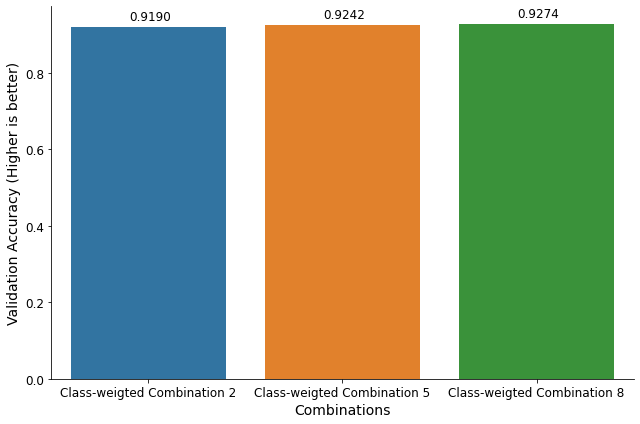

In [106]:
cw_val_accuracies_catplot = sns.catplot(x="Combinations", y="Validation Accuracy (Higher is better)", kind="bar", height=6, aspect=1.5, orient='v',  data=cw_val_accuracies_data_df)
cw_val_accuracies_catplot.set_yticklabels(fontsize=12, rotation=0)
ax6 = cw_val_accuracies_catplot.facet_axis(0,0)
for p in ax6.patches:
    ax6.text( p.get_x() + 0.3,
            p.get_height() * 1.02,
            '{0:.4f}'.format(p.get_height()),
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validation Accuracy between class-weighted Combinations', tight_layout=True)

In [107]:
cw_epoch_train_time = [
    (model_1_11_t1 - model_1_11_t0) / len(history_1_11.history['val_loss']),
    (model_1_12_t1 - model_1_12_t0) / len(history_1_12.history['val_loss']),
    (model_1_13_t1 - model_1_13_t0) / len(history_1_13.history['val_loss'])
]

cw_train_time_data = {
    'Combinations': cw_combinations,
    'Training Time per Epoch (Lower is better)': cw_epoch_train_time
}
cw_train_time_data_df = pd.DataFrame(cw_train_time_data)

Saving figure Training Time Per Epoch between class-weighted Combinations


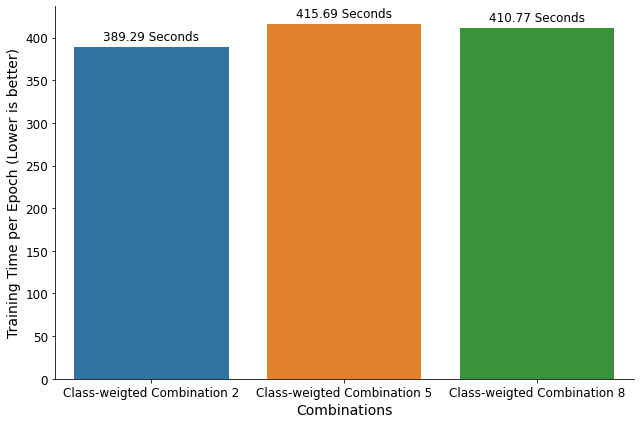

In [108]:
cw_train_time_catplot = sns.catplot(x="Combinations", y="Training Time per Epoch (Lower is better)", kind="bar", height=6, aspect=1.5, orient='v',  data=cw_train_time_data_df)
ax7 = cw_train_time_catplot.facet_axis(0,0)
cw_train_time_catplot.set_yticklabels(fontsize=12, rotation=0)
for p in ax7.patches:
    ax7.text( p.get_x() + 0.15,
            p.get_height() * 1.02,
            '{0:.2f} Seconds'.format(p.get_height()),
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Training Time Per Epoch between class-weighted Combinations', tight_layout=True)

In [109]:
cw_combinations_de = [
    "Klassengewichteten 2. Kombination",
    "Klassengewichteten 5. Kombination",
    "Klassengewichteten 8. Kombination"
]

In [110]:
cw_val_losses = [
    history_1_11.history['val_loss'][-16],
    history_1_12.history['val_loss'][-16],
    history_1_13.history['val_loss'][-16]
]

cw_val_loss_data = {
    'Kombinationen': cw_combinations_de,
    'Validierungsverlust (Niedriger ist besser)': cw_val_losses
}
cw_val_loss_df = pd.DataFrame(cw_val_loss_data)

Saving figure Validierungsverluste zwischen klassengewichteten Kombinationen


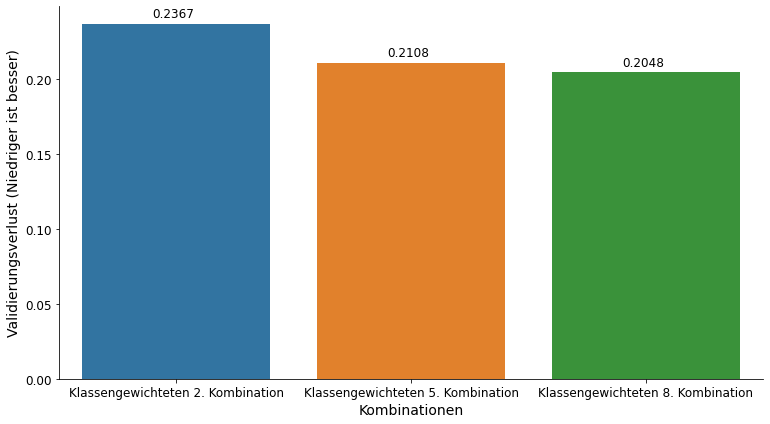

In [111]:
cw_val_loss_catplot = sns.catplot(x="Kombinationen", y="Validierungsverlust (Niedriger ist besser)", kind="bar", height=6, aspect=1.8, orient='v',  data=cw_val_loss_df)
cw_val_loss_catplot.set_yticklabels(fontsize=12, rotation=0)
cw_val_loss_catplot.set_xticklabels(fontsize=12, rotation=0)
ax5 = cw_val_loss_catplot.facet_axis(0,0)
for p in ax5.patches:
    ax5.text( p.get_x() + 0.3,
            p.get_height() * 1.02,
            '{0:.4f}'.format(p.get_height()),
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validierungsverluste zwischen klassengewichteten Kombinationen', tight_layout=True)

In [112]:
cw_val_accuracies = [
    history_1_11.history['val_sparse_categorical_accuracy'][-16],
    history_1_12.history['val_sparse_categorical_accuracy'][-16],
    history_1_13.history['val_sparse_categorical_accuracy'][-16]
]

cw_val_accuracies_data = {
    'Kombinationen': cw_combinations_de,
    'Validierungsgenauigkeit (Höher ist besser)': cw_val_accuracies
}
cw_val_accuracies_data_df = pd.DataFrame(cw_val_accuracies_data)

Saving figure Validierungsgenauigkeit zwischen klassengewichteten Kombinationen


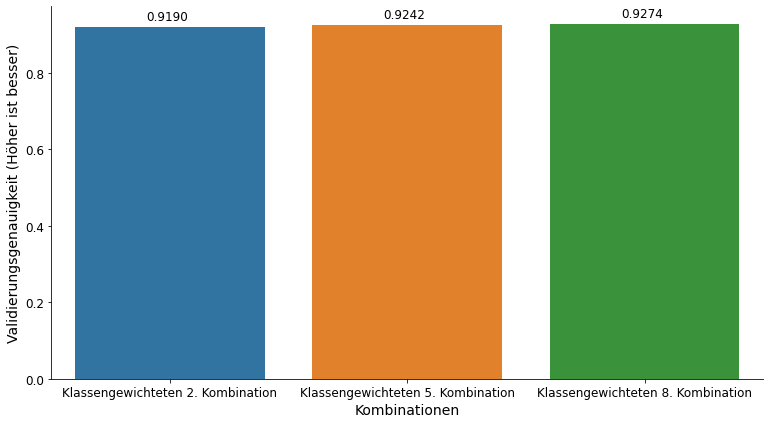

In [113]:
cw_val_accuracies_catplot = sns.catplot(x="Kombinationen", y="Validierungsgenauigkeit (Höher ist besser)", kind="bar", height=6, aspect=1.8, orient='v',  data=cw_val_accuracies_data_df)
cw_val_accuracies_catplot.set_yticklabels(fontsize=12, rotation=0)
ax6 = cw_val_accuracies_catplot.facet_axis(0,0)
for p in ax6.patches:
    ax6.text( p.get_x() + 0.3,
            p.get_height() * 1.02,
            '{0:.4f}'.format(p.get_height()),
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validierungsgenauigkeit zwischen klassengewichteten Kombinationen', tight_layout=True)

In [114]:
cw_epoch_train_time = [
    (model_1_11_t1 - model_1_11_t0) / len(history_1_11.history['val_loss']),
    (model_1_12_t1 - model_1_12_t0) / len(history_1_12.history['val_loss']),
    (model_1_13_t1 - model_1_13_t0) / len(history_1_13.history['val_loss'])
]

cw_train_time_data = {
    'Kombinationen': cw_combinations_de,
    'Trainingszeit pro Epoche (Niedriger ist besser)': cw_epoch_train_time
}
cw_train_time_data_df = pd.DataFrame(cw_train_time_data)

Saving figure Trainingszeit pro Epoche zwischen klassengewichteten Kombinationen


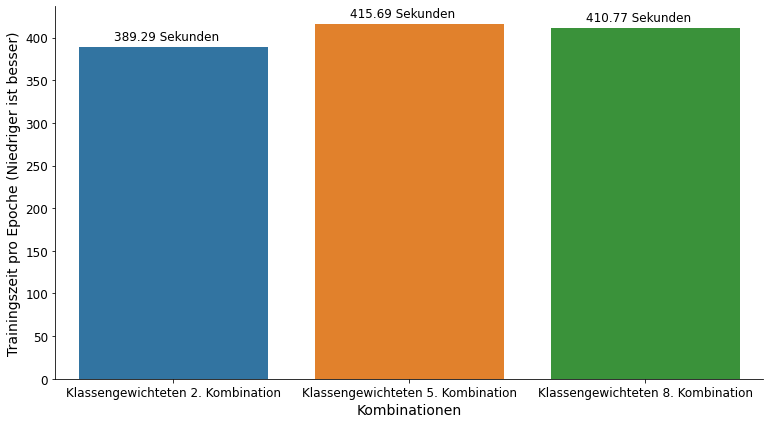

In [115]:
cw_train_time_catplot = sns.catplot(x="Kombinationen", y="Trainingszeit pro Epoche (Niedriger ist besser)", kind="bar", height=6, aspect=1.8, orient='v',  data=cw_train_time_data_df)
ax7 = cw_train_time_catplot.facet_axis(0,0)
cw_train_time_catplot.set_yticklabels(fontsize=12, rotation=0)
for p in ax7.patches:
    ax7.text( p.get_x() + 0.15,
            p.get_height() * 1.02,
            '{0:.2f} Sekunden'.format(p.get_height()),
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Trainingszeit pro Epoche zwischen klassengewichteten Kombinationen', tight_layout=True)

## 2. Resampling the imbalanced datasets with the best performance on the baseline Model

In [5]:
from imblearn.over_sampling import RandomOverSampler #, SMOTE
from imblearn.under_sampling import RandomUnderSampler #, EditedNearestNeighbours, NearMiss
#from imblearn.combine import SMOTEENN, SMOTETomek

### 2.0 Training Models using `Random (Naive) Oversampling Examples (ROSE)` & `Random (Naive) Undersampling Examples (RUSE)` Methods

#### 2.0.1 Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E)

##### 2.0.1.1 Oversampling Turkish Characters in the Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E)

In [6]:
X_train = np.load("./SplittedDatasets/2/X_train_2.npy")
y_train = np.load("./SplittedDatasets/2/y_train_2.npy")

In [ ]:
splitter = StratifiedShuffleSplit(train_size=0.9, test_size=0.1, random_state=42)
for train_index, test_index in splitter.split(X_train, y_train):
    X_train_only, X_val_only = X_train[train_index], X_train[test_index]
    y_train_only, y_val_only = y_train[train_index], y_train[test_index]

In [ ]:
np.save("./SplittedDatasets/2/X_train_only_2.npy", X_train_only)
np.save("./SplittedDatasets/2/y_train_only_2.npy", y_train_only)
np.save("./SplittedDatasets/2/X_val_only_2.npy", X_val_only)
np.save("./SplittedDatasets/2/y_val_only_2.npy", y_val_only)

In [ ]:
print(X_train_only.shape)
X_train_only = np.squeeze(X_train_only, axis=3)
print(X_train_only.shape)
X_train_only = X_train_only.reshape(-1, 784)
print(X_train_only.shape)

(600736, 28, 28, 1)
(600736, 28, 28)
(600736, 784)


Saving figure Combination 2 Training_Only Set class Distributions


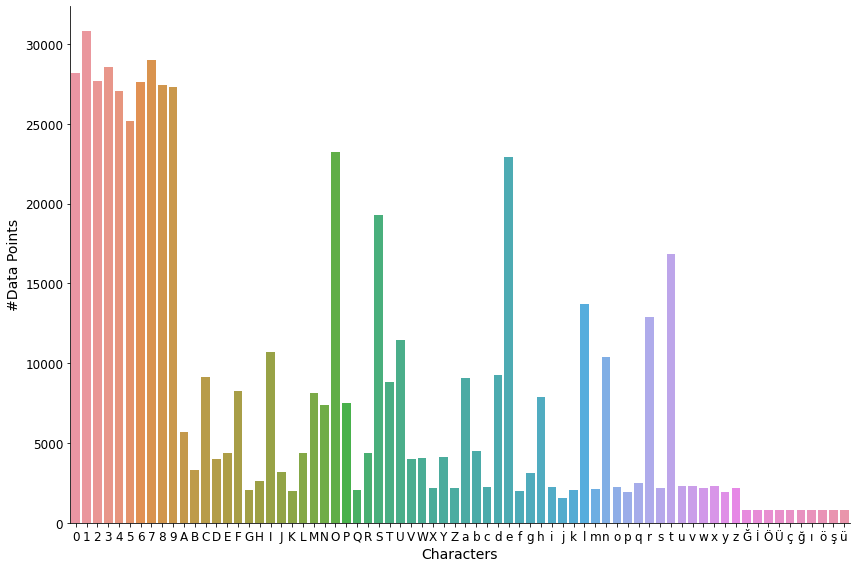

In [ ]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_only == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 2 Training_Only Set class Distributions', tight_layout=True)

In [ ]:
print("The Average is ", statistics.mean(frequecies), " Data points")

The Average is  8343.555555555555  Data points


In [ ]:
random_strategy_dictionary = {}

for i in range(0,72,1):
    if i > 61:
        random_strategy_dictionary[i] = int(np.count_nonzero(y_train_only == i) * 2)
    else:
        random_strategy_dictionary[i] = np.count_nonzero(y_train_only == i)

print(random_strategy_dictionary)

{0: 28191, 1: 30819, 2: 27689, 3: 28588, 4: 27080, 5: 25164, 6: 27604, 7: 28994, 8: 27446, 9: 27313, 10: 5676, 11: 3313, 12: 9165, 13: 4006, 14: 4390, 15: 8265, 16: 2086, 17: 2650, 18: 10675, 19: 3209, 20: 2002, 21: 4361, 22: 8122, 23: 7411, 24: 23231, 25: 7514, 26: 2078, 27: 4403, 28: 19299, 29: 8851, 30: 11458, 31: 4010, 32: 4071, 33: 2212, 34: 4121, 35: 2185, 36: 9068, 37: 4496, 38: 2262, 39: 9251, 40: 22922, 41: 2020, 42: 3109, 43: 7868, 44: 2258, 45: 1550, 46: 2075, 47: 13719, 48: 2134, 49: 10413, 50: 2236, 51: 1945, 52: 2524, 53: 12907, 54: 2185, 55: 16843, 56: 2298, 57: 2312, 58: 2186, 59: 2284, 60: 1911, 61: 2208, 62: 1620, 63: 1620, 64: 1620, 65: 1620, 66: 1620, 67: 1620, 68: 1620, 69: 1620, 70: 1620, 71: 1620}


In [ ]:
randomOversampler = RandomOverSampler(sampling_strategy=random_strategy_dictionary, random_state=42)
X_train_ROSE, y_train_ROSE = randomOversampler.fit_resample(X_train_only, y_train_only)

Saving figure Combination 2 Random Oversampled Training_Only Set class Distributions


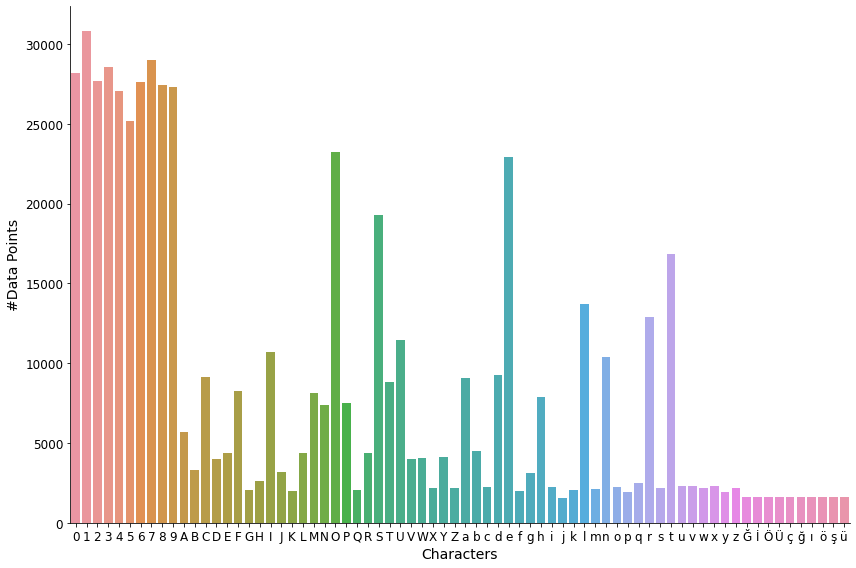

In [ ]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_ROSE == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 2 Random Oversampled Training_Only Set class Distributions', tight_layout=True)

##### 2.0.1.2 Undersampling Digits in the Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E)

In [ ]:
random_strategy_dictionary_updated = {}

for i in range(0,72,1):
    if i < 10:
        random_strategy_dictionary_updated[i] = int(np.count_nonzero(y_train_ROSE == i) / 3)
    else:
        random_strategy_dictionary_updated[i] = np.count_nonzero(y_train_ROSE == i)

print(random_strategy_dictionary_updated)

{0: 9397, 1: 10273, 2: 9229, 3: 9529, 4: 9026, 5: 8388, 6: 9201, 7: 9664, 8: 9148, 9: 9104, 10: 5676, 11: 3313, 12: 9165, 13: 4006, 14: 4390, 15: 8265, 16: 2086, 17: 2650, 18: 10675, 19: 3209, 20: 2002, 21: 4361, 22: 8122, 23: 7411, 24: 23231, 25: 7514, 26: 2078, 27: 4403, 28: 19299, 29: 8851, 30: 11458, 31: 4010, 32: 4071, 33: 2212, 34: 4121, 35: 2185, 36: 9068, 37: 4496, 38: 2262, 39: 9251, 40: 22922, 41: 2020, 42: 3109, 43: 7868, 44: 2258, 45: 1550, 46: 2075, 47: 13719, 48: 2134, 49: 10413, 50: 2236, 51: 1945, 52: 2524, 53: 12907, 54: 2185, 55: 16843, 56: 2298, 57: 2312, 58: 2186, 59: 2284, 60: 1911, 61: 2208, 62: 1620, 63: 1620, 64: 1620, 65: 1620, 66: 1620, 67: 1620, 68: 1620, 69: 1620, 70: 1620, 71: 1620}


In [ ]:
randomUnderSampler = RandomUnderSampler(sampling_strategy=random_strategy_dictionary_updated, random_state=42)
X_train_RUSE, y_train_RUSE = randomUnderSampler.fit_resample(X_train_ROSE, y_train_ROSE)

Saving figure Combination 2 Random Undersampled Training_Only Set class Distributions


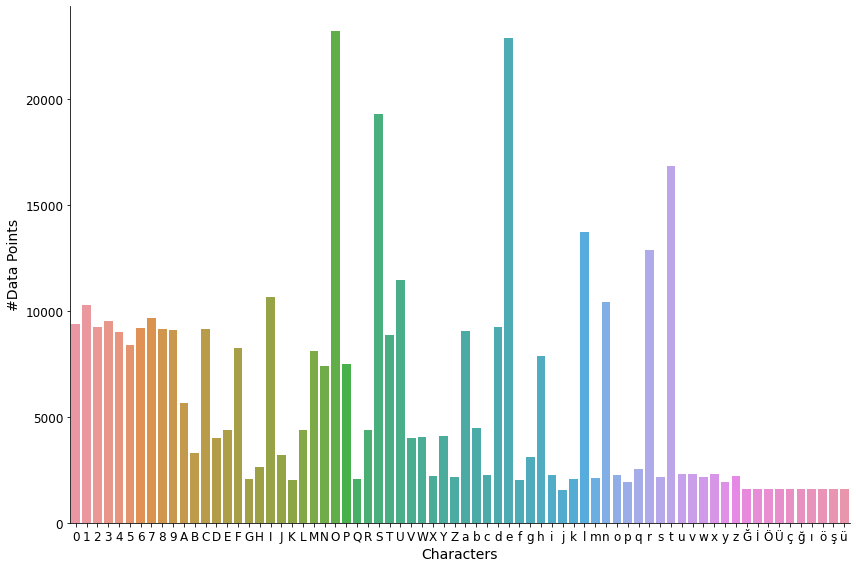

In [ ]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_RUSE == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 2 Random Undersampled Training_Only Set class Distributions', tight_layout=True)

In [ ]:
print(X_train_RUSE.shape)

(422907, 784)


##### 2.0.1.3 Training the baseline on the resampled dataset

In [ ]:
X_train_RUSE, y_train_RUSE = shuffle(X_train_RUSE, y_train_RUSE, random_state=42)

In [ ]:
X_train_RUSE = X_train_RUSE[:, :].reshape(-1, 28, 28)

In [ ]:
# n_rows = 10
# n_cols = 10
# plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
# for row in range(n_rows):
#     for col in range(n_cols):
#         index = n_cols * row + col
#         plt.subplot(n_rows, n_cols, index + 1)
#         plt.imshow(X_train_RUSE[index], cmap="gray", interpolation="nearest")
#         plt.axis('off')
#         plt.title(decodeLabel(int(y_train_RUSE[index])), fontsize=12)
# plt.subplots_adjust(wspace=0.2, hspace=0.5)
# save_fig('Random_Resampled_Combination_2_plot', tight_layout=False)
# plt.show()

In [ ]:
X_train_RUSE = X_train_RUSE[..., np.newaxis]

In [ ]:
np.save("./SplittedDatasets/2/RandomResampling/X_train.npy", X_train_RUSE)
np.save("./SplittedDatasets/2/RandomResampling/y_train.npy", y_train_RUSE)

In [ ]:
baseline_model_2_0_1 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [ ]:
baseline_model_2_0_1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_0_1.h5", save_best_only=True)

In [ ]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_0_1"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
model_2_0_1_t0 = time.time()
history_2_0_1 = baseline_model_2_0_1.fit(X_train_RUSE, y_train_RUSE, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_0_1_t1 = time.time()

Epoch 1/100
13216/13216 [==============================] - 348s 26ms/step - loss: 0.4137 - sparse_categorical_accuracy: 0.8632 - sparse_top_k_categorical_accuracy: 0.9556 - val_loss: 0.2662 - val_sparse_categorical_accuracy: 0.9027 - val_sparse_top_k_categorical_accuracy: 0.9826
Epoch 2/100
13216/13216 [==============================] - 347s 26ms/step - loss: 0.2834 - sparse_categorical_accuracy: 0.8998 - sparse_top_k_categorical_accuracy: 0.9767 - val_loss: 0.2456 - val_sparse_categorical_accuracy: 0.9066 - val_sparse_top_k_categorical_accuracy: 0.9917
Epoch 3/100
13216/13216 [==============================] - 351s 27ms/step - loss: 0.2266 - sparse_categorical_accuracy: 0.9192 - sparse_top_k_categorical_accuracy: 0.9914 - val_loss: 0.2235 - val_sparse_categorical_accuracy: 0.9162 - val_sparse_top_k_categorical_accuracy: 0.9937
Epoch 4/100
13216/13216 [==============================] - 350s 27ms/step - loss: 0.1989 - sparse_categorical_accuracy: 0.9277 - sparse_top_k_categorical_accura

In [175]:
print("Training took {:.2f}s for all Epochs".format(model_2_0_1_t1 - model_2_0_1_t0))

Training took 7026.16s for all Epochs


In [176]:
history_2_0_1.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [177]:
print("Best Training Accuracy: ", round(history_2_0_1.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_0_1.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_0_1.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_0_1.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_0_1.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_0_1.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.93296
Best Training Loss:  0.18104
Best Training Top k Accuracy:  0.99575
Best Validation Accuracy:  0.92352
Best Validation Loss:  0.19988
Best Validation Top k Accuracy:  0.99489


In [178]:
baseline_model_2_0_1.save("./Model_Checkpoints/baseline_model_2_0_1")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_1\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_1\assets


In [179]:
np.save('./Histories/history_2_0_1.npy', history_2_0_1.history)

Saving figure model_2_0_1_learning_curves_plot_loss


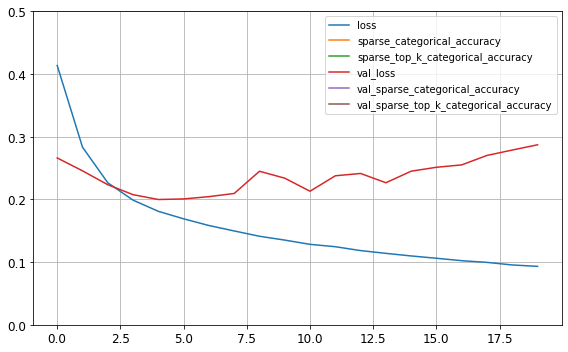

Saving figure model_2_0_1_learning_curves_plot_accuracy


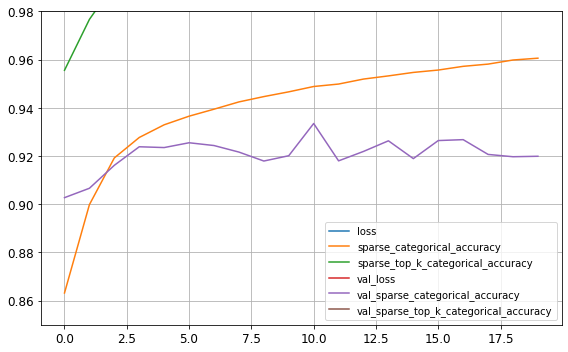

In [180]:
pd.DataFrame(history_2_0_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.5)
save_fig("model_2_0_1_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_0_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.85, 0.98)
save_fig("model_2_0_1_learning_curves_plot_accuracy")
plt.show()

#### 2.0.2 Class-weighted Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E)

In [181]:
X_train = np.load("./SplittedDatasets/2/RandomResampling/X_train.npy")
y_train = np.load("./SplittedDatasets/2/RandomResampling/y_train.npy")
X_val_only = np.load("./SplittedDatasets/2/X_val_only_2.npy")
y_val_only = np.load("./SplittedDatasets/2/y_val_only_2.npy")

In [182]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [183]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [184]:
baseline_model_2_0_2 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [185]:
baseline_model_2_0_2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [186]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_0_2.h5", save_best_only=True)

In [187]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_0_2"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [188]:
model_2_0_2_t0 = time.time()
history_2_0_2 = baseline_model_2_0_2.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_0_2_t1 = time.time()

Epoch 1/100
13216/13216 [==============================] - 351s 26ms/step - loss: 0.6771 - sparse_categorical_accuracy: 0.8340 - sparse_top_k_categorical_accuracy: 0.9501 - val_loss: 0.3395 - val_sparse_categorical_accuracy: 0.8836 - val_sparse_top_k_categorical_accuracy: 0.9777
Epoch 2/100
13216/13216 [==============================] - 352s 27ms/step - loss: 0.4439 - sparse_categorical_accuracy: 0.8825 - sparse_top_k_categorical_accuracy: 0.9811 - val_loss: 0.2922 - val_sparse_categorical_accuracy: 0.9015 - val_sparse_top_k_categorical_accuracy: 0.9895
Epoch 3/100
13216/13216 [==============================] - 353s 27ms/step - loss: 0.3057 - sparse_categorical_accuracy: 0.9026 - sparse_top_k_categorical_accuracy: 0.9917 - val_loss: 0.2788 - val_sparse_categorical_accuracy: 0.8992 - val_sparse_top_k_categorical_accuracy: 0.9904
Epoch 4/100
13216/13216 [==============================] - 351s 27ms/step - loss: 0.2633 - sparse_categorical_accuracy: 0.9102 - sparse_top_k_categorical_accura

In [189]:
print("Training took {:.2f}s for all Epochs".format(model_2_0_2_t1 - model_2_0_2_t0))

Training took 7316.46s for all Epochs


In [190]:
history_2_0_2.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [191]:
print("Best Training Accuracy: ", round(history_2_0_2.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_0_2.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_0_2.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_0_2.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_0_2.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_0_2.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.91963
Best Training Loss:  0.21994
Best Training Top k Accuracy:  0.99562
Best Validation Accuracy:  0.92502
Best Validation Loss:  0.21614
Best Validation Top k Accuracy:  0.99399


In [192]:
baseline_model_2_0_2.save("./Model_Checkpoints/baseline_model_2_0_2")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_2\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_2\assets


In [193]:
np.save('./Histories/history_2_0_2.npy', history_2_0_2.history)

Saving figure model_2_0_2_learning_curves_plot_loss


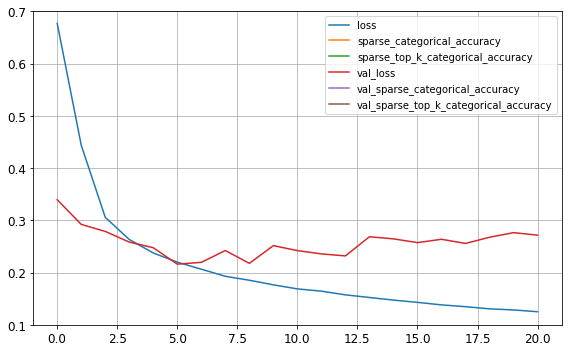

Saving figure model_2_0_2_learning_curves_plot_accuracy


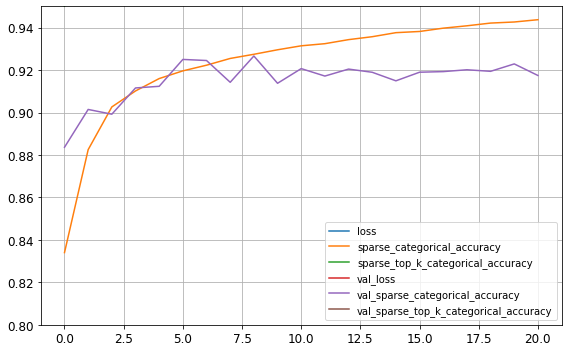

In [194]:
pd.DataFrame(history_2_0_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 0.7)
save_fig("model_2_0_2_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_0_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 0.95)
save_fig("model_2_0_2_learning_curves_plot_accuracy")
plt.show()

#### 2.0.3 Combination of (Cropped And Resized NIST19 (OpenCV) + Padded T-H-E)

##### 2.0.3.1 Oversampling Turkish Characters in the Combination of (Cropped And Resized NIST19 (OpenCV) + Padded T-H-E)

In [195]:
X_train = np.load("./SplittedDatasets/5/X_train_5.npy")
y_train = np.load("./SplittedDatasets/5/y_train_5.npy")

In [196]:
splitter = StratifiedShuffleSplit(train_size=0.9, test_size=0.1, random_state=42)
for train_index, test_index in splitter.split(X_train, y_train):
    X_train_only, X_val_only = X_train[train_index], X_train[test_index]
    y_train_only, y_val_only = y_train[train_index], y_train[test_index]

In [197]:
np.save("./SplittedDatasets/5/X_train_only_5.npy", X_train_only)
np.save("./SplittedDatasets/5/y_train_only_5.npy", y_train_only)
np.save("./SplittedDatasets/5/X_val_only_5.npy", X_val_only)
np.save("./SplittedDatasets/5/y_val_only_5.npy", y_val_only)

In [198]:
print(X_train_only.shape)
X_train_only = np.squeeze(X_train_only, axis=3)
print(X_train_only.shape)
X_train_only = X_train_only.reshape(-1, 784)
print(X_train_only.shape)

(600736, 28, 28, 1)
(600736, 28, 28)
(600736, 784)


Saving figure Combination 5 Training_Only Set class Distributions


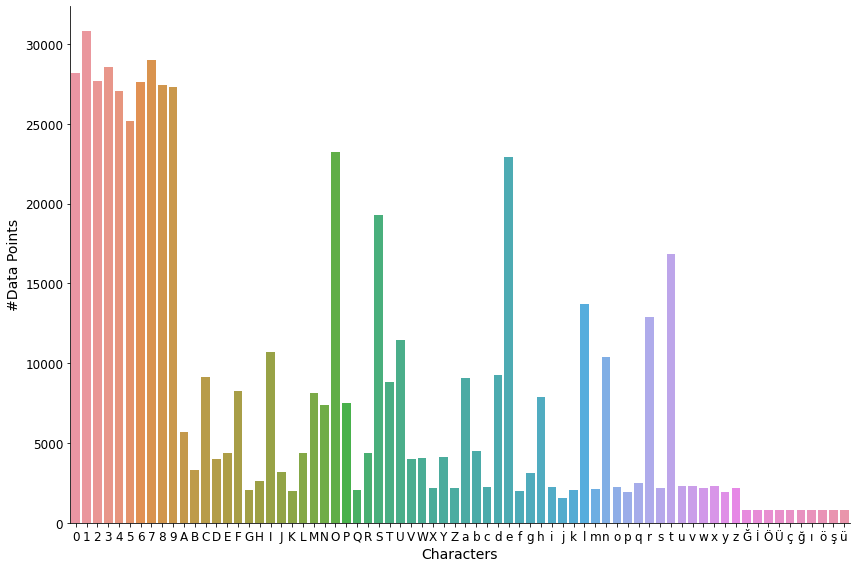

In [199]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_only == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 5 Training_Only Set class Distributions', tight_layout=True)

In [200]:
print("The Average is ", statistics.mean(frequecies), " Data points")

The Average is  8343.555555555555  Data points


In [201]:
random_strategy_dictionary = {}

for i in range(0,72,1):
    if i > 61:
        random_strategy_dictionary[i] = int(np.count_nonzero(y_train_only == i) * 2)
    else:
        random_strategy_dictionary[i] = np.count_nonzero(y_train_only == i)

print(random_strategy_dictionary)

{0: 28191, 1: 30819, 2: 27689, 3: 28588, 4: 27080, 5: 25164, 6: 27604, 7: 28994, 8: 27446, 9: 27313, 10: 5676, 11: 3313, 12: 9165, 13: 4006, 14: 4390, 15: 8265, 16: 2086, 17: 2650, 18: 10675, 19: 3209, 20: 2002, 21: 4361, 22: 8122, 23: 7411, 24: 23231, 25: 7514, 26: 2078, 27: 4403, 28: 19299, 29: 8851, 30: 11458, 31: 4010, 32: 4071, 33: 2212, 34: 4121, 35: 2185, 36: 9068, 37: 4496, 38: 2262, 39: 9251, 40: 22922, 41: 2020, 42: 3109, 43: 7868, 44: 2258, 45: 1550, 46: 2075, 47: 13719, 48: 2134, 49: 10413, 50: 2236, 51: 1945, 52: 2524, 53: 12907, 54: 2185, 55: 16843, 56: 2298, 57: 2312, 58: 2186, 59: 2284, 60: 1911, 61: 2208, 62: 1620, 63: 1620, 64: 1620, 65: 1620, 66: 1620, 67: 1620, 68: 1620, 69: 1620, 70: 1620, 71: 1620}


In [202]:
randomOversampler = RandomOverSampler(sampling_strategy=random_strategy_dictionary, random_state=42)
X_train_ROSE, y_train_ROSE = randomOversampler.fit_resample(X_train_only, y_train_only)

Saving figure Combination 5 Random Oversampled Training_Only Set class Distributions


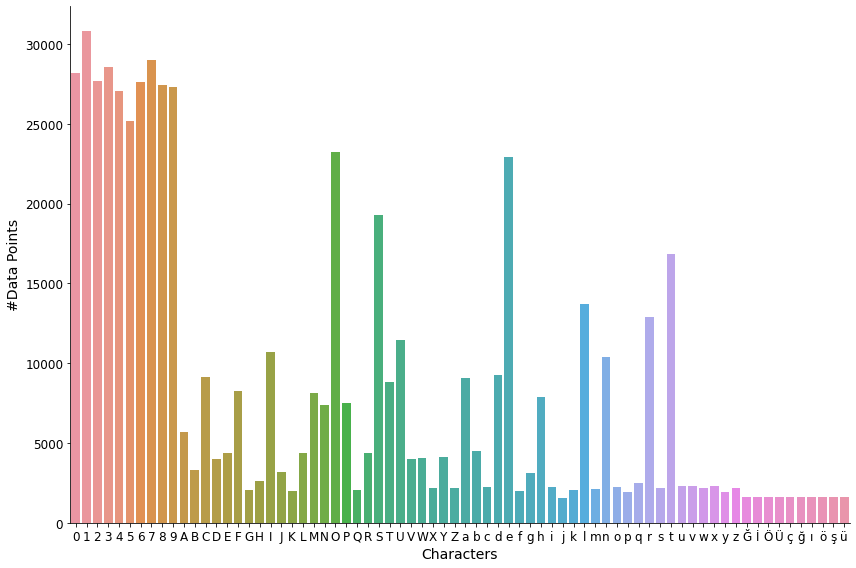

In [203]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_ROSE == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 5 Random Oversampled Training_Only Set class Distributions', tight_layout=True)

##### 2.0.3.2 Undersampling Digits in the Combination of (Cropped And Resized NIST19 (OpenCV) + Padded T-H-E)

In [204]:
random_strategy_dictionary_updated = {}

for i in range(0,72,1):
    if i < 10:
        random_strategy_dictionary_updated[i] = int(np.count_nonzero(y_train_ROSE == i) / 3)
    else:
        random_strategy_dictionary_updated[i] = np.count_nonzero(y_train_ROSE == i)

print(random_strategy_dictionary_updated)

{0: 9397, 1: 10273, 2: 9229, 3: 9529, 4: 9026, 5: 8388, 6: 9201, 7: 9664, 8: 9148, 9: 9104, 10: 5676, 11: 3313, 12: 9165, 13: 4006, 14: 4390, 15: 8265, 16: 2086, 17: 2650, 18: 10675, 19: 3209, 20: 2002, 21: 4361, 22: 8122, 23: 7411, 24: 23231, 25: 7514, 26: 2078, 27: 4403, 28: 19299, 29: 8851, 30: 11458, 31: 4010, 32: 4071, 33: 2212, 34: 4121, 35: 2185, 36: 9068, 37: 4496, 38: 2262, 39: 9251, 40: 22922, 41: 2020, 42: 3109, 43: 7868, 44: 2258, 45: 1550, 46: 2075, 47: 13719, 48: 2134, 49: 10413, 50: 2236, 51: 1945, 52: 2524, 53: 12907, 54: 2185, 55: 16843, 56: 2298, 57: 2312, 58: 2186, 59: 2284, 60: 1911, 61: 2208, 62: 1620, 63: 1620, 64: 1620, 65: 1620, 66: 1620, 67: 1620, 68: 1620, 69: 1620, 70: 1620, 71: 1620}


In [205]:
randomUnderSampler = RandomUnderSampler(sampling_strategy=random_strategy_dictionary_updated, random_state=42)
X_train_RUSE, y_train_RUSE = randomUnderSampler.fit_resample(X_train_ROSE, y_train_ROSE)

Saving figure Combination 5 Random Undersampled Training_Only Set class Distributions


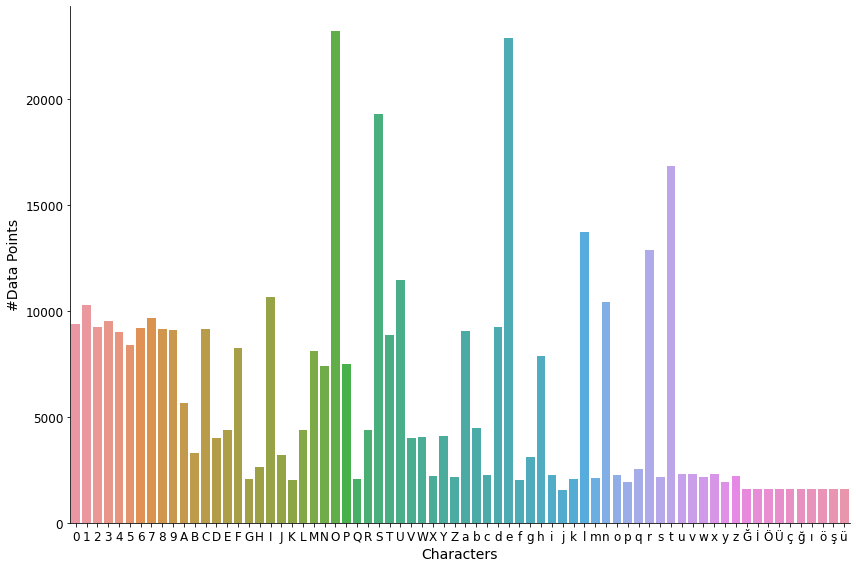

In [206]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_RUSE == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 5 Random Undersampled Training_Only Set class Distributions', tight_layout=True)

In [207]:
print(X_train_RUSE.shape)

(422907, 784)


##### 2.0.3.3 Training the baseline on the resampled dataset

In [208]:
X_train_RUSE, y_train_RUSE = shuffle(X_train_RUSE, y_train_RUSE, random_state=42)

In [209]:
X_train_RUSE = X_train_RUSE[:, :].reshape(-1, 28, 28)

In [210]:
# n_rows = 10
# n_cols = 10
# plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
# for row in range(n_rows):
#     for col in range(n_cols):
#         index = n_cols * row + col
#         plt.subplot(n_rows, n_cols, index + 1)
#         plt.imshow(X_train_RUSE[index], cmap="gray", interpolation="nearest")
#         plt.axis('off')
#         plt.title(decodeLabel(int(y_train_RUSE[index])), fontsize=12)
# plt.subplots_adjust(wspace=0.2, hspace=0.5)
# save_fig('Random_Resampled_Combination_2_plot', tight_layout=False)
# plt.show()

In [211]:
X_train_RUSE = X_train_RUSE[..., np.newaxis]

In [212]:
np.save("./SplittedDatasets/5/RandomResampling/X_train.npy", X_train_RUSE)
np.save("./SplittedDatasets/5/RandomResampling/y_train.npy", y_train_RUSE)

In [213]:
baseline_model_2_0_3 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [214]:
baseline_model_2_0_3.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [215]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_0_3.h5", save_best_only=True)

In [216]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_0_3"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [217]:
model_2_0_3_t0 = time.time()
history_2_0_3 = baseline_model_2_0_3.fit(X_train_RUSE, y_train_RUSE, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_0_3_t1 = time.time()

Epoch 1/100
13216/13216 [==============================] - 316s 24ms/step - loss: 0.3417 - sparse_categorical_accuracy: 0.8904 - sparse_top_k_categorical_accuracy: 0.9815 - val_loss: 0.2525 - val_sparse_categorical_accuracy: 0.9067 - val_sparse_top_k_categorical_accuracy: 0.9913
Epoch 2/100
13216/13216 [==============================] - 314s 24ms/step - loss: 0.2189 - sparse_categorical_accuracy: 0.9231 - sparse_top_k_categorical_accuracy: 0.9935 - val_loss: 0.2387 - val_sparse_categorical_accuracy: 0.9103 - val_sparse_top_k_categorical_accuracy: 0.9938
Epoch 3/100
13216/13216 [==============================] - 317s 24ms/step - loss: 0.1918 - sparse_categorical_accuracy: 0.9306 - sparse_top_k_categorical_accuracy: 0.9954 - val_loss: 0.2210 - val_sparse_categorical_accuracy: 0.9170 - val_sparse_top_k_categorical_accuracy: 0.9942
Epoch 4/100
13216/13216 [==============================] - 314s 24ms/step - loss: 0.1750 - sparse_categorical_accuracy: 0.9356 - sparse_top_k_categorical_accura

In [218]:
print("Training took {:.2f}s for all Epochs".format(model_2_0_3_t1 - model_2_0_3_t0))

Training took 6942.69s for all Epochs


In [219]:
history_2_0_3.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [220]:
print("Best Training Accuracy: ", round(history_2_0_3.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_0_3.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_0_3.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_0_3.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_0_3.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_0_3.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.94466
Best Training Loss:  0.14376
Best Training Top k Accuracy:  0.99798
Best Validation Accuracy:  0.92863
Best Validation Loss:  0.19289
Best Validation Top k Accuracy:  0.9957


In [221]:
baseline_model_2_0_3.save("./Model_Checkpoints/baseline_model_2_0_3")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_3\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_3\assets


In [222]:
np.save('./Histories/history_2_0_3.npy', history_2_0_3.history)

Saving figure model_2_0_3_learning_curves_plot_loss


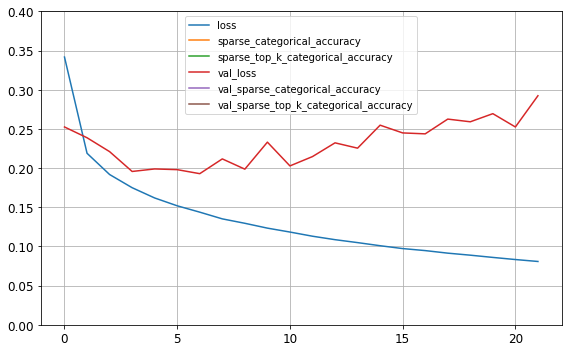

Saving figure model_2_0_3_learning_curves_plot_accuracy


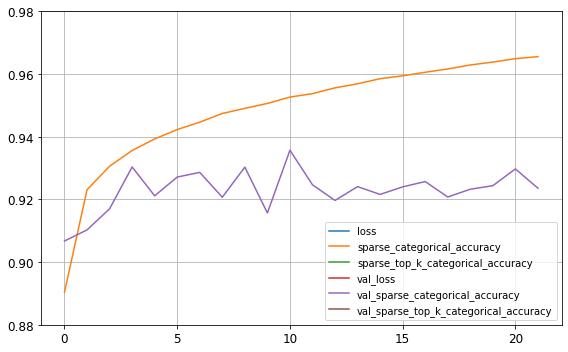

In [223]:
pd.DataFrame(history_2_0_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.4)
save_fig("model_2_0_3_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_0_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.88, 0.98)
save_fig("model_2_0_3_learning_curves_plot_accuracy")
plt.show()

#### 2.0.4 Class-weighted Combination of (Cropped And Resized NIST19 (OpenCV) + Padded T-H-E)

In [8]:
X_train = np.load("./SplittedDatasets/5/RandomResampling/X_train.npy")
y_train = np.load("./SplittedDatasets/5/RandomResampling/y_train.npy")
X_val_only = np.load("./SplittedDatasets/5/X_val_only_5.npy")
y_val_only = np.load("./SplittedDatasets/5/y_val_only_5.npy")

In [9]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [10]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [11]:
print(class_weights)

{0: 0.6250620765492533, 1: 0.5717617378889646, 2: 0.6364403871853216, 3: 0.6164034351278553, 4: 0.6507543023857005, 5: 0.7002513511365442, 6: 0.638377169148281, 7: 0.6077926669426048, 8: 0.6420756813875529, 9: 0.6451788591095489, 10: 1.0348323349776838, 11: 1.7729273568769495, 12: 0.6408847063102382, 13: 1.466227741720752, 14: 1.3379745634016704, 15: 0.710672514619883, 16: 2.815775806967082, 17: 2.216493710691824, 18: 0.5502302888368462, 19: 1.830385893840241, 20: 2.9339202464202465, 21: 1.346871894825346, 22: 0.7231849708610358, 23: 0.7925662303782666, 24: 0.252839237800066, 25: 0.7817019341673321, 26: 2.8266161373115173, 27: 1.3340241502006207, 28: 0.3043529889286146, 29: 0.6636208714646179, 30: 0.5126294583115145, 31: 1.464765170407315, 32: 1.4428170801604847, 33: 2.65538351416516, 34: 1.4253114130874383, 35: 2.6881960335621664, 36: 0.6477402220261727, 37: 1.3064297894424675, 38: 2.596688034188034, 39: 0.634926854754441, 40: 0.25624763691359104, 41: 2.907776402640264, 42: 1.88925967

In [12]:
baseline_model_2_0_4 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [13]:
baseline_model_2_0_4.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [14]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_0_4.h5", save_best_only=True)

In [15]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_0_4"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [16]:
model_2_0_4_t0 = time.time()
history_2_0_4 = baseline_model_2_0_4.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_0_4_t1 = time.time()

Epoch 1/100
13216/13216 [==============================] - 290s 22ms/step - loss: 0.4217 - sparse_categorical_accuracy: 0.8587 - sparse_top_k_categorical_accuracy: 0.9755 - val_loss: 0.2927 - val_sparse_categorical_accuracy: 0.9000 - val_sparse_top_k_categorical_accuracy: 0.9882
Epoch 2/100
13216/13216 [==============================] - 294s 22ms/step - loss: 0.2583 - sparse_categorical_accuracy: 0.9012 - sparse_top_k_categorical_accuracy: 0.9913 - val_loss: 0.2779 - val_sparse_categorical_accuracy: 0.9038 - val_sparse_top_k_categorical_accuracy: 0.9908
Epoch 3/100
13216/13216 [==============================] - 293s 22ms/step - loss: 0.2214 - sparse_categorical_accuracy: 0.9112 - sparse_top_k_categorical_accuracy: 0.9938 - val_loss: 0.2647 - val_sparse_categorical_accuracy: 0.9007 - val_sparse_top_k_categorical_accuracy: 0.9928
Epoch 4/100
13216/13216 [==============================] - 293s 22ms/step - loss: 0.1996 - sparse_categorical_accuracy: 0.9171 - sparse_top_k_categorical_accura

In [17]:
print("Training took {:.2f}s for all Epochs".format(model_2_0_4_t1 - model_2_0_4_t0))

Training took 7080.43s for all Epochs


In [18]:
history_2_0_4.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [19]:
print("Best Training Accuracy: ", round(history_2_0_4.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_0_4.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_0_4.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_0_4.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_0_4.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_0_4.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.93234
Best Training Loss:  0.14532
Best Training Top k Accuracy:  0.99738
Best Validation Accuracy:  0.93115
Best Validation Loss:  0.20416
Best Validation Top k Accuracy:  0.99507


In [20]:
baseline_model_2_0_4.save("./Model_Checkpoints/baseline_model_2_0_4")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_4\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_4\assets


In [21]:
np.save('./Histories/history_2_0_4.npy', history_2_0_4.history)

Saving figure model_2_0_4_learning_curves_plot_loss


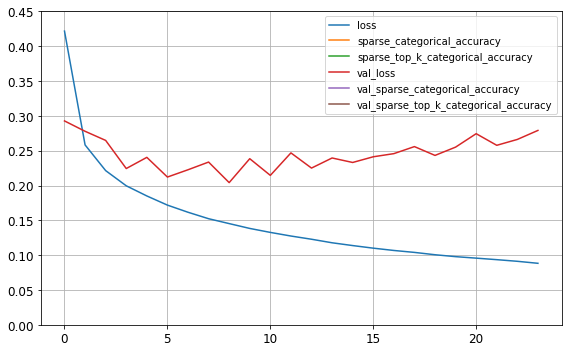

Saving figure model_2_0_4_learning_curves_plot_accuracy


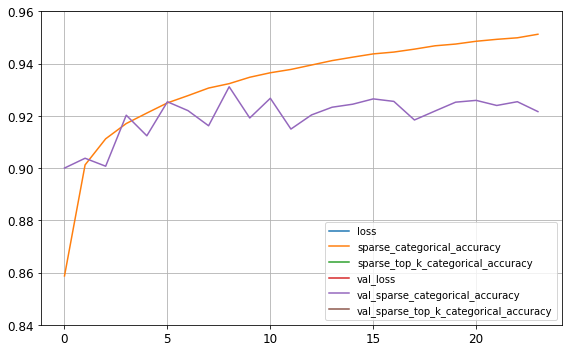

In [22]:
pd.DataFrame(history_2_0_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.45)
save_fig("model_2_0_4_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_0_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.84, 0.96)
save_fig("model_2_0_4_learning_curves_plot_accuracy")
plt.show()

#### 2.0.5 Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E)

##### 2.0.5.1 Oversampling Turkish Characters in the Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E)

In [239]:
X_train = np.load("./SplittedDatasets/8/X_train_8.npy")
y_train = np.load("./SplittedDatasets/8/y_train_8.npy")

In [240]:
splitter = StratifiedShuffleSplit(train_size=0.9, test_size=0.1, random_state=42)
for train_index, test_index in splitter.split(X_train, y_train):
    X_train_only, X_val_only = X_train[train_index], X_train[test_index]
    y_train_only, y_val_only = y_train[train_index], y_train[test_index]

In [241]:
np.save("./SplittedDatasets/8/X_train_only_8.npy", X_train_only)
np.save("./SplittedDatasets/8/y_train_only_8.npy", y_train_only)
np.save("./SplittedDatasets/8/X_val_only_8.npy", X_val_only)
np.save("./SplittedDatasets/8/y_val_only_8.npy", y_val_only)

In [242]:
print(X_train_only.shape)
X_train_only = np.squeeze(X_train_only, axis=3)
print(X_train_only.shape)
X_train_only = X_train_only.reshape(-1, 784)
print(X_train_only.shape)

(608836, 28, 28, 1)
(608836, 28, 28)
(608836, 784)


Saving figure Combination 8 Training_Only Set class Distributions


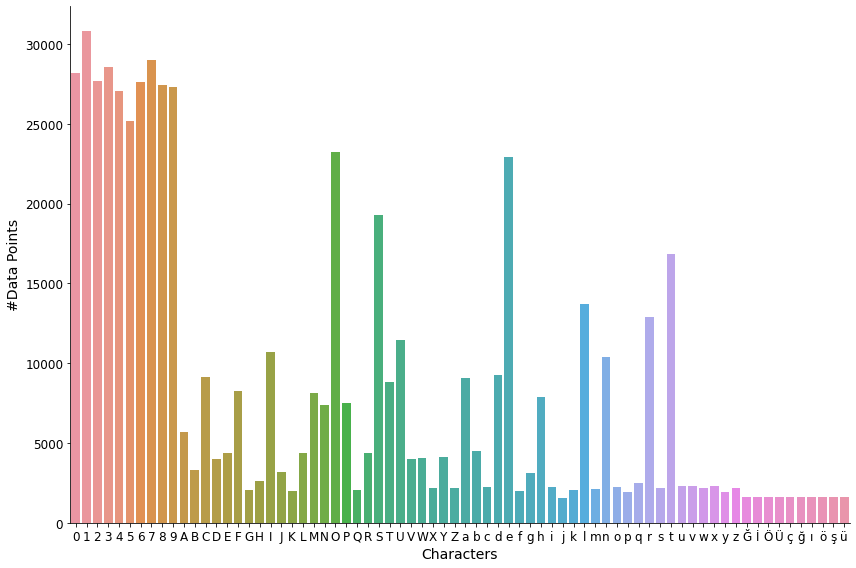

In [243]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_only == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 8 Training_Only Set class Distributions', tight_layout=True)

In [244]:
print("The Average is ", statistics.mean(frequecies), " Data points")

The Average is  8456.055555555555  Data points


In [245]:
random_strategy_dictionary = {}

for i in range(0,72,1):
    if i > 61:
        random_strategy_dictionary[i] = int(np.count_nonzero(y_train_only == i) * 2)
    else:
        random_strategy_dictionary[i] = np.count_nonzero(y_train_only == i)

print(random_strategy_dictionary)

{0: 28191, 1: 30819, 2: 27689, 3: 28588, 4: 27080, 5: 25164, 6: 27604, 7: 28994, 8: 27446, 9: 27313, 10: 5676, 11: 3313, 12: 9165, 13: 4006, 14: 4390, 15: 8265, 16: 2086, 17: 2650, 18: 10675, 19: 3209, 20: 2002, 21: 4361, 22: 8122, 23: 7411, 24: 23231, 25: 7514, 26: 2078, 27: 4403, 28: 19299, 29: 8851, 30: 11458, 31: 4010, 32: 4071, 33: 2212, 34: 4121, 35: 2185, 36: 9068, 37: 4496, 38: 2262, 39: 9251, 40: 22922, 41: 2020, 42: 3109, 43: 7868, 44: 2258, 45: 1550, 46: 2075, 47: 13719, 48: 2134, 49: 10413, 50: 2236, 51: 1945, 52: 2524, 53: 12907, 54: 2185, 55: 16843, 56: 2298, 57: 2312, 58: 2186, 59: 2284, 60: 1911, 61: 2208, 62: 3240, 63: 3240, 64: 3240, 65: 3240, 66: 3240, 67: 3240, 68: 3240, 69: 3240, 70: 3240, 71: 3240}


In [246]:
randomOversampler = RandomOverSampler(sampling_strategy=random_strategy_dictionary, random_state=42)
X_train_ROSE, y_train_ROSE = randomOversampler.fit_resample(X_train_only, y_train_only)

Saving figure Combination 8 Random Oversampled Training_Only Set class Distributions


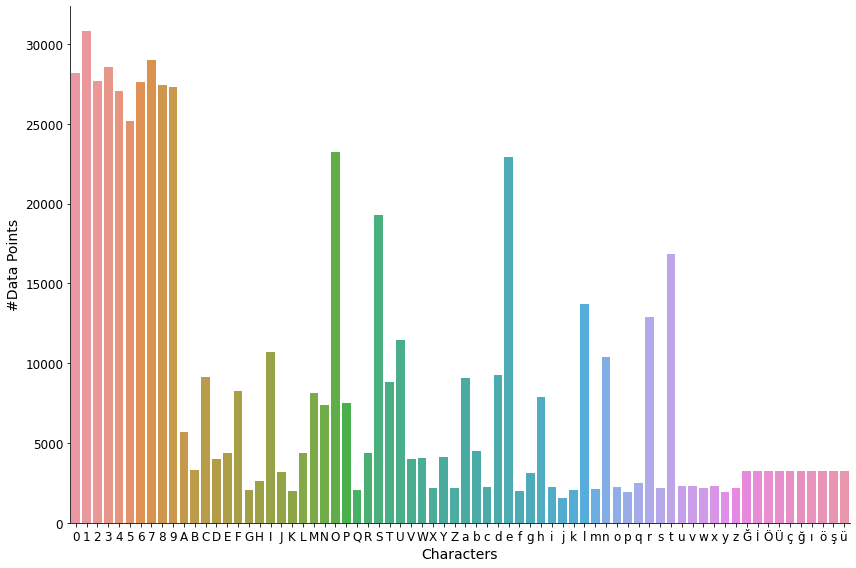

In [247]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_ROSE == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 8 Random Oversampled Training_Only Set class Distributions', tight_layout=True)

##### 2.0.5.2 Undersampling Digits in the Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E)

In [248]:
random_strategy_dictionary_updated = {}

for i in range(0,72,1):
    if i < 10:
        random_strategy_dictionary_updated[i] = int(np.count_nonzero(y_train_ROSE == i) / 3)
    else:
        random_strategy_dictionary_updated[i] = np.count_nonzero(y_train_ROSE == i)

print(random_strategy_dictionary_updated)

{0: 9397, 1: 10273, 2: 9229, 3: 9529, 4: 9026, 5: 8388, 6: 9201, 7: 9664, 8: 9148, 9: 9104, 10: 5676, 11: 3313, 12: 9165, 13: 4006, 14: 4390, 15: 8265, 16: 2086, 17: 2650, 18: 10675, 19: 3209, 20: 2002, 21: 4361, 22: 8122, 23: 7411, 24: 23231, 25: 7514, 26: 2078, 27: 4403, 28: 19299, 29: 8851, 30: 11458, 31: 4010, 32: 4071, 33: 2212, 34: 4121, 35: 2185, 36: 9068, 37: 4496, 38: 2262, 39: 9251, 40: 22922, 41: 2020, 42: 3109, 43: 7868, 44: 2258, 45: 1550, 46: 2075, 47: 13719, 48: 2134, 49: 10413, 50: 2236, 51: 1945, 52: 2524, 53: 12907, 54: 2185, 55: 16843, 56: 2298, 57: 2312, 58: 2186, 59: 2284, 60: 1911, 61: 2208, 62: 3240, 63: 3240, 64: 3240, 65: 3240, 66: 3240, 67: 3240, 68: 3240, 69: 3240, 70: 3240, 71: 3240}


In [249]:
randomUnderSampler = RandomUnderSampler(sampling_strategy=random_strategy_dictionary_updated, random_state=42)
X_train_RUSE, y_train_RUSE = randomUnderSampler.fit_resample(X_train_ROSE, y_train_ROSE)

Saving figure Combination 8 Random Undersampled Training_Only Set class Distributions


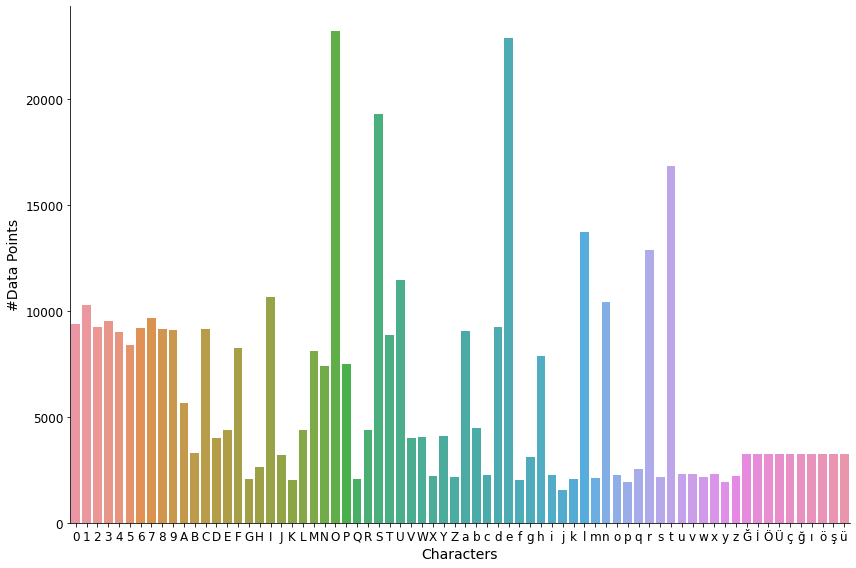

In [250]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_RUSE == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 8 Random Undersampled Training_Only Set class Distributions', tight_layout=True)

In [251]:
print(X_train_RUSE.shape)

(439107, 784)


##### 2.0.5.3 Training the baseline on the resampled dataset

In [252]:
X_train_RUSE, y_train_RUSE = shuffle(X_train_RUSE, y_train_RUSE, random_state=42)

In [253]:
X_train_RUSE = X_train_RUSE[:, :].reshape(-1, 28, 28)

In [254]:
# n_rows = 10
# n_cols = 10
# plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
# for row in range(n_rows):
#     for col in range(n_cols):
#         index = n_cols * row + col
#         plt.subplot(n_rows, n_cols, index + 1)
#         plt.imshow(X_train_RUSE[index], cmap="gray", interpolation="nearest")
#         plt.axis('off')
#         plt.title(decodeLabel(int(y_train_RUSE[index])), fontsize=12)
# plt.subplots_adjust(wspace=0.2, hspace=0.5)
# save_fig('Random_Resampled_Combination_2_plot', tight_layout=False)
# plt.show()

In [255]:
X_train_RUSE = X_train_RUSE[..., np.newaxis]

In [256]:
np.save("./SplittedDatasets/8/RandomResampling/X_train.npy", X_train_RUSE)
np.save("./SplittedDatasets/8/RandomResampling/y_train.npy", y_train_RUSE)

In [257]:
baseline_model_2_0_5 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [258]:
baseline_model_2_0_5.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [259]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_0_5.h5", save_best_only=True)

In [260]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_0_5"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [261]:
model_2_0_5_t0 = time.time()
history_2_0_5 = baseline_model_2_0_5.fit(X_train_RUSE, y_train_RUSE, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_0_5_t1 = time.time()

Epoch 1/100
13723/13723 [==============================] - 398s 29ms/step - loss: 0.4164 - sparse_categorical_accuracy: 0.8614 - sparse_top_k_categorical_accuracy: 0.9579 - val_loss: 0.2988 - val_sparse_categorical_accuracy: 0.8881 - val_sparse_top_k_categorical_accuracy: 0.9862
Epoch 2/100
13723/13723 [==============================] - 394s 29ms/step - loss: 0.2726 - sparse_categorical_accuracy: 0.9032 - sparse_top_k_categorical_accuracy: 0.9846 - val_loss: 0.2344 - val_sparse_categorical_accuracy: 0.9051 - val_sparse_top_k_categorical_accuracy: 0.9935
Epoch 3/100
13723/13723 [==============================] - 394s 29ms/step - loss: 0.2226 - sparse_categorical_accuracy: 0.9190 - sparse_top_k_categorical_accuracy: 0.9927 - val_loss: 0.2120 - val_sparse_categorical_accuracy: 0.9197 - val_sparse_top_k_categorical_accuracy: 0.9941
Epoch 4/100
13723/13723 [==============================] - 393s 29ms/step - loss: 0.1987 - sparse_categorical_accuracy: 0.9268 - sparse_top_k_categorical_accura

In [262]:
print("Training took {:.2f}s for all Epochs".format(model_2_0_5_t1 - model_2_0_5_t0))

Training took 8675.07s for all Epochs


In [263]:
history_2_0_5.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [264]:
print("Best Training Accuracy: ", round(history_2_0_5.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_0_5.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_0_5.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_0_5.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_0_5.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_0_5.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.93786
Best Training Loss:  0.16132
Best Training Top k Accuracy:  0.99719
Best Validation Accuracy:  0.92903
Best Validation Loss:  0.19675
Best Validation Top k Accuracy:  0.99494


In [265]:
baseline_model_2_0_5.save("./Model_Checkpoints/baseline_model_2_0_5")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_5\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_5\assets


In [266]:
np.save('./Histories/history_2_0_5.npy', history_2_0_5.history)

Saving figure model_2_0_5_learning_curves_plot_loss


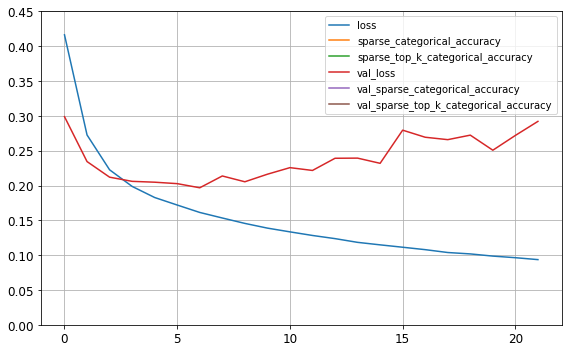

Saving figure model_2_0_5_learning_curves_plot_accuracy


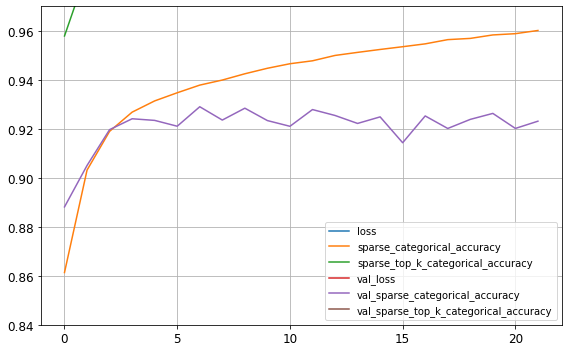

In [267]:
pd.DataFrame(history_2_0_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.45)
save_fig("model_2_0_5_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_0_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.84, 0.97)
save_fig("model_2_0_5_learning_curves_plot_accuracy")
plt.show()

#### 2.0.6 Class-weighted Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E)

In [268]:
X_train = np.load("./SplittedDatasets/8/RandomResampling/X_train.npy")
y_train = np.load("./SplittedDatasets/8/RandomResampling/y_train.npy")
X_val_only = np.load("./SplittedDatasets/8/X_val_only_8.npy")
y_val_only = np.load("./SplittedDatasets/8/y_val_only_8.npy")

In [269]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [270]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [271]:
baseline_model_2_0_6 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [272]:
baseline_model_2_0_6.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [273]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_0_6.h5", save_best_only=True)

In [274]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_0_6"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [275]:
model_2_0_6_t0 = time.time()
history_2_0_6 = baseline_model_2_0_6.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_0_6_t1 = time.time()

Epoch 1/100
13723/13723 [==============================] - 406s 29ms/step - loss: 0.5545 - sparse_categorical_accuracy: 0.8308 - sparse_top_k_categorical_accuracy: 0.9520 - val_loss: 0.3461 - val_sparse_categorical_accuracy: 0.8768 - val_sparse_top_k_categorical_accuracy: 0.9827
Epoch 2/100
13723/13723 [==============================] - 407s 30ms/step - loss: 0.3402 - sparse_categorical_accuracy: 0.8841 - sparse_top_k_categorical_accuracy: 0.9856 - val_loss: 0.2832 - val_sparse_categorical_accuracy: 0.8930 - val_sparse_top_k_categorical_accuracy: 0.9895
Epoch 3/100
13723/13723 [==============================] - 405s 30ms/step - loss: 0.2741 - sparse_categorical_accuracy: 0.9000 - sparse_top_k_categorical_accuracy: 0.9913 - val_loss: 0.2682 - val_sparse_categorical_accuracy: 0.9028 - val_sparse_top_k_categorical_accuracy: 0.9913
Epoch 4/100
13723/13723 [==============================] - 407s 30ms/step - loss: 0.2441 - sparse_categorical_accuracy: 0.9077 - sparse_top_k_categorical_accura

In [276]:
print("Training took {:.2f}s for all Epochs".format(model_2_0_6_t1 - model_2_0_6_t0))

Training took 10181.82s for all Epochs


In [277]:
history_2_0_6.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [278]:
print("Best Training Accuracy: ", round(history_2_0_6.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_0_6.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_0_6.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_0_6.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_0_6.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_0_6.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.92724
Best Training Loss:  0.16815
Best Training Top k Accuracy:  0.99703
Best Validation Accuracy:  0.92569
Best Validation Loss:  0.22926
Best Validation Top k Accuracy:  0.99415


In [279]:
baseline_model_2_0_6.save("./Model_Checkpoints/baseline_model_2_0_6")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_6\assets


INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_0_6\assets


In [280]:
np.save('./Histories/history_2_0_6.npy', history_2_0_6.history)

Saving figure model_2_0_6_learning_curves_plot_loss


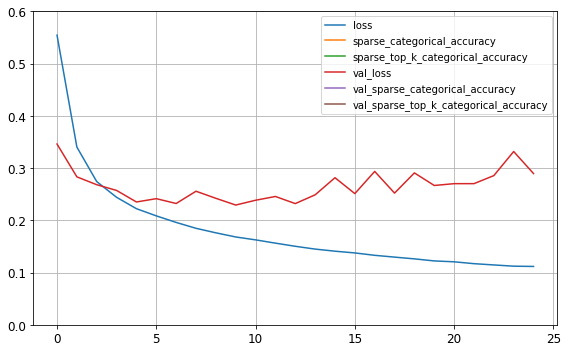

Saving figure model_2_0_6_learning_curves_plot_accuracy


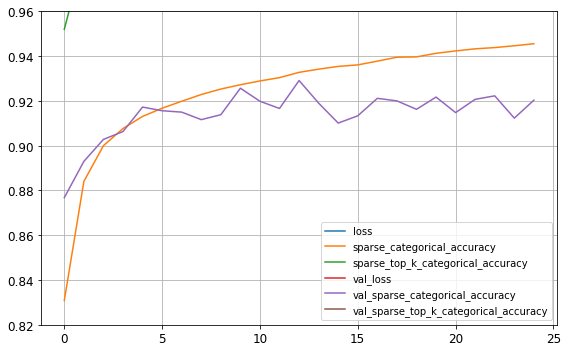

In [281]:
pd.DataFrame(history_2_0_6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.6)
save_fig("model_2_0_6_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_0_6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.82, 0.96)
save_fig("model_2_0_6_learning_curves_plot_accuracy")
plt.show()

#### 2.0.7 Comparsion between random resampled combinations

In [24]:
combinations = [
    "Combination 2",
    "Class-weigted Combination 2",
    "Combination 5",
    "Class-weigted Combination 5",
    "Combination 8",
    "Class-weigted Combination 8"
]

In [25]:
val_losses = [
    history_2_0_1.history['val_loss'][-16],
    history_2_0_2.history['val_loss'][-16],
    history_2_0_3.history['val_loss'][-16],
    history_2_0_4.history['val_loss'][-16],
    history_2_0_5.history['val_loss'][-16],
    history_2_0_6.history['val_loss'][-16]
]

val_loss_data = {
    'Random Sampled Combinations': combinations,
    'Validation Losses (Lower is better)': val_losses
}
val_loss_df = pd.DataFrame(val_loss_data)

Saving figure Validation Losses between Random Sampled Combinations


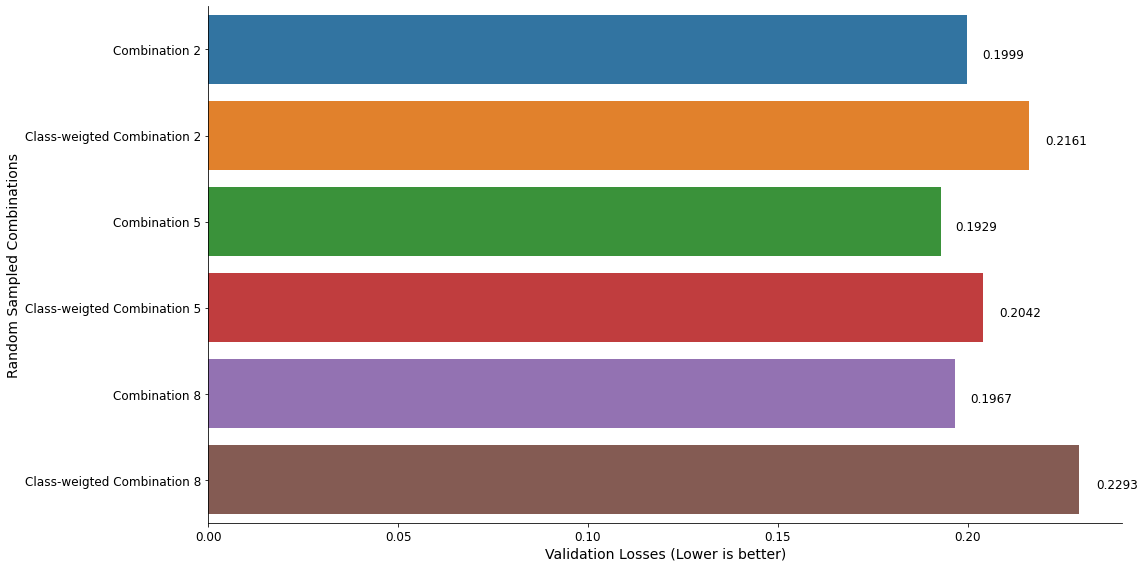

In [26]:
val_loss_catplot = sns.catplot(y="Random Sampled Combinations", x="Validation Losses (Lower is better)", kind="bar", height=8, aspect=2, orient='h',  data=val_loss_df)
val_loss_catplot.set_yticklabels(fontsize=12, rotation=0)
val_loss_catplot.set_xticklabels(fontsize=12, rotation=0)
ax5 = val_loss_catplot.facet_axis(0,0)
for p in ax5.patches:
    ax5.text( p.get_width() * 1.02,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validation Losses between Random Sampled Combinations', tight_layout=True)

In [27]:
val_accuracies = [
    history_2_0_1.history['val_sparse_categorical_accuracy'][-16],
    history_2_0_2.history['val_sparse_categorical_accuracy'][-16],
    history_2_0_3.history['val_sparse_categorical_accuracy'][-16],
    history_2_0_4.history['val_sparse_categorical_accuracy'][-16],
    history_2_0_5.history['val_sparse_categorical_accuracy'][-16],
    history_2_0_6.history['val_sparse_categorical_accuracy'][-16]
]

val_accuracies_data = {
    'Random Sampled Combinations': combinations,
    'Validation Accuracy (Higher is better)': val_accuracies
}
val_accuracies_data_df = pd.DataFrame(val_accuracies_data)

Saving figure Validation Accuracy between Random Sampled Combinations


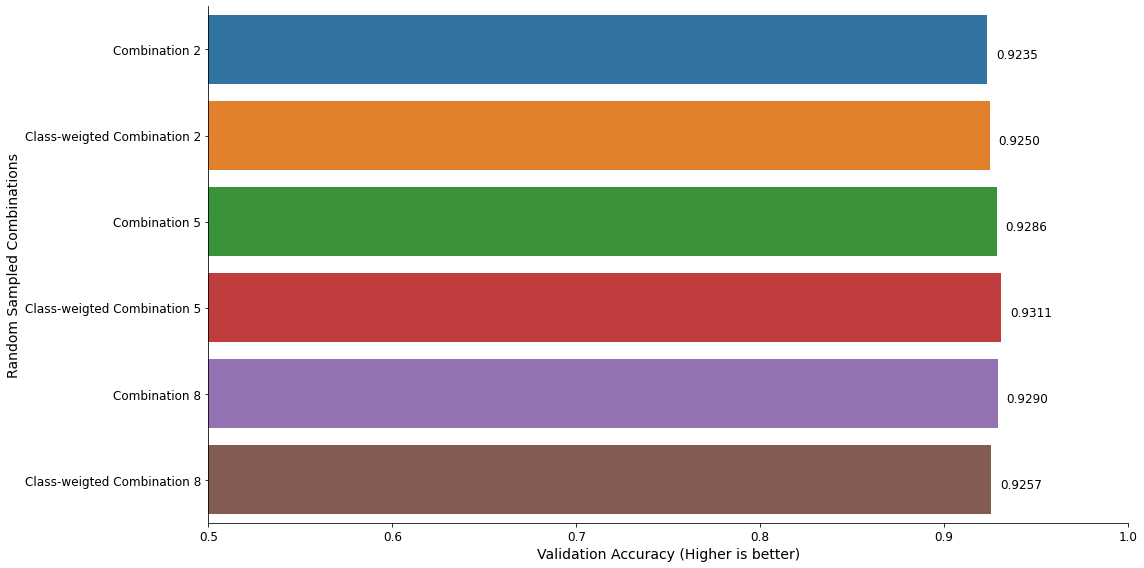

In [28]:
val_accuracies_catplot = sns.catplot(y="Random Sampled Combinations", x="Validation Accuracy (Higher is better)", kind="bar", height=8, aspect=2, orient='h',  data=val_accuracies_data_df)
val_accuracies_catplot.set_yticklabels(fontsize=12, rotation=0)
ax6 = val_accuracies_catplot.facet_axis(0,0)
val_accuracies_catplot.set(xlim=(0.5,1))
for p in ax6.patches:
    ax6.text( p.get_width() * 1.005,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validation Accuracy between Random Sampled Combinations', tight_layout=True)

In [34]:
epoch_train_time = [
    (model_2_0_1_t1 - model_2_0_1_t0) / len(history_2_0_1.history['val_loss']),
    (model_2_0_2_t1 - model_2_0_2_t0) / len(history_2_0_2.history['val_loss']),
    (model_2_0_3_t1 - model_2_0_3_t0) / len(history_2_0_3.history['val_loss']),
    (model_2_0_4_t1 - model_2_0_4_t0) / len(history_2_0_4.history['val_loss']),
    (model_2_0_5_t1 - model_2_0_5_t0) / len(history_2_0_5.history['val_loss']),
    (model_2_0_6_t1 - model_2_0_6_t0) / len(history_2_0_6.history['val_loss']),
]

train_time_data = {
    'Random Sampled Combinations': combinations,
    'Training Time per Epoch (Lower is better)': epoch_train_time
}
train_time_data_df = pd.DataFrame(train_time_data)

Saving figure Training Time Per Epoch between Random Sampled Combinations


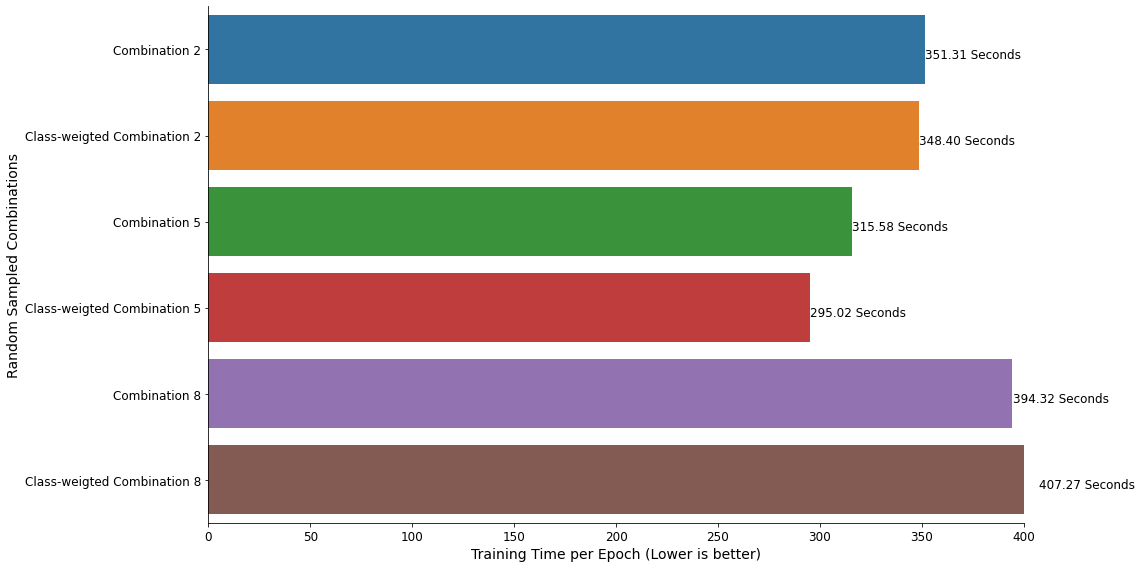

In [35]:
train_time_catplot = sns.catplot(y="Random Sampled Combinations", x="Training Time per Epoch (Lower is better)", kind="bar", height=8, aspect=2, orient='h',  data=train_time_data_df)
train_time_catplot.set_yticklabels(fontsize=12, rotation=0)
ax7 = train_time_catplot.facet_axis(0,0)
train_time_catplot.set(xlim=(0,400))
for p in ax7.patches:
    ax7.text( p.get_width() * 1.001,
            p.get_y() + 0.5,
            '{0:.2f} Seconds'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Training Time Per Epoch between Random Sampled Combinations', tight_layout=True)

In [29]:
combinations_de = [
    "2. Kombination",
    "Klassengewichteten 2. Kombination",
    "5. Kombination",
    "Klassengewichteten 5. Kombination",
    "8. Kombination",
    "Klassengewichteten 8. Kombination"
]

In [30]:
val_losses = [
    history_2_0_1.history['val_loss'][-16],
    history_2_0_2.history['val_loss'][-16],
    history_2_0_3.history['val_loss'][-16],
    history_2_0_4.history['val_loss'][-16],
    history_2_0_5.history['val_loss'][-16],
    history_2_0_6.history['val_loss'][-16],
]

val_loss_data = {
    'Zufällig-resampled Kombinationen': combinations_de,
    'Validierungsverlust (Niedriger ist besser)': val_losses
}
val_loss_df = pd.DataFrame(val_loss_data)

Saving figure Validierungsverluste zwischen zufällig-resampled Kombinationen


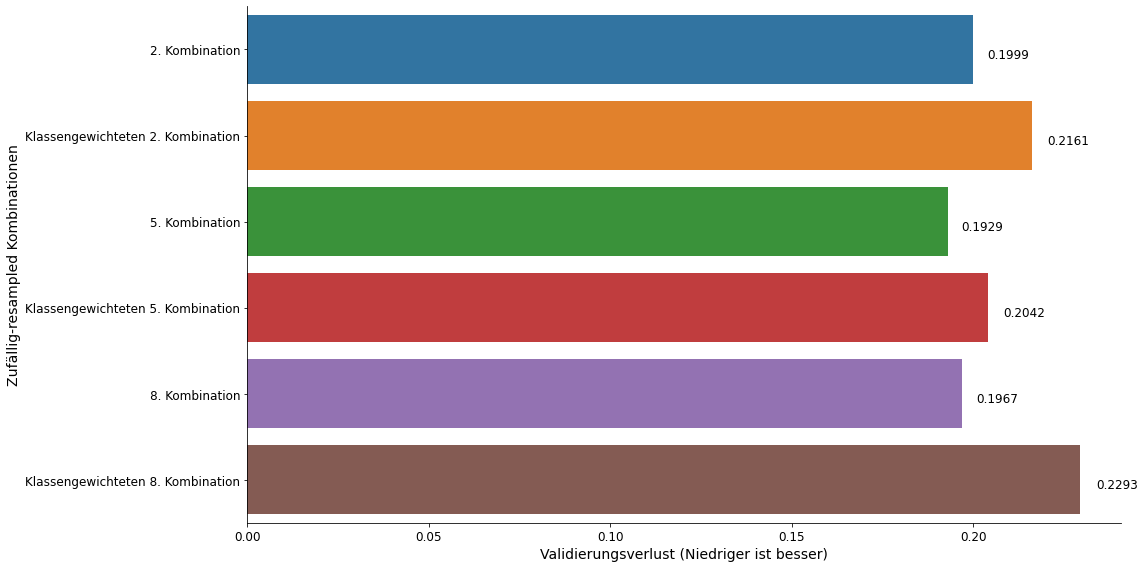

In [31]:
val_loss_catplot = sns.catplot(y="Zufällig-resampled Kombinationen", x="Validierungsverlust (Niedriger ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=val_loss_df)
val_loss_catplot.set_yticklabels(fontsize=12, rotation=0)
val_loss_catplot.set_xticklabels(fontsize=12, rotation=0)
ax5 = val_loss_catplot.facet_axis(0,0)
for p in ax5.patches:
    ax5.text( p.get_width() * 1.02,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validierungsverluste zwischen zufällig-resampled Kombinationen', tight_layout=True)

In [32]:
val_accuracies = [
    history_2_0_1.history['val_sparse_categorical_accuracy'][-16],
    history_2_0_2.history['val_sparse_categorical_accuracy'][-16],
    history_2_0_3.history['val_sparse_categorical_accuracy'][-16],
    history_2_0_4.history['val_sparse_categorical_accuracy'][-16],
    history_2_0_5.history['val_sparse_categorical_accuracy'][-16],
    history_2_0_6.history['val_sparse_categorical_accuracy'][-16]
]

val_accuracies_data = {
    'Zufällig-resampled Kombinationen': combinations_de,
    'Validierungsgenauigkeit (Höher ist besser)': val_accuracies
}
val_accuracies_data_df = pd.DataFrame(val_accuracies_data)

Saving figure Validierungsgenauigkeit zwischen zufällig-resampled Kombinationen


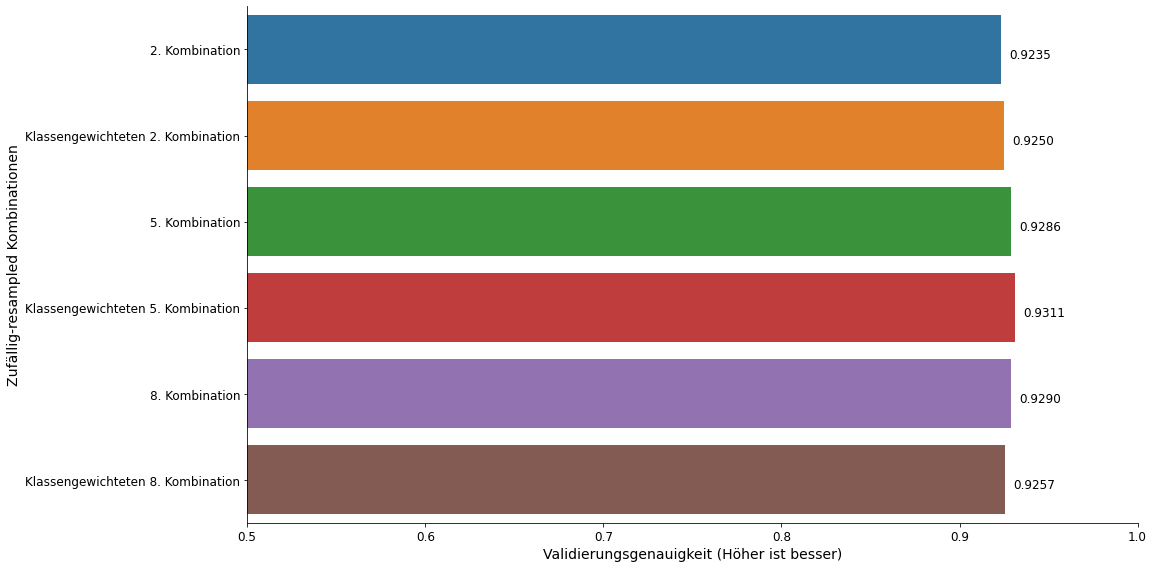

In [33]:
val_accuracies_catplot = sns.catplot(y="Zufällig-resampled Kombinationen", x="Validierungsgenauigkeit (Höher ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=val_accuracies_data_df)
val_accuracies_catplot.set_yticklabels(fontsize=12, rotation=0)
ax6 = val_accuracies_catplot.facet_axis(0,0)
val_accuracies_catplot.set(xlim=(0.5,1))
for p in ax6.patches:
    ax6.text( p.get_width() * 1.005,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validierungsgenauigkeit zwischen zufällig-resampled Kombinationen', tight_layout=False)

In [36]:
epoch_train_time = [
    (model_2_0_1_t1 - model_2_0_1_t0) / len(history_2_0_1.history['val_loss']),
    (model_2_0_2_t1 - model_2_0_2_t0) / len(history_2_0_2.history['val_loss']),
    (model_2_0_3_t1 - model_2_0_3_t0) / len(history_2_0_3.history['val_loss']),
    (model_2_0_4_t1 - model_2_0_4_t0) / len(history_2_0_4.history['val_loss']),
    (model_2_0_5_t1 - model_2_0_5_t0) / len(history_2_0_5.history['val_loss']),
    (model_2_0_6_t1 - model_2_0_6_t0) / len(history_2_0_6.history['val_loss'])
]

train_time_data = {
    'Zufällig-resampled Kombinationen': combinations_de,
    'Trainingszeit pro Epoche (Niedriger ist besser)': epoch_train_time
}
train_time_data_df = pd.DataFrame(train_time_data)

Saving figure Trainingszeit pro Epoche zwischen zufällig-resampled Kombinationen


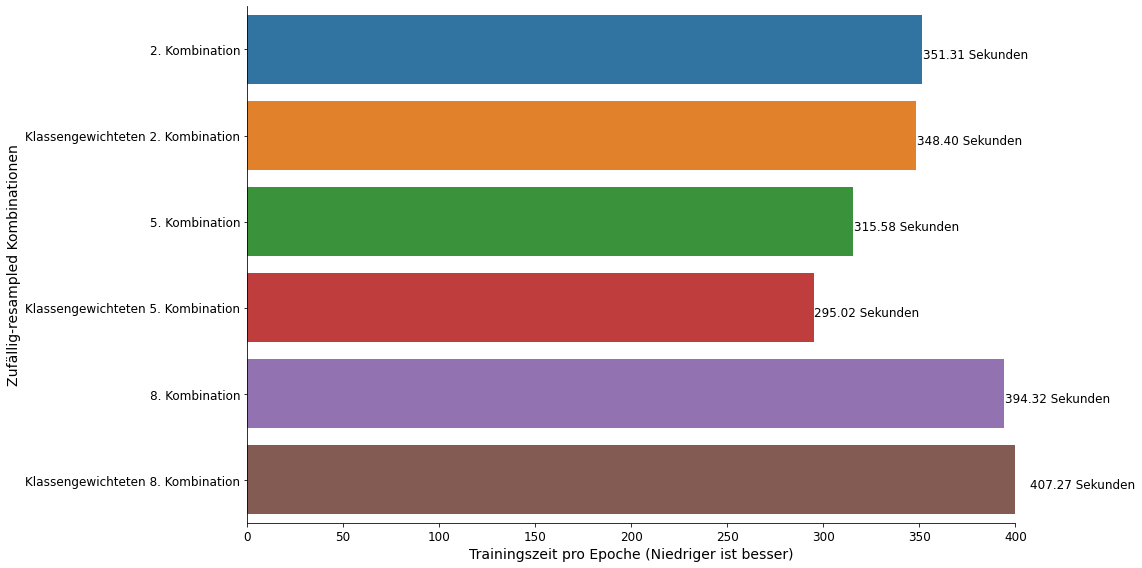

In [37]:
train_time_catplot = sns.catplot(y="Zufällig-resampled Kombinationen", x="Trainingszeit pro Epoche (Niedriger ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=train_time_data_df)
train_time_catplot.set_yticklabels(fontsize=12, rotation=0)
ax7 = train_time_catplot.facet_axis(0,0)
train_time_catplot.set(xlim=(0,400))
for p in ax7.patches:
    ax7.text( p.get_width() * 1.001,
            p.get_y() + 0.5,
            '{0:.2f} Sekunden'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Trainingszeit pro Epoche zwischen zufällig-resampled Kombinationen', tight_layout=True)

### 2.1 Training Models using only `Random (Naive) Undersampling Examples (RUSE)`

#### 2.1.1 Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E)

In [8]:
X_train_only = np.load("./SplittedDatasets/2/X_train_only_2.npy")
y_train_only = np.load("./SplittedDatasets/2/y_train_only_2.npy")
X_val_only = np.load("./SplittedDatasets/2/X_val_only_2.npy")
y_val_only = np.load("./SplittedDatasets/2/y_val_only_2.npy")

In [9]:
print(X_train_only.shape)
X_train_only = np.squeeze(X_train_only, axis=3)
print(X_train_only.shape)
X_train_only = X_train_only.reshape(-1, 784)
print(X_train_only.shape)

(600736, 28, 28, 1)
(600736, 28, 28)
(600736, 784)


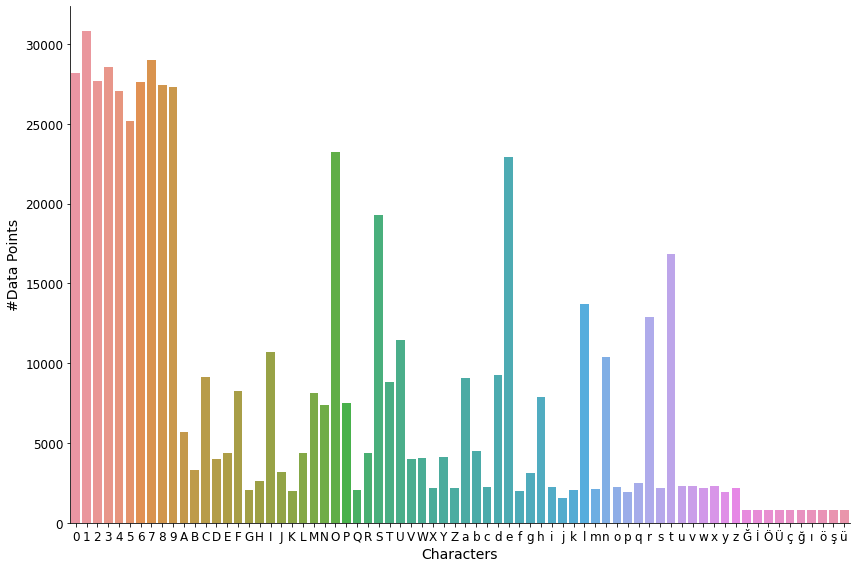

In [10]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_only == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
# save_fig('Combination 2 Training_Only Set class Distributions', tight_layout=True)

In [11]:
random_undersampling_strategy_dictionary = {}

for i in range(0,72,1):
    if i < 10:
        random_undersampling_strategy_dictionary[i] = int(np.count_nonzero(y_train_only == i) / 3)
    else:
        random_undersampling_strategy_dictionary[i] = np.count_nonzero(y_train_only == i)

print(random_undersampling_strategy_dictionary)

{0: 9397, 1: 10273, 2: 9229, 3: 9529, 4: 9026, 5: 8388, 6: 9201, 7: 9664, 8: 9148, 9: 9104, 10: 5676, 11: 3313, 12: 9165, 13: 4006, 14: 4390, 15: 8265, 16: 2086, 17: 2650, 18: 10675, 19: 3209, 20: 2002, 21: 4361, 22: 8122, 23: 7411, 24: 23231, 25: 7514, 26: 2078, 27: 4403, 28: 19299, 29: 8851, 30: 11458, 31: 4010, 32: 4071, 33: 2212, 34: 4121, 35: 2185, 36: 9068, 37: 4496, 38: 2262, 39: 9251, 40: 22922, 41: 2020, 42: 3109, 43: 7868, 44: 2258, 45: 1550, 46: 2075, 47: 13719, 48: 2134, 49: 10413, 50: 2236, 51: 1945, 52: 2524, 53: 12907, 54: 2185, 55: 16843, 56: 2298, 57: 2312, 58: 2186, 59: 2284, 60: 1911, 61: 2208, 62: 810, 63: 810, 64: 810, 65: 810, 66: 810, 67: 810, 68: 810, 69: 810, 70: 810, 71: 810}


In [12]:
randomUnderSampler = RandomUnderSampler(sampling_strategy=random_undersampling_strategy_dictionary, random_state=42)
X_train_only_RUSE, y_train_only_RUSE = randomUnderSampler.fit_resample(X_train_only, y_train_only)

Saving figure Combination 2 only Random Undersampled Training_Only Set class Distributions


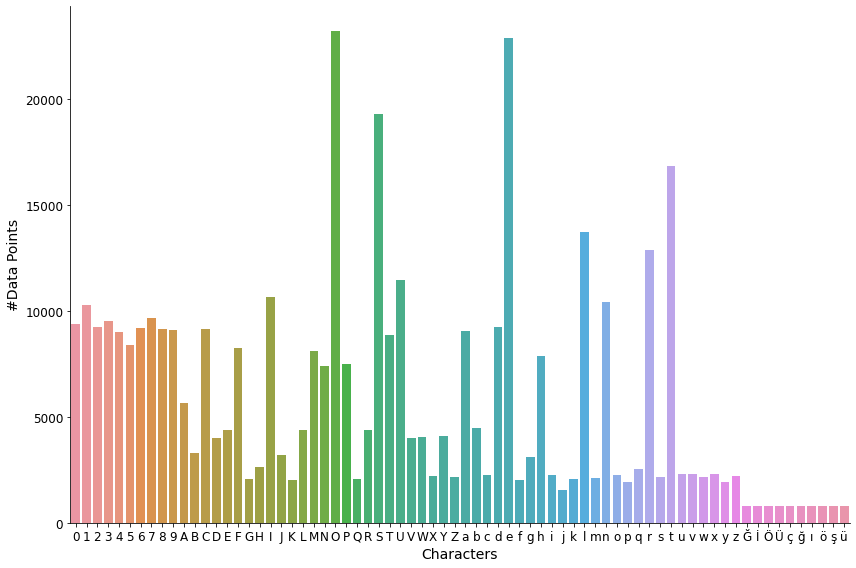

In [13]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_only_RUSE == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 2 only Random Undersampled Training_Only Set class Distributions', tight_layout=True)

In [14]:
print(X_train_only_RUSE.shape)

(414807, 784)


In [15]:
X_train_only_RUSE, y_train_only_RUSE = shuffle(X_train_only_RUSE, y_train_only_RUSE, random_state=42)

In [16]:
X_train_only_RUSE = X_train_only_RUSE[:, :].reshape(-1, 28, 28)

In [17]:
X_train_only_RUSE = X_train_only_RUSE[..., np.newaxis]

In [18]:
np.save("./SplittedDatasets/2/RandomResampling/X_train_only_RUSE.npy", X_train_only_RUSE)
np.save("./SplittedDatasets/2/RandomResampling/y_train_only_RUSE.npy", y_train_only_RUSE)

In [19]:
baseline_model_2_1_1 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [20]:
baseline_model_2_1_1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [21]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_1_1.h5", save_best_only=True)

In [22]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_1_1"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [25]:
model_2_1_1_t0 = time.time()
history_2_1_1 = baseline_model_2_1_1.fit(X_train_only_RUSE, y_train_only_RUSE, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_1_1_t1 = time.time()

Epoch 1/100
12963/12963 [==============================] - 286s 22ms/step - loss: 0.3749 - sparse_categorical_accuracy: 0.8784 - sparse_top_k_categorical_accuracy: 0.9684 - val_loss: 0.2595 - val_sparse_categorical_accuracy: 0.9055 - val_sparse_top_k_categorical_accuracy: 0.9834
Epoch 2/100
12963/12963 [==============================] - 285s 22ms/step - loss: 0.2564 - sparse_categorical_accuracy: 0.9102 - sparse_top_k_categorical_accuracy: 0.9805 - val_loss: 0.2280 - val_sparse_categorical_accuracy: 0.9185 - val_sparse_top_k_categorical_accuracy: 0.9854
Epoch 3/100
12963/12963 [==============================] - 285s 22ms/step - loss: 0.2227 - sparse_categorical_accuracy: 0.9206 - sparse_top_k_categorical_accuracy: 0.9878 - val_loss: 0.2170 - val_sparse_categorical_accuracy: 0.9169 - val_sparse_top_k_categorical_accuracy: 0.9930
Epoch 4/100
12963/12963 [==============================] - 283s 22ms/step - loss: 0.1962 - sparse_categorical_accuracy: 0.9288 - sparse_top_k_categorical_accura

In [26]:
print("Training took {:.2f}s for all Epochs".format(model_2_1_1_t1 - model_2_1_1_t0))

Training took 6262.76s for all Epochs


In [27]:
history_2_1_1.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [28]:
print("Best Training Accuracy: ", round(history_2_1_1.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_1_1.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_1_1.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_1_1.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_1_1.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_1_1.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.94098
Best Training Loss:  0.15586
Best Training Top k Accuracy:  0.99698
Best Validation Accuracy:  0.92768
Best Validation Loss:  0.20278
Best Validation Top k Accuracy:  0.99407


In [29]:
baseline_model_2_1_1.save("./Model_Checkpoints/baseline_model_2_1_1")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_1_1\assets


In [157]:
np.save('./Histories/history_2_1_1.npy', history_2_1_1.history)

Saving figure model_2_1_1_learning_curves_plot_loss


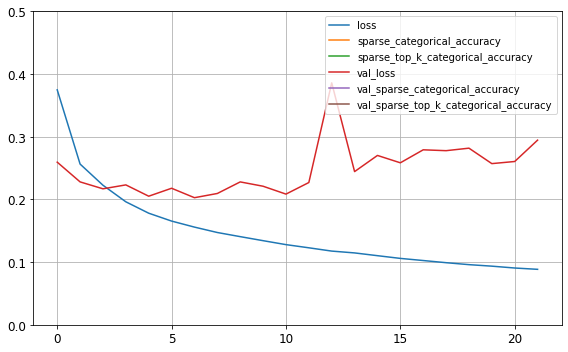

Saving figure model_2_1_1_learning_curves_plot_accuracy


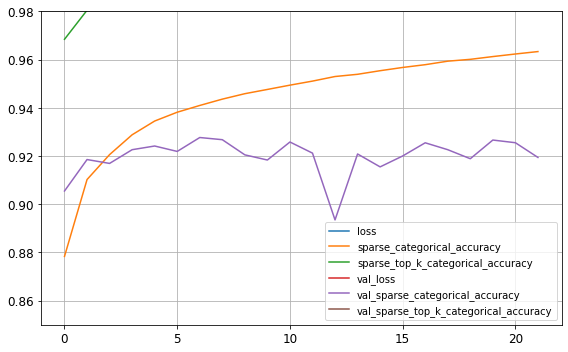

In [30]:
pd.DataFrame(history_2_1_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.5)
save_fig("model_2_1_1_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_1_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.85, 0.98)
save_fig("model_2_1_1_learning_curves_plot_accuracy")
plt.show()

#### 2.1.2 Class-weighted Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E)

In [31]:
X_train_only_RUSE = np.load("./SplittedDatasets/2/RandomResampling/X_train_only_RUSE.npy")
y_train_only_RUSE = np.load("./SplittedDatasets/2/RandomResampling/y_train_only_RUSE.npy")
X_val_only = np.load("./SplittedDatasets/2/X_val_only_2.npy")
y_val_only = np.load("./SplittedDatasets/2/y_val_only_2.npy")

In [32]:
from sklearn.utils import class_weight
y_train_class_weights = y_train_only_RUSE.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_only_RUSE), y=y_train_class_weights)

In [33]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [34]:
baseline_model_2_1_2 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [35]:
baseline_model_2_1_2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [36]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_1_2.h5", save_best_only=True)

In [37]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_1_2"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [38]:
model_2_1_2_t0 = time.time()
history_2_1_2 = baseline_model_2_1_2.fit(X_train_only_RUSE, y_train_only_RUSE, class_weight=class_weights, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_1_2_t1 = time.time()

Epoch 1/100
12963/12963 [==============================] - 283s 22ms/step - loss: 0.6835 - sparse_categorical_accuracy: 0.8458 - sparse_top_k_categorical_accuracy: 0.9623 - val_loss: 0.2947 - val_sparse_categorical_accuracy: 0.8967 - val_sparse_top_k_categorical_accuracy: 0.9810
Epoch 2/100
12963/12963 [==============================] - 281s 22ms/step - loss: 0.5401 - sparse_categorical_accuracy: 0.8879 - sparse_top_k_categorical_accuracy: 0.9775 - val_loss: 0.2867 - val_sparse_categorical_accuracy: 0.8995 - val_sparse_top_k_categorical_accuracy: 0.9813
Epoch 3/100
12963/12963 [==============================] - 282s 22ms/step - loss: 0.5090 - sparse_categorical_accuracy: 0.8972 - sparse_top_k_categorical_accuracy: 0.9800 - val_loss: 0.2643 - val_sparse_categorical_accuracy: 0.9063 - val_sparse_top_k_categorical_accuracy: 0.9832
Epoch 4/100
12963/12963 [==============================] - 287s 22ms/step - loss: 0.4903 - sparse_categorical_accuracy: 0.9023 - sparse_top_k_categorical_accura

In [39]:
print("Training took {:.2f}s for all Epochs".format(model_2_1_2_t1 - model_2_1_2_t0))

Training took 6568.00s for all Epochs


In [40]:
history_2_1_2.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [41]:
print("Best Training Accuracy: ", round(history_2_1_2.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_1_2.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_1_2.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_1_2.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_1_2.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_1_2.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.91598
Best Training Loss:  0.44806
Best Training Top k Accuracy:  0.98337
Best Validation Accuracy:  0.91519
Best Validation Loss:  0.2411
Best Validation Top k Accuracy:  0.98505


In [42]:
baseline_model_2_1_2.save("./Model_Checkpoints/baseline_model_2_1_2")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_1_2\assets


In [156]:
np.save('./Histories/history_2_1_2.npy', history_2_1_2.history)

Saving figure model_2_1_2_learning_curves_plot_loss


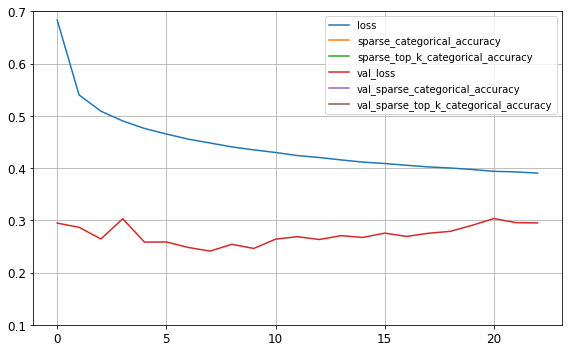

Saving figure model_2_1_2_learning_curves_plot_accuracy


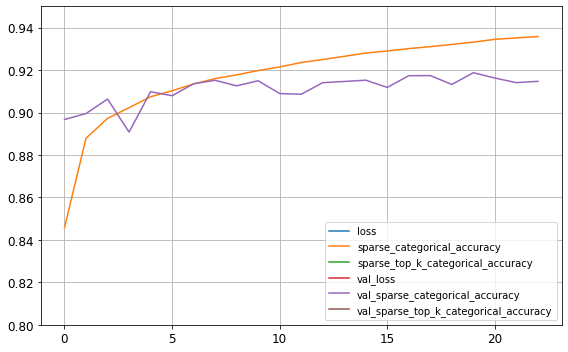

In [43]:
pd.DataFrame(history_2_1_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 0.7)
save_fig("model_2_1_2_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_1_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 0.95)
save_fig("model_2_1_2_learning_curves_plot_accuracy")
plt.show()

#### 2.1.3 Combination of (Cropped And Resized NIST19 (OpenCV) + Padded T-H-E)

In [44]:
X_train_only = np.load("./SplittedDatasets/5/X_train_only_5.npy")
y_train_only = np.load("./SplittedDatasets/5/y_train_only_5.npy")
X_val_only = np.load("./SplittedDatasets/5/X_val_only_5.npy")
y_val_only = np.load("./SplittedDatasets/5/y_val_only_5.npy")

In [45]:
print(X_train_only.shape)
X_train_only = np.squeeze(X_train_only, axis=3)
print(X_train_only.shape)
X_train_only = X_train_only.reshape(-1, 784)
print(X_train_only.shape)

(600736, 28, 28, 1)
(600736, 28, 28)
(600736, 784)


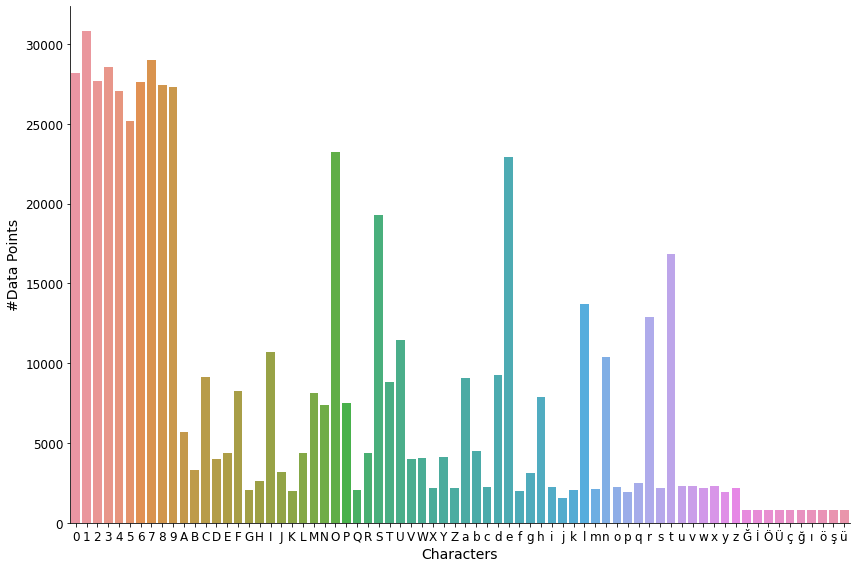

In [46]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_only == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
# save_fig('Combination 5 Training_Only Set class Distributions', tight_layout=True)

In [47]:
random_undersampling_strategy_dictionary = {}

for i in range(0,72,1):
    if i < 10:
        random_undersampling_strategy_dictionary[i] = int(np.count_nonzero(y_train_only == i) / 3)
    else:
        random_undersampling_strategy_dictionary[i] = np.count_nonzero(y_train_only == i)

print(random_undersampling_strategy_dictionary)

{0: 9397, 1: 10273, 2: 9229, 3: 9529, 4: 9026, 5: 8388, 6: 9201, 7: 9664, 8: 9148, 9: 9104, 10: 5676, 11: 3313, 12: 9165, 13: 4006, 14: 4390, 15: 8265, 16: 2086, 17: 2650, 18: 10675, 19: 3209, 20: 2002, 21: 4361, 22: 8122, 23: 7411, 24: 23231, 25: 7514, 26: 2078, 27: 4403, 28: 19299, 29: 8851, 30: 11458, 31: 4010, 32: 4071, 33: 2212, 34: 4121, 35: 2185, 36: 9068, 37: 4496, 38: 2262, 39: 9251, 40: 22922, 41: 2020, 42: 3109, 43: 7868, 44: 2258, 45: 1550, 46: 2075, 47: 13719, 48: 2134, 49: 10413, 50: 2236, 51: 1945, 52: 2524, 53: 12907, 54: 2185, 55: 16843, 56: 2298, 57: 2312, 58: 2186, 59: 2284, 60: 1911, 61: 2208, 62: 810, 63: 810, 64: 810, 65: 810, 66: 810, 67: 810, 68: 810, 69: 810, 70: 810, 71: 810}


In [48]:
randomUnderSampler = RandomUnderSampler(sampling_strategy=random_undersampling_strategy_dictionary, random_state=42)
X_train_only_RUSE, y_train_only_RUSE = randomUnderSampler.fit_resample(X_train_only, y_train_only)

Saving figure Combination 5 only Random Undersampled Training_Only Set class Distributions


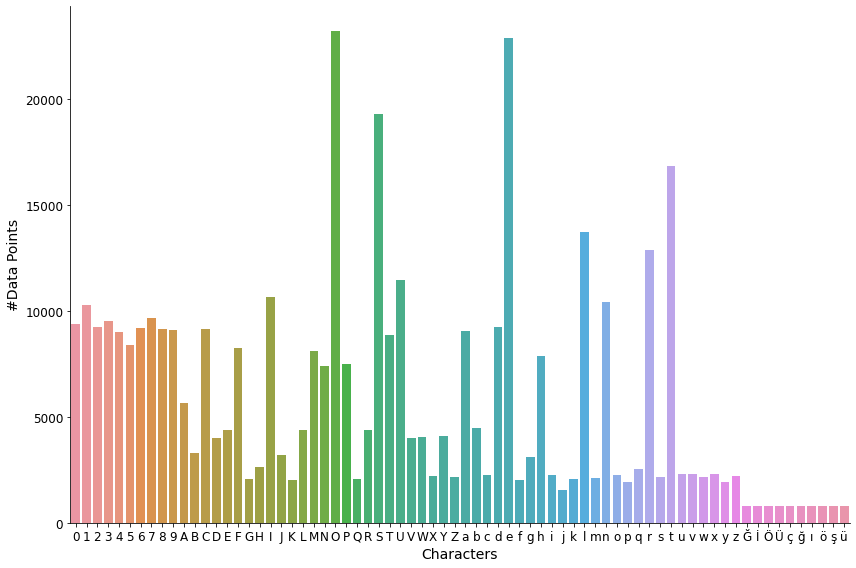

In [49]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_only_RUSE == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 5 only Random Undersampled Training_Only Set class Distributions', tight_layout=True)

In [50]:
print(X_train_only_RUSE.shape)

(414807, 784)


In [51]:
X_train_only_RUSE, y_train_only_RUSE = shuffle(X_train_only_RUSE, y_train_only_RUSE, random_state=42)

In [52]:
X_train_only_RUSE = X_train_only_RUSE[:, :].reshape(-1, 28, 28)

In [53]:
X_train_only_RUSE = X_train_only_RUSE[..., np.newaxis]

In [54]:
np.save("./SplittedDatasets/5/RandomResampling/X_train_only_RUSE.npy", X_train_only_RUSE)
np.save("./SplittedDatasets/5/RandomResampling/y_train_only_RUSE.npy", y_train_only_RUSE)

In [55]:
baseline_model_2_1_3 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [56]:
baseline_model_2_1_3.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [57]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_1_3.h5", save_best_only=True)

In [58]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_1_3"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [59]:
model_2_1_3_t0 = time.time()
history_2_1_3 = baseline_model_2_1_3.fit(X_train_only_RUSE, y_train_only_RUSE, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_1_3_t1 = time.time()

Epoch 1/100
12963/12963 [==============================] - 285s 22ms/step - loss: 0.3423 - sparse_categorical_accuracy: 0.8910 - sparse_top_k_categorical_accuracy: 0.9815 - val_loss: 0.2301 - val_sparse_categorical_accuracy: 0.9157 - val_sparse_top_k_categorical_accuracy: 0.9929
Epoch 2/100
12963/12963 [==============================] - 285s 22ms/step - loss: 0.2198 - sparse_categorical_accuracy: 0.9239 - sparse_top_k_categorical_accuracy: 0.9934 - val_loss: 0.1981 - val_sparse_categorical_accuracy: 0.9283 - val_sparse_top_k_categorical_accuracy: 0.9944
Epoch 3/100
12963/12963 [==============================] - 284s 22ms/step - loss: 0.1922 - sparse_categorical_accuracy: 0.9316 - sparse_top_k_categorical_accuracy: 0.9951 - val_loss: 0.1974 - val_sparse_categorical_accuracy: 0.9241 - val_sparse_top_k_categorical_accuracy: 0.9946
Epoch 4/100
12963/12963 [==============================] - 284s 22ms/step - loss: 0.1762 - sparse_categorical_accuracy: 0.9359 - sparse_top_k_categorical_accura

In [60]:
print("Training took {:.2f}s for all Epochs".format(model_2_1_3_t1 - model_2_1_3_t0))

Training took 6546.13s for all Epochs


In [61]:
history_2_1_3.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [62]:
print("Best Training Accuracy: ", round(history_2_1_3.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_1_3.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_1_3.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_1_3.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_1_3.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_1_3.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.94692
Best Training Loss:  0.13674
Best Training Top k Accuracy:  0.99823
Best Validation Accuracy:  0.93306
Best Validation Loss:  0.19333
Best Validation Top k Accuracy:  0.99516


In [63]:
baseline_model_2_1_3.save("./Model_Checkpoints/baseline_model_2_1_3")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_1_3\assets


In [155]:
np.save('./Histories/history_2_1_3.npy', history_2_1_3.history)

Saving figure model_2_1_3_learning_curves_plot_loss


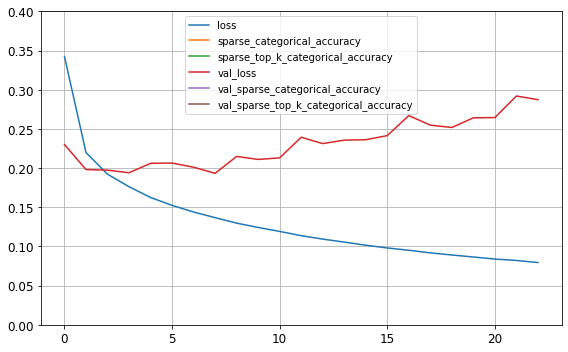

Saving figure model_2_1_3_learning_curves_plot_accuracy


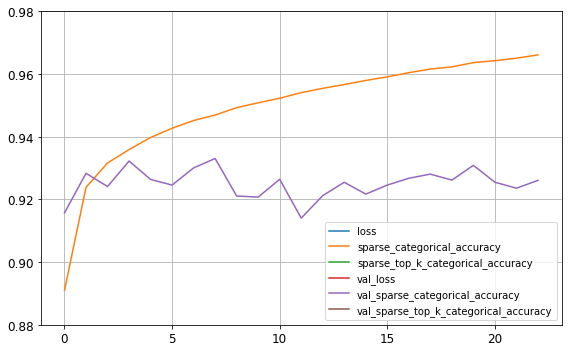

In [64]:
pd.DataFrame(history_2_1_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.4)
save_fig("model_2_1_3_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_1_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.88, 0.98)
save_fig("model_2_1_3_learning_curves_plot_accuracy")
plt.show()

#### 2.1.4 Class-weighted Combination of (Cropped And Resized NIST19 (OpenCV) + Padded T-H-E)

In [65]:
X_train = np.load("./SplittedDatasets/5/RandomResampling/X_train_only_RUSE.npy")
y_train = np.load("./SplittedDatasets/5/RandomResampling/y_train_only_RUSE.npy")
X_val_only = np.load("./SplittedDatasets/5/X_val_only_5.npy")
y_val_only = np.load("./SplittedDatasets/5/y_val_only_5.npy")

In [66]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [67]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [74]:
baseline_model_2_1_4 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [75]:
baseline_model_2_1_4.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [76]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_1_4.h5", save_best_only=True)

In [77]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_1_4"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [78]:
model_2_1_4_t0 = time.time()
history_2_1_4 = baseline_model_2_1_4.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_1_4_t1 = time.time()

Epoch 1/100
12963/12963 [==============================] - 288s 22ms/step - loss: 0.4625 - sparse_categorical_accuracy: 0.8523 - sparse_top_k_categorical_accuracy: 0.9727 - val_loss: 0.3009 - val_sparse_categorical_accuracy: 0.8959 - val_sparse_top_k_categorical_accuracy: 0.9891
Epoch 2/100
12963/12963 [==============================] - 286s 22ms/step - loss: 0.2793 - sparse_categorical_accuracy: 0.8987 - sparse_top_k_categorical_accuracy: 0.9906 - val_loss: 0.2524 - val_sparse_categorical_accuracy: 0.9123 - val_sparse_top_k_categorical_accuracy: 0.9920
Epoch 3/100
12963/12963 [==============================] - 288s 22ms/step - loss: 0.2393 - sparse_categorical_accuracy: 0.9081 - sparse_top_k_categorical_accuracy: 0.9930 - val_loss: 0.2717 - val_sparse_categorical_accuracy: 0.9031 - val_sparse_top_k_categorical_accuracy: 0.9918
Epoch 4/100
12963/12963 [==============================] - 288s 22ms/step - loss: 0.2160 - sparse_categorical_accuracy: 0.9138 - sparse_top_k_categorical_accura

In [79]:
print("Training took {:.2f}s for all Epochs".format(model_2_1_4_t1 - model_2_1_4_t0))

Training took 6627.61s for all Epochs


In [80]:
history_2_1_4.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [81]:
print("Best Training Accuracy: ", round(history_2_1_4.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_1_4.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_1_4.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_1_4.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_1_4.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_1_4.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.92748
Best Training Loss:  0.1657
Best Training Top k Accuracy:  0.99674
Best Validation Accuracy:  0.92262
Best Validation Loss:  0.21986
Best Validation Top k Accuracy:  0.99398


In [82]:
baseline_model_2_1_4.save("./Model_Checkpoints/baseline_model_2_1_4")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_1_4\assets


In [154]:
np.save('./Histories/history_2_1_4.npy', history_2_1_4.history)

Saving figure model_2_1_4_learning_curves_plot_loss


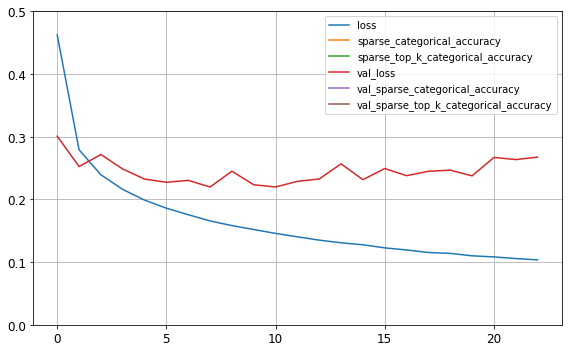

Saving figure model_2_1_4_learning_curves_plot_accuracy


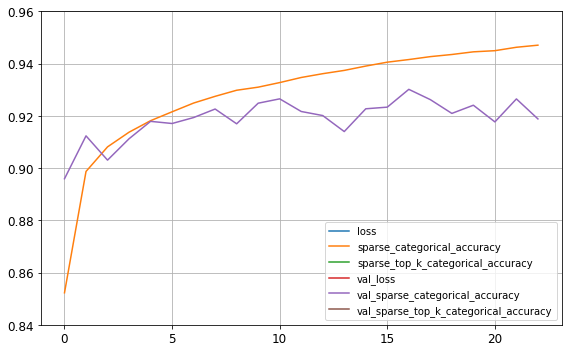

In [107]:
pd.DataFrame(history_2_1_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.5)
save_fig("model_2_1_4_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_1_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.84, 0.96)
save_fig("model_2_1_4_learning_curves_plot_accuracy")
plt.show()

#### 2.1.5 Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E)

In [84]:
X_train_only = np.load("./SplittedDatasets/8/X_train_only_8.npy")
y_train_only = np.load("./SplittedDatasets/8/y_train_only_8.npy")
X_val_only = np.load("./SplittedDatasets/8/X_val_only_8.npy")
y_val_only = np.load("./SplittedDatasets/8/y_val_only_8.npy")

In [85]:
print(X_train_only.shape)
X_train_only = np.squeeze(X_train_only, axis=3)
print(X_train_only.shape)
X_train_only = X_train_only.reshape(-1, 784)
print(X_train_only.shape)

(608836, 28, 28, 1)
(608836, 28, 28)
(608836, 784)


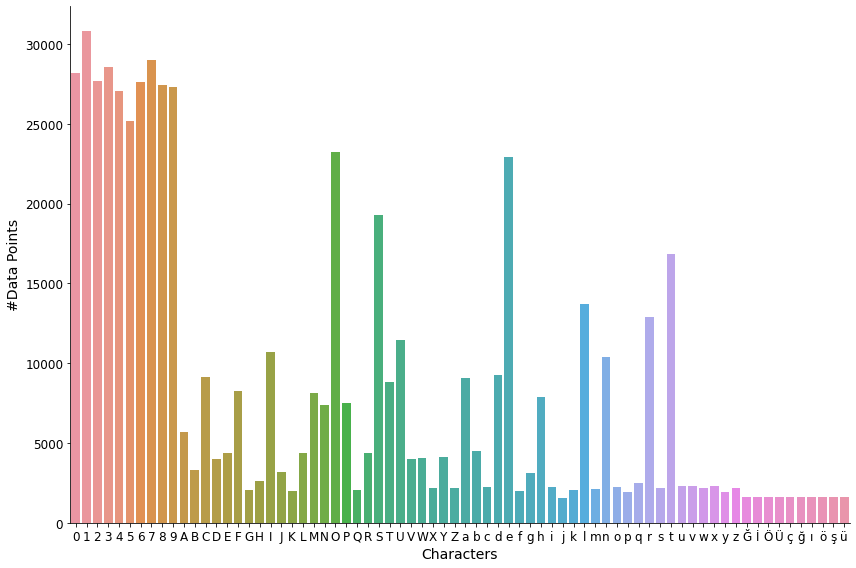

In [86]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_only == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
# save_fig('Combination 8 Training_Only Set class Distributions', tight_layout=True)

In [87]:
random_undersampling_strategy_dictionary = {}

for i in range(0,72,1):
    if i < 10:
        random_undersampling_strategy_dictionary[i] = int(np.count_nonzero(y_train_only == i) / 3)
    else:
        random_undersampling_strategy_dictionary[i] = np.count_nonzero(y_train_only == i)

print(random_undersampling_strategy_dictionary)

{0: 9397, 1: 10273, 2: 9229, 3: 9529, 4: 9026, 5: 8388, 6: 9201, 7: 9664, 8: 9148, 9: 9104, 10: 5676, 11: 3313, 12: 9165, 13: 4006, 14: 4390, 15: 8265, 16: 2086, 17: 2650, 18: 10675, 19: 3209, 20: 2002, 21: 4361, 22: 8122, 23: 7411, 24: 23231, 25: 7514, 26: 2078, 27: 4403, 28: 19299, 29: 8851, 30: 11458, 31: 4010, 32: 4071, 33: 2212, 34: 4121, 35: 2185, 36: 9068, 37: 4496, 38: 2262, 39: 9251, 40: 22922, 41: 2020, 42: 3109, 43: 7868, 44: 2258, 45: 1550, 46: 2075, 47: 13719, 48: 2134, 49: 10413, 50: 2236, 51: 1945, 52: 2524, 53: 12907, 54: 2185, 55: 16843, 56: 2298, 57: 2312, 58: 2186, 59: 2284, 60: 1911, 61: 2208, 62: 1620, 63: 1620, 64: 1620, 65: 1620, 66: 1620, 67: 1620, 68: 1620, 69: 1620, 70: 1620, 71: 1620}


In [88]:
randomUnderSampler = RandomUnderSampler(sampling_strategy=random_undersampling_strategy_dictionary, random_state=42)
X_train_only_RUSE, y_train_only_RUSE = randomUnderSampler.fit_resample(X_train_only, y_train_only)

Saving figure Combination 8 only Random Undersampled Training_Only Set class Distributions


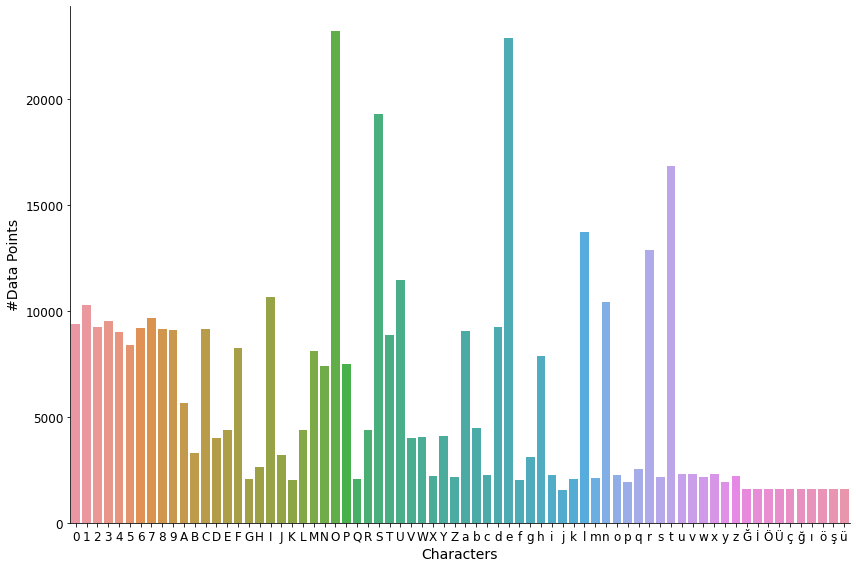

In [89]:
characters = [decodeLabel(x) for x in range(0,72,1)] # Ş und Ç fehlen
frequecies = [np.count_nonzero(y_train_only_RUSE == x) for x in range(0,72,1)]

data = {
    'Characters': characters,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

freq_catplot = sns.catplot(x="Characters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
save_fig('Combination 8 only Random Undersampled Training_Only Set class Distributions', tight_layout=True)

In [90]:
print(X_train_only_RUSE.shape)

(422907, 784)


In [91]:
X_train_only_RUSE, y_train_only_RUSE = shuffle(X_train_only_RUSE, y_train_only_RUSE, random_state=42)

In [92]:
X_train_only_RUSE = X_train_only_RUSE[:, :].reshape(-1, 28, 28)

In [93]:
X_train_only_RUSE = X_train_only_RUSE[..., np.newaxis]

In [94]:
np.save("./SplittedDatasets/8/RandomResampling/X_train_only_RUSE.npy", X_train_only_RUSE)
np.save("./SplittedDatasets/8/RandomResampling/y_train_only_RUSE.npy", y_train_only_RUSE)

In [95]:
baseline_model_2_1_5 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [96]:
baseline_model_2_1_5.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [97]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_1_5.h5", save_best_only=True)

In [98]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_1_5"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [99]:
model_2_1_5_t0 = time.time()
history_2_1_5 = baseline_model_2_1_5.fit(X_train_only_RUSE, y_train_only_RUSE, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_1_5_t1 = time.time()

Epoch 1/100
13216/13216 [==============================] - 289s 22ms/step - loss: 0.3744 - sparse_categorical_accuracy: 0.8774 - sparse_top_k_categorical_accuracy: 0.9693 - val_loss: 0.2553 - val_sparse_categorical_accuracy: 0.9021 - val_sparse_top_k_categorical_accuracy: 0.9838
Epoch 2/100
13216/13216 [==============================] - 285s 22ms/step - loss: 0.2546 - sparse_categorical_accuracy: 0.9104 - sparse_top_k_categorical_accuracy: 0.9833 - val_loss: 0.2408 - val_sparse_categorical_accuracy: 0.9082 - val_sparse_top_k_categorical_accuracy: 0.9886
Epoch 3/100
13216/13216 [==============================] - 286s 22ms/step - loss: 0.2167 - sparse_categorical_accuracy: 0.9219 - sparse_top_k_categorical_accuracy: 0.9913 - val_loss: 0.2396 - val_sparse_categorical_accuracy: 0.9098 - val_sparse_top_k_categorical_accuracy: 0.9920
Epoch 4/100
13216/13216 [==============================] - 286s 22ms/step - loss: 0.1924 - sparse_categorical_accuracy: 0.9296 - sparse_top_k_categorical_accura

In [100]:
print("Training took {:.2f}s for all Epochs".format(model_2_1_5_t1 - model_2_1_5_t0))

Training took 6607.61s for all Epochs


In [101]:
history_2_1_5.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [102]:
print("Best Training Accuracy: ", round(history_2_1_5.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_1_5.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_1_5.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_1_5.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_1_5.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_1_5.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.94288
Best Training Loss:  0.14795
Best Training Top k Accuracy:  0.99756
Best Validation Accuracy:  0.92918
Best Validation Loss:  0.20044
Best Validation Top k Accuracy:  0.99463


In [103]:
baseline_model_2_1_5.save("./Model_Checkpoints/baseline_model_2_1_5")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_1_5\assets


In [153]:
np.save('./Histories/history_2_1_5.npy', history_2_1_5.history)

Saving figure model_2_1_5_learning_curves_plot_loss


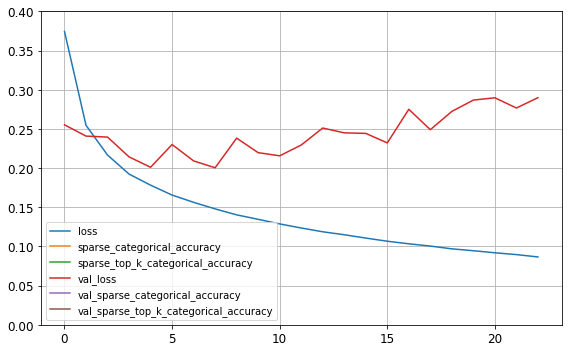

Saving figure model_2_1_5_learning_curves_plot_accuracy


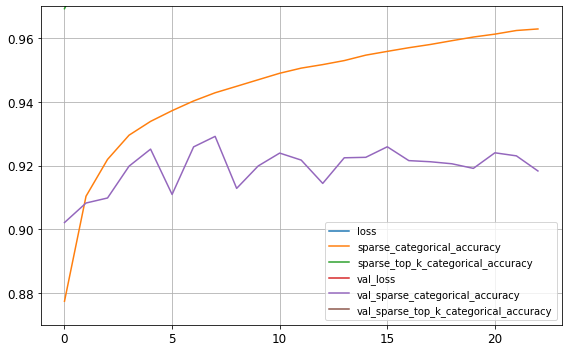

In [106]:
pd.DataFrame(history_2_1_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.4)
save_fig("model_2_1_5_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_1_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.87, 0.97)
save_fig("model_2_1_5_learning_curves_plot_accuracy")
plt.show()

#### 2.1.6 Class-weighted Combination of (Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E)

In [108]:
X_train = np.load("./SplittedDatasets/8/RandomResampling/X_train_only_RUSE.npy")
y_train = np.load("./SplittedDatasets/8/RandomResampling/y_train_only_RUSE.npy")
X_val_only = np.load("./SplittedDatasets/8/X_val_only_8.npy")
y_val_only = np.load("./SplittedDatasets/8/y_val_only_8.npy")

In [109]:
from sklearn.utils import class_weight
y_train_class_weights = y_train.reshape(-1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train_class_weights)

In [110]:
class_weights = {i : class_weights[i] for i in range(class_weights.shape[0])}

In [111]:
baseline_model_2_1_6 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.AvgPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(72, activation="softmax")
])

In [112]:
baseline_model_2_1_6.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=[keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

In [113]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Models/baseline_model_2_1_6.h5", save_best_only=True)

In [114]:
root_logdir = "./Tensorboard_Logs/baseline_model_2_1_6"

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [115]:
model_2_1_6_t0 = time.time()
history_2_1_6 = baseline_model_2_1_6.fit(X_train, y_train, class_weight=class_weights, epochs=100, validation_data=(X_val_only, y_val_only), callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
model_2_1_6_t1 = time.time()

Epoch 1/100
13216/13216 [==============================] - 288s 22ms/step - loss: 0.5636 - sparse_categorical_accuracy: 0.8442 - sparse_top_k_categorical_accuracy: 0.9626 - val_loss: 0.2984 - val_sparse_categorical_accuracy: 0.8958 - val_sparse_top_k_categorical_accuracy: 0.9824
Epoch 2/100
13216/13216 [==============================] - 286s 22ms/step - loss: 0.3728 - sparse_categorical_accuracy: 0.8900 - sparse_top_k_categorical_accuracy: 0.9850 - val_loss: 0.2883 - val_sparse_categorical_accuracy: 0.8955 - val_sparse_top_k_categorical_accuracy: 0.9882
Epoch 3/100
13216/13216 [==============================] - 285s 22ms/step - loss: 0.2947 - sparse_categorical_accuracy: 0.9036 - sparse_top_k_categorical_accuracy: 0.9913 - val_loss: 0.2522 - val_sparse_categorical_accuracy: 0.9120 - val_sparse_top_k_categorical_accuracy: 0.9913
Epoch 4/100
13216/13216 [==============================] - 285s 22ms/step - loss: 0.2579 - sparse_categorical_accuracy: 0.9104 - sparse_top_k_categorical_accura

In [116]:
print("Training took {:.2f}s for all Epochs".format(model_2_1_6_t1 - model_2_1_6_t0))

Training took 7373.15s for all Epochs


In [117]:
history_2_1_6.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy'])

In [118]:
print("Best Training Accuracy: ", round(history_2_1_6.history['sparse_categorical_accuracy'][-16], 5))
print("Best Training Loss: ", round(history_2_1_6.history['loss'][-16], 5))
print("Best Training Top k Accuracy: ", round(history_2_1_6.history['sparse_top_k_categorical_accuracy'][-16], 5))
print("Best Validation Accuracy: ", round(history_2_1_6.history['val_sparse_categorical_accuracy'][-16], 5))
print("Best Validation Loss: ", round(history_2_1_6.history['val_loss'][-16], 5))
print("Best Validation Top k Accuracy: ", round(history_2_1_6.history['val_sparse_top_k_categorical_accuracy'][-16], 5))

Best Training Accuracy:  0.93175
Best Training Loss:  0.16804
Best Training Top k Accuracy:  0.99734
Best Validation Accuracy:  0.92337
Best Validation Loss:  0.22518
Best Validation Top k Accuracy:  0.99409


In [119]:
baseline_model_2_1_6.save("./Model_Checkpoints/baseline_model_2_1_6")

INFO:tensorflow:Assets written to: ./Model_Checkpoints/baseline_model_2_1_6\assets


In [152]:
np.save('./Histories/history_2_1_6.npy', history_2_1_6.history)

Saving figure model_2_1_6_learning_curves_plot_loss


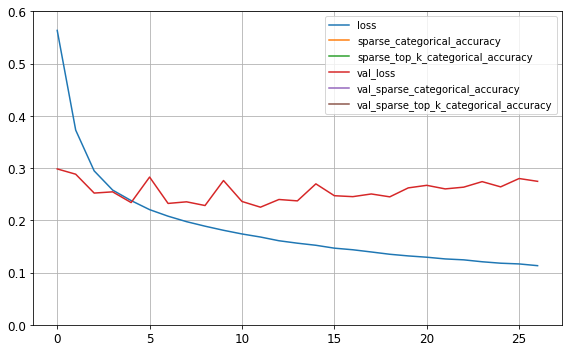

Saving figure model_2_1_6_learning_curves_plot_accuracy


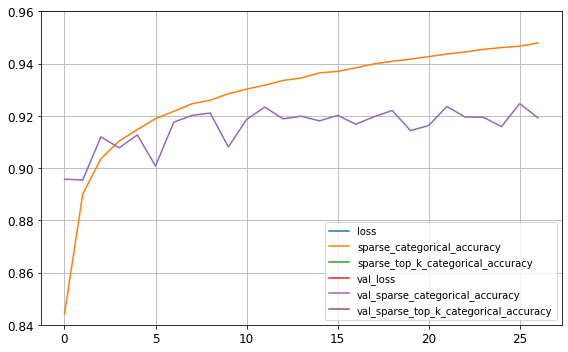

In [142]:
pd.DataFrame(history_2_1_6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.6)
save_fig("model_2_1_6_learning_curves_plot_loss")
plt.show()

pd.DataFrame(history_2_1_6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.84, 0.96)
save_fig("model_2_1_6_learning_curves_plot_accuracy")
plt.show()

#### 2.1.7 Comparsion between random undersampled combinations

In [121]:
combinations = [
    "Combination 2",
    "Class-weigted Combination 2",
    "Combination 5",
    "Class-weigted Combination 5",
    "Combination 8",
    "Class-weigted Combination 8"
]

In [122]:
val_losses = [
    history_2_1_1.history['val_loss'][-16],
    history_2_1_2.history['val_loss'][-16],
    history_2_1_3.history['val_loss'][-16],
    history_2_1_4.history['val_loss'][-16],
    history_2_1_5.history['val_loss'][-16],
    history_2_1_6.history['val_loss'][-16]
]

val_loss_data = {
    'Random Undersampled Combinations': combinations,
    'Validation Losses (Lower is better)': val_losses
}
val_loss_df = pd.DataFrame(val_loss_data)

Saving figure Validation Losses between Random Undersampled Combinations


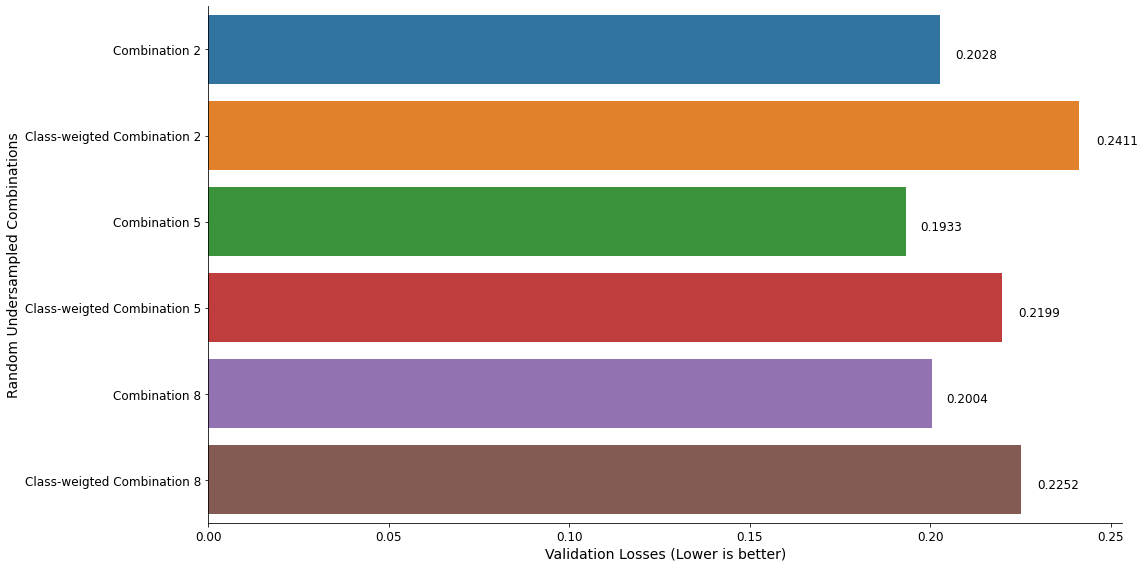

In [123]:
val_loss_catplot = sns.catplot(y="Random Undersampled Combinations", x="Validation Losses (Lower is better)", kind="bar", height=8, aspect=2, orient='h',  data=val_loss_df)
val_loss_catplot.set_yticklabels(fontsize=12, rotation=0)
val_loss_catplot.set_xticklabels(fontsize=12, rotation=0)
ax5 = val_loss_catplot.facet_axis(0,0)
for p in ax5.patches:
    ax5.text( p.get_width() * 1.02,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validation Losses between Random Undersampled Combinations', tight_layout=True)

In [124]:
val_accuracies = [
    history_2_1_1.history['val_sparse_categorical_accuracy'][-16],
    history_2_1_2.history['val_sparse_categorical_accuracy'][-16],
    history_2_1_3.history['val_sparse_categorical_accuracy'][-16],
    history_2_1_4.history['val_sparse_categorical_accuracy'][-16],
    history_2_1_5.history['val_sparse_categorical_accuracy'][-16],
    history_2_1_6.history['val_sparse_categorical_accuracy'][-16]
]

val_accuracies_data = {
    'Random Undersampled Combinations': combinations,
    'Validation Accuracy (Higher is better)': val_accuracies
}
val_accuracies_data_df = pd.DataFrame(val_accuracies_data)

Saving figure Validation Accuracy between Random Undersampled Combinations


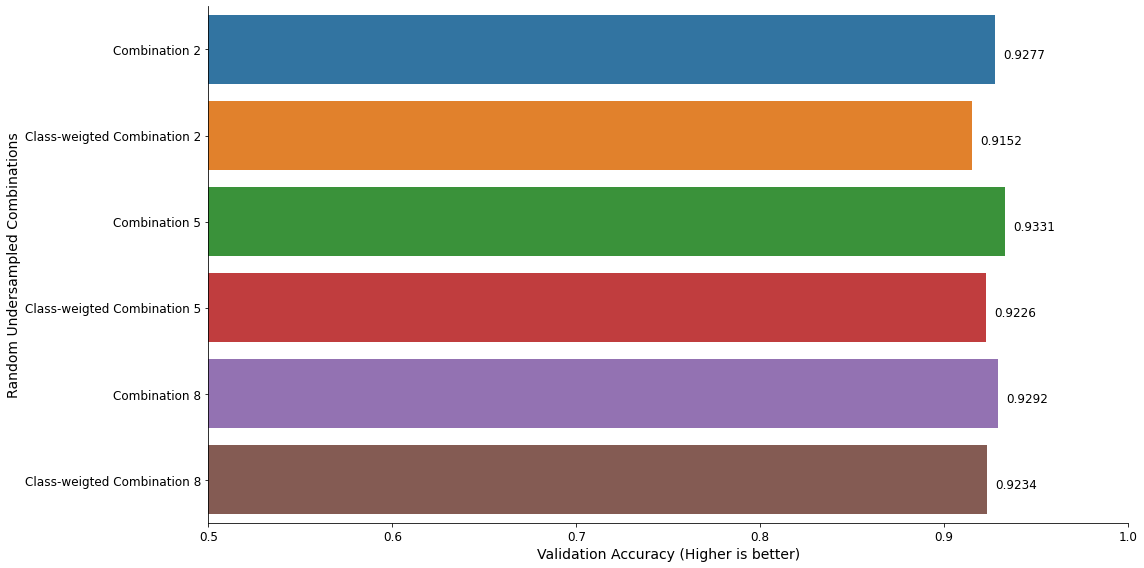

In [125]:
val_accuracies_catplot = sns.catplot(y="Random Undersampled Combinations", x="Validation Accuracy (Higher is better)", kind="bar", height=8, aspect=2, orient='h',  data=val_accuracies_data_df)
val_accuracies_catplot.set_yticklabels(fontsize=12, rotation=0)
ax6 = val_accuracies_catplot.facet_axis(0,0)
val_accuracies_catplot.set(xlim=(0.5,1))
for p in ax6.patches:
    ax6.text( p.get_width() * 1.005,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validation Accuracy between Random Undersampled Combinations', tight_layout=True)

In [126]:
epoch_train_time = [
    (model_2_1_1_t1 - model_2_1_1_t0) / len(history_2_1_1.history['val_loss']),
    (model_2_1_2_t1 - model_2_1_2_t0) / len(history_2_1_2.history['val_loss']),
    (model_2_1_3_t1 - model_2_1_3_t0) / len(history_2_1_3.history['val_loss']),
    (model_2_1_4_t1 - model_2_1_4_t0) / len(history_2_1_4.history['val_loss']),
    (model_2_1_5_t1 - model_2_1_5_t0) / len(history_2_1_5.history['val_loss']),
    (model_2_1_6_t1 - model_2_1_6_t0) / len(history_2_1_6.history['val_loss']),
]

train_time_data = {
    'Random Undersampled Combinations': combinations,
    'Training Time per Epoch (Lower is better)': epoch_train_time
}
train_time_data_df = pd.DataFrame(train_time_data)

Saving figure Training Time Per Epoch between Random Undersampled Combinations


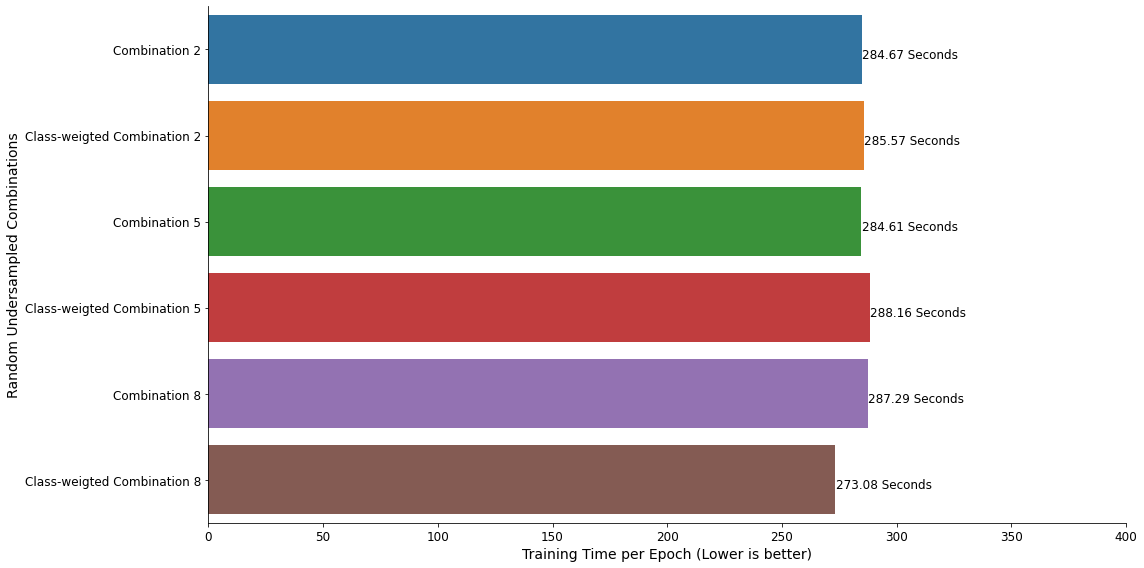

In [127]:
train_time_catplot = sns.catplot(y="Random Undersampled Combinations", x="Training Time per Epoch (Lower is better)", kind="bar", height=8, aspect=2, orient='h',  data=train_time_data_df)
train_time_catplot.set_yticklabels(fontsize=12, rotation=0)
ax7 = train_time_catplot.facet_axis(0,0)
train_time_catplot.set(xlim=(0,400))
for p in ax7.patches:
    ax7.text( p.get_width() * 1.001,
            p.get_y() + 0.5,
            '{0:.2f} Seconds'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Training Time Per Epoch between Random Undersampled Combinations', tight_layout=True)

In [128]:
combinations_de = [
    "2. Kombination",
    "Klassengewichteten 2. Kombination",
    "5. Kombination",
    "Klassengewichteten 5. Kombination",
    "8. Kombination",
    "Klassengewichteten 8. Kombination"
]

In [129]:
val_losses = [
    history_2_1_1.history['val_loss'][-16],
    history_2_1_2.history['val_loss'][-16],
    history_2_1_3.history['val_loss'][-16],
    history_2_1_4.history['val_loss'][-16],
    history_2_1_5.history['val_loss'][-16],
    history_2_1_6.history['val_loss'][-16],
]

val_loss_data = {
    'Zufällig-undersampled Kombinationen': combinations_de,
    'Validierungsverlust (Niedriger ist besser)': val_losses
}
val_loss_df = pd.DataFrame(val_loss_data)

Saving figure Validierungsverluste zwischen zufällig-undersampled Kombinationen


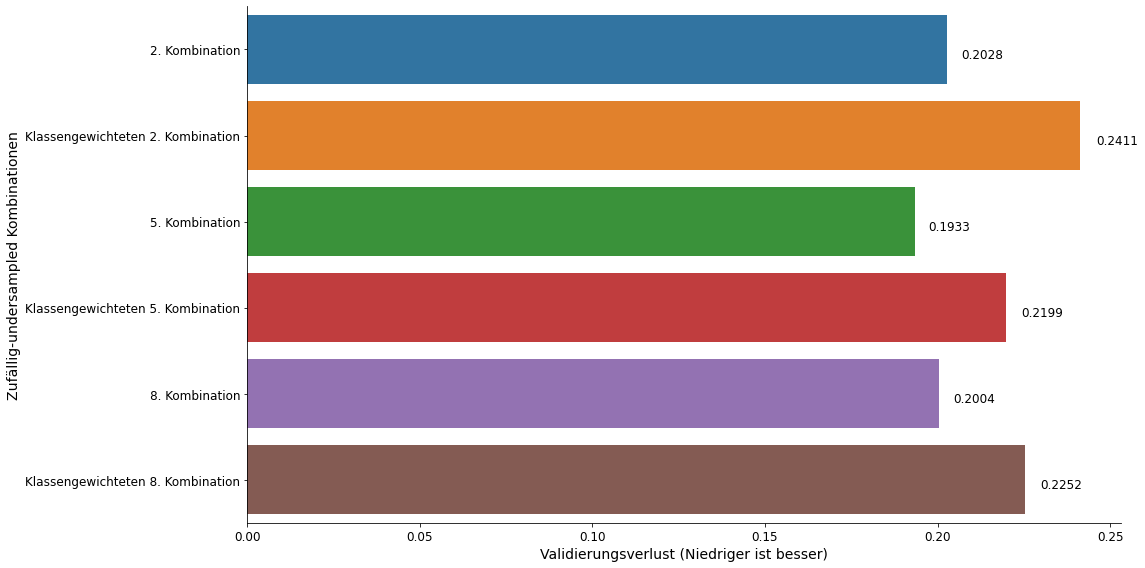

In [130]:
val_loss_catplot = sns.catplot(y="Zufällig-undersampled Kombinationen", x="Validierungsverlust (Niedriger ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=val_loss_df)
val_loss_catplot.set_yticklabels(fontsize=12, rotation=0)
val_loss_catplot.set_xticklabels(fontsize=12, rotation=0)
ax5 = val_loss_catplot.facet_axis(0,0)
for p in ax5.patches:
    ax5.text( p.get_width() * 1.02,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validierungsverluste zwischen zufällig-undersampled Kombinationen', tight_layout=True)

In [131]:
val_accuracies = [
    history_2_1_1.history['val_sparse_categorical_accuracy'][-16],
    history_2_1_2.history['val_sparse_categorical_accuracy'][-16],
    history_2_1_3.history['val_sparse_categorical_accuracy'][-16],
    history_2_1_4.history['val_sparse_categorical_accuracy'][-16],
    history_2_1_5.history['val_sparse_categorical_accuracy'][-16],
    history_2_1_6.history['val_sparse_categorical_accuracy'][-16]
]

val_accuracies_data = {
    'Zufällig-undersampled Kombinationen': combinations_de,
    'Validierungsgenauigkeit (Höher ist besser)': val_accuracies
}
val_accuracies_data_df = pd.DataFrame(val_accuracies_data)

Saving figure Validierungsgenauigkeit zwischen zufällig-undersampled Kombinationen


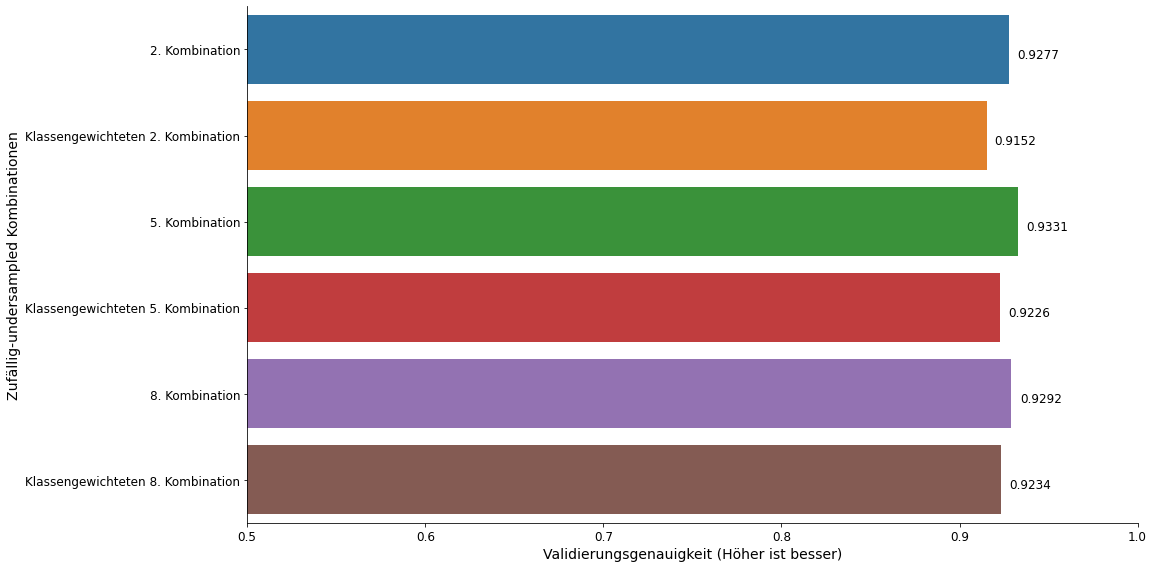

In [132]:
val_accuracies_catplot = sns.catplot(y="Zufällig-undersampled Kombinationen", x="Validierungsgenauigkeit (Höher ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=val_accuracies_data_df)
val_accuracies_catplot.set_yticklabels(fontsize=12, rotation=0)
ax6 = val_accuracies_catplot.facet_axis(0,0)
val_accuracies_catplot.set(xlim=(0.5,1))
for p in ax6.patches:
    ax6.text( p.get_width() * 1.005,
            p.get_y() + 0.5,
            '{0:.4f}'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Validierungsgenauigkeit zwischen zufällig-undersampled Kombinationen', tight_layout=False)

In [133]:
epoch_train_time = [
    (model_2_1_1_t1 - model_2_1_1_t0) / len(history_2_1_1.history['val_loss']),
    (model_2_1_2_t1 - model_2_1_2_t0) / len(history_2_1_2.history['val_loss']),
    (model_2_1_3_t1 - model_2_1_3_t0) / len(history_2_1_3.history['val_loss']),
    (model_2_1_4_t1 - model_2_1_4_t0) / len(history_2_1_4.history['val_loss']),
    (model_2_1_5_t1 - model_2_1_5_t0) / len(history_2_1_5.history['val_loss']),
    (model_2_1_6_t1 - model_2_1_6_t0) / len(history_2_1_6.history['val_loss'])
]

train_time_data = {
    'Zufällig-undersampled Kombinationen': combinations_de,
    'Trainingszeit pro Epoche (Niedriger ist besser)': epoch_train_time
}
train_time_data_df = pd.DataFrame(train_time_data)

Saving figure Trainingszeit pro Epoche zwischen zufällig-undersampled Kombinationen


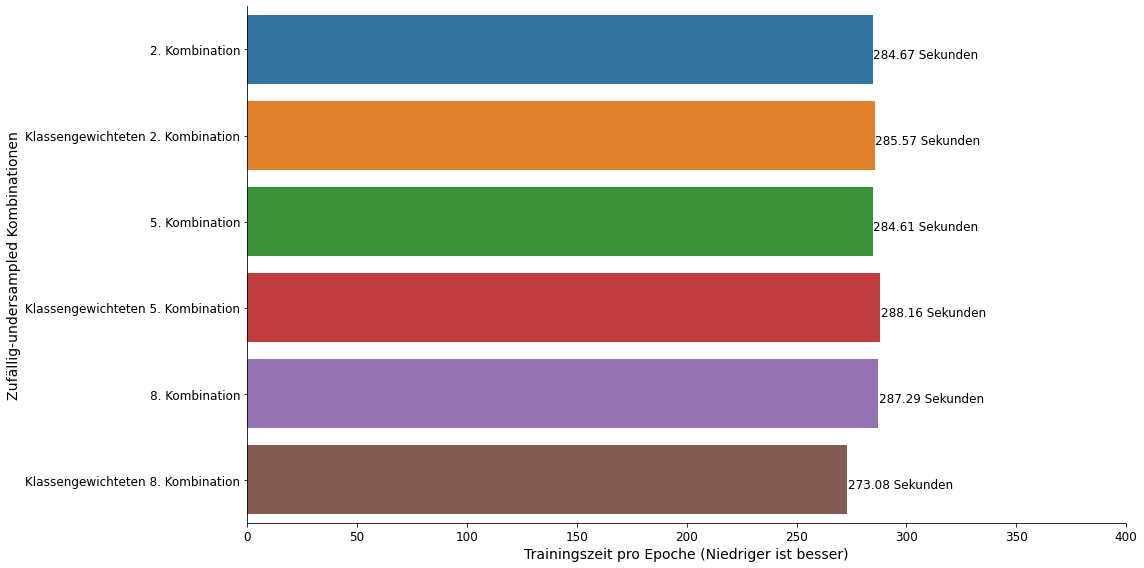

In [134]:
train_time_catplot = sns.catplot(y="Zufällig-undersampled Kombinationen", x="Trainingszeit pro Epoche (Niedriger ist besser)", kind="bar", height=8, aspect=2, orient='h',  data=train_time_data_df)
train_time_catplot.set_yticklabels(fontsize=12, rotation=0)
ax7 = train_time_catplot.facet_axis(0,0)
train_time_catplot.set(xlim=(0,400))
for p in ax7.patches:
    ax7.text( p.get_width() * 1.001,
            p.get_y() + 0.5,
            '{0:.2f} Sekunden'.format(p.get_width()),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('Trainingszeit pro Epoche zwischen zufällig-undersampled Kombinationen', tight_layout=True)